<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Allianz/Allianz_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ALVDEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 11:46:56,904 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 11:46:56,906 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for ALVDEEUR
2019-08-28 11:50:06,956 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 11:57:19,733 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 12:00:35,340 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 12:03:22,555 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 12:06:53,442 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 12:10:30,231 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 12:14:13,398 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 12:17:43,064 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 12:28:31,070 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_ALVDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-ALVDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-ALVDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  1.91687  1.92858  1.91228  1.91948  85.143776
2018-01-02 09:00:00  1.91937  1.92277  1.90457  1.91027  72.249908
2018-01-02 10:00:00  1.91028  1.91958  1.91018  1.91657  37.364281
2018-01-02 11:00:00  1.91658  1.91898  1.91357  1.91578  30.487045
2018-01-02 12:00:00  1.91577  1.91698  1.91438  1.91577  17.663847
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  1.72178  1.74218  1.72178  1.74198  46.422348
2018-12-28 09:00:00  1.74178  1.74377  1.73597  1.74357  53.723831
2018-12-28 10:00:00  1.74338  1.75298  1.74257  1.75017  39.945435
2018-12-28 11:00:00  1.75037  1.75918  1.74677  1.75378  35.628971
2018-12-28 12:00:00  1.75378  1.75877  1.75277  1.75697  34.192638

[2248 rows x 5 columns]

Open         High          Low        Close       Volume
count  2248.000000  2248.000000  2248.000000  2248.000000  2248.000000
mean      1.873636     1.878337     1.868821     1.873606    42.497013
std       0.073320     0.072984     0.073804     0.073406    25.481480
min       1.704780     1.714180     1.700870     1.704780     0.001004
25%       1.821523     1.826378     1.814722     1.821177    24.053136
50%       1.870375     1.874675     1.865570     1.870320    36.727219
75%       1.915380     1.919780     1.910372     1.915428    54.937027
max       2.065980     2.067480     2.062970     2.065970   167.302994

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2018-01-09 13:00:00  1.98878  1.99278  1.98857  1.99277  17.637878    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.989049  1.971039  1.986884  1.991982  1.990562  1.988543    1.990175    1.991120  1.987370  1.990511  1.990792  1.990604  1.990809  1.990511  1.990637  1.986532                1.994213                 1.990511                1.986809                1.996064                 1.990511                1.984958                1.997915                 1.990511                1.983107                1.999766                 1.990511                1.981256  1.990562  1.991319  1.987749                1.994264                 1.990562                1.986860                1.996115                 1.990562                1.985009                1.997966                 1.990562                1.983158                1.999817                 1.990562                1.981307   
2018-01-09 14:00:00  1.99278  1.99378  1.98937  1.99178  31.668394    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.990414  1.975883  1.987370  1.992148  1.990833  1.988570    1.990175    1.991120  1.987370  1.990612  1.991141  1.990814  1.991091  1.990612  1.992275  1.987196                1.994402                 1.990612                1.986823                1.996297                 1.990612                1.984928                1.998192                 1.990612                1.983033                2.000087                 1.990612                1.981138  1.990833  1.991746  1.988287                1.994623                 1.990833                1.987043                1.996518                 1.990833                1.985148                1.998412                 1.990833                1.983253                2.000307                 1.990833                1.981358   
2018-01-09 15:00:00 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000    2198.000000  2198.000000   2198.000000     2198.000000       2198.000000  2198.000000  2198.000000  2198.000000  2198.000000   2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000   
mean      1.871747     1.876454     1.866903     1.871705    42.687035    15.966333     2.031392   184.349864      30.415833    11.379436      0.032302        0.024113          0.004095     6.562784     2.522748    26.902639     2.031392      1.989081    26.902639     1.872448     1.873468     0.104761     1.871693     1.872097     1.872249     1.871889     1.871393     1.871364     1.872091     1.871691     1.872088     1.871959     1.872091     1.871750     1.872904                1.886665                 1.872091                1.857517                1.893953                 1.872091                1.850229                1.901240                 1.872091                1.842942                1.908527                 1.872091                1.835655     1.872097     1.871775     1.872786                1.886672                 1.872097                1.857523                1.893959                 1.872097                1.850236                1.901246   
std       0.072923     0.072593     0.073384     0.072998    25.589466     8.543804     1.407250   101.416032       0.857091     2.621951      0.176841        0.153434          0.063873     3.339045     1.100412    14.487877     1.407250      1.400263    14.487877     0.072533     0.071131     1.869414     0.073160     0.072229     0.071915     0.072518     0.072637     0.073705     0.072462     0.073097     0.072575     0.072552     0.072462     0.072874     0.071498                0.071847                 0.072462                0.074277                0.072002                 0.072462                0.075610                0.072463                 0.072462                0.077208                0.073226                 0.072462                0.079055     0.072229     0.072792     0.071640                0.071595                 0.072229                0.074065                0.071743                 0.072229                0.075410                0.072197   
min       1.704780     1.714180     1.700870     1.704780     0.001004     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.786268  0.788565  0.794532  0.797337  0.105419    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.797502  0.749123  0.984782  0.793950  0.794514  0.787480    0.795948    0.800454  0.781484  0.792846  0.789320  0.790996  0.792721  0.792846  0.790190  0.787189                0.775004                 0.792846                0.810219                0.766021                 0.792846                0.821242                0.739100                 0.792846                0.833008                0.678930                 0.792846                0.843806  0.794514  0.794054  0.790314                0.776707                 0.794514                0.810941                0.769935                 0.794514                0.821184                0.755199                 0.794514                0.833827                0.691870                 0.794514   
2018-01-09 14:00:00  0.797342  0.791395  0.796741  0.794596  0.189283    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.801453  0.763862  0.984901  0.794419  0.795305  0.787563    0.795948    0.800454  0.781484  0.793144  0.790300  0.791606  0.793538  0.793144  0.794856  0.789197                0.775563                 0.793144                0.810257                0.766704                 0.793144                0.821159                0.739887                 0.793144                0.832814                0.679771                 0.793144                0.843510  0.795305  0.795263  0.791936                0.777772                 0.795305                0.811460                0.771128                 0.795305                0.821569                0.756504                 0.795305                0.834079                0.693189                 0.795305   
2018-01-09 15:00:00  0.794297  0.807784  0.800608  0.810100  0.165602    9          1          9         

139819

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx3z7aexa
  JVM stdout: /tmp/tmpx3z7aexa/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpx3z7aexa/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_38u2wu
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.589705  1.479497              0.500000  0.612073  0.374633
1  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.583126  0.692535              0.500000  0.499696  0.249696
2              DeepLearning_1_AutoML_20190828_123833  0.578575  0.679401              0.441576  0.493299  0.243344
3  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.569182  0.740949              0.424032  0.520204  0.270613
4  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.554287  0.820340              0.416253  0.537236  0.288623
5  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.514151  0.722323              0.470291  0.513277  0.263453
6  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.509351  2.461050              0.500000  0.657515  0.432326
7  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.507324  0.705112              0.500000  0.505820  0.255854
8  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.500000  0.702754              0.500000  0.504757  0.254780
9  DeepLearning_grid_1_AutoML_20190828_123833_mod...  0.475132  0.695952              0.500000  0.501364  0.251366

variable  relative_importance  scaled_importance  percentage
0         CDLGAPSIDESIDEWHITE             1.000000           1.000000    0.002127
1         CDLRISEFALL3METHODS             0.982557           0.982557    0.002090
2          CDLEVENINGDOJISTAR             0.963101           0.963101    0.002049
3                   CDLINNECK             0.960237           0.960237    0.002043
4                CDLTASUKIGAP             0.960166           0.960166    0.002043
...                       ...                  ...                ...         ...
1033  BBANDS_lowerband_12_4_3             0.408738           0.408738    0.000870
1034   BBANDS_lowerband_8_6_5             0.408722           0.408722    0.000869
1035                    DX_24             0.407716           0.407716    0.000867
1036  BBANDS_upperband_12_5_2             0.407177           0.407177    0.000866
1037                     SINH             0.400317           0.400317    0.000852

[1038 rows x 4 columns]

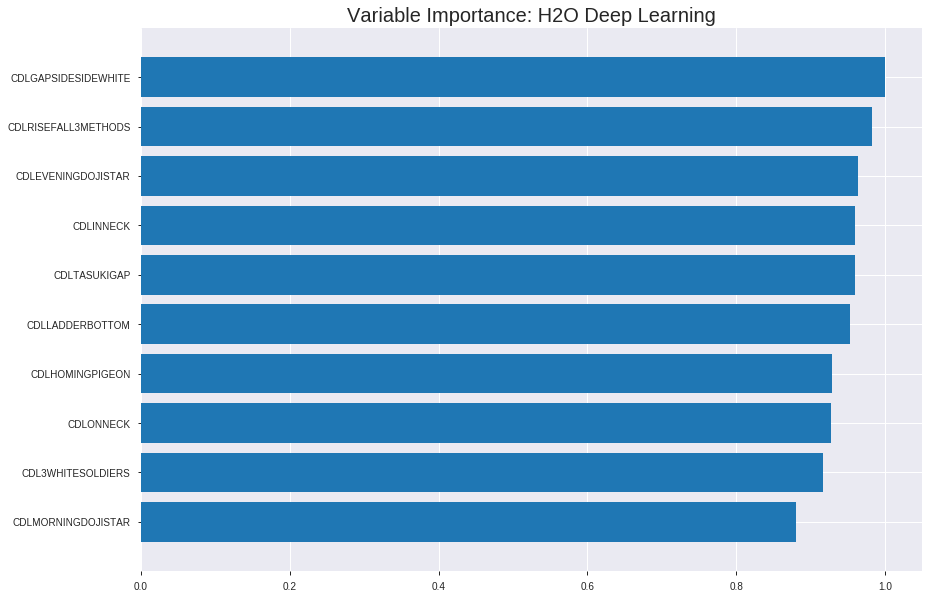

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_123833_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24606432534478254
RMSE: 0.49604871267324396
LogLoss: 0.799309332211741
Mean Per-Class Error: 0.3361960644855382
AUC: 0.7108074239653186
pr_auc: 0.6554490795208334
Gini: 0.4216148479306372
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2579531210304863: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      289  471   0.6197   (471.0/760.0)
1      64   713   0.0824   (64.0/777.0)
Total  353  1184  0.3481   (535.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257953     0.72718   294
max f2                       0.102645     0.854069  351
max f0point5                 0.570036     0.662731  197
max accuracy                 0.570036     0.664932  197
max precision                0.99918      0.833333  0
max recall                   0.00354423   1         397
max specificity              0.99918      0.997368  0
max absolute_mcc             0.257953     0.354093  294
max min_per_class_accuracy   0.708256     0.644788  149
max mean_per_class_accuracy  0.570036     0.663804  197

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 60.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.997866           1.60722   1.60722            0.8125           0.998954   0.8125                      0.998954            0.016731        0.016731                   60.7223   60.7223
    2        0.0201692                   0.996614           1.055     1.34002            0.533333         0.997221   0.677419                    0.998115            0.010296        0.027027                   5.49979   34.0017
    3        0.0305791                   0.994836           1.48359   1.38889            0.75             0.995803   0.702128                    0.997328            0.015444        0.042471                   48.3591   38.8893
    4        0.0403383                   0.992499           1.45062   1.40383            0.733333         0.993823   0.709677                    0.99648             0.014157        0.0566281                  45.0622   40.3828
    5        0.0500976                   0.991175           1.31875   1.38725            0.666667         0.991753   0.701299                    0.995559            0.01287         0.0694981                  31.8747   38.7254
    6        0.100195                    0.978695           1.36156   1.37441            0.688312         0.985028   0.694805                    0.990294            0.0682111       0.137709                   36.1564   37.4409
    7        0.150293                    0.963683           1.43863   1.39582            0.727273         0.971697   0.705628                    0.984095            0.0720721       0.209781                   43.8633   39.5817
    8        0.20039                     0.946197           1.31018   1.37441            0.662338         0.953724   0.694805                    0.976502            0.0656371       0.275418                   31.0184   37.4409
    9        0.299935                    0.888823           1.40925   1.38597            0.712418         0.919275   0.700651                    0.957509            0.140283        0.415701                   40.925    38.5972
    10       0.40013                     0.813872           1.16889   1.33161            0.590909         0.853079   0.673171                    0.931359            0.117117        0.532819                   16.889    33.1613
    11       0.500325                    0.708116           1.10466   1.28616            0.558442         0.764291   0.650195                    0.897902            0.110682        0.643501                   10.4665   28.6164
    12       0.59987                     0.574612           1.1636    1.26583            0.588235         0.649609   0.639913                    0.856699            0.11583         0.759331                   16.3601   26.5826
    13       0.700065                    0.392605           0.937681  1.21886            0.474026         0.480412   0.616171                    0.802844            0.0939511       0.853282                   -6.23193  21.8861
    14       0.79961                     0.212314           0.840378  1.17174            0.424837         0.297553   0.592352                    0.73994             0.0836551       0.936937                   -15.9622  17.1743
    15       0.899805                    0.0774182          0.449573  1.09133            0.227273         0.142287   0.551699                    0.67339             0.045045        0.981982                   -55.0427  9.13278
    16       1                           8.22278e-05        0.179829  1                  0.0909091        0.0370531  0.50553                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35406238086827296
RMSE: 0.5950314116651935
LogLoss: 1.0707080841658805
Mean Per-Class Error: 0.4873648478752829
AUC: 0.4966997736987679
pr_auc: 0.5602073201386139
Gini: -0.006600452602464224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00908177738027757: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00908178   0.717201   399
max f2                       0.00908178   0.863764   399
max f0point5                 0.00908178   0.613161   399
max accuracy                 0.0114629    0.559091   398
max precision                0.999669     1          0
max recall                   0.00908178   1          399
max specificity              0.999669     1          0
max absolute_mcc             0.0301402    0.0659309  386
max min_per_class_accuracy   0.492111     0.495935   196
max mean_per_class_accuracy  0.544714     0.512635   179

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 47.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.990469           1.43089   1.43089            0.8              0.993883   0.8                         0.993883            0.0162602       0.0162602                  43.0894   43.0894
    2        0.0204545                   0.983343           0.894309  1.19241            0.5              0.988228   0.666667                    0.99137             0.00813008      0.0243902                  -10.5691  19.2412
    3        0.0318182                   0.976532           0.715447  1.02207            0.4              0.981714   0.571429                    0.987921            0.00813008      0.0325203                  -28.4553  2.20674
    4        0.0409091                   0.966077           0.894309  0.993677           0.5              0.96929    0.555556                    0.983781            0.00813008      0.0406504                  -10.5691  -0.63234
    5        0.05                        0.95839            0.894309  0.97561            0.5              0.962945   0.545455                    0.979993            0.00813008      0.0487805                  -10.5691  -2.43902
    6        0.1                         0.906116           1.05691   1.01626            0.590909         0.936651   0.568182                    0.958322            0.0528455       0.101626                   5.69106   1.62602
    7        0.15                        0.866466           0.894309  0.97561            0.5              0.886454   0.545455                    0.934366            0.0447154       0.146341                   -10.5691  -2.43902
    8        0.2                         0.819538           1.05691   0.995935           0.590909         0.851157   0.556818                    0.913564            0.0528455       0.199187                   5.69106   -0.406504
    9        0.3                         0.70768            1.05691   1.01626            0.590909         0.76638    0.568182                    0.864502            0.105691        0.304878                   5.69106   1.62602
    10       0.4                         0.60638            0.97561   1.0061             0.545455         0.658562   0.5625                      0.813017            0.097561        0.402439                   -2.43902  0.609756
    11       0.5                         0.483941           0.934959  0.99187            0.522727         0.545977   0.554545                    0.759609            0.0934959       0.495935                   -6.50407  -0.813008
    12       0.6                         0.319926           0.894309  0.97561            0.5              0.396429   0.545455                    0.699079            0.0894309       0.585366                   -10.5691  -2.43902
    13       0.7                         0.214296           1.13821   0.998839           0.636364         0.259541   0.558442                    0.636288            0.113821        0.699187                   13.8211   -0.116144
    14       0.8                         0.134425           0.934959  0.990854           0.522727         0.174222   0.553977                    0.57853             0.0934959       0.792683                   -6.50407  -0.914634
    15       0.9                         0.0714009          1.09756   1.00271            0.613636         0.100788   0.560606                    0.525447            0.109756        0.902439                   9.7561    0.271003
    16       1                           0.00896325         0.97561   1                  0.545455         0.0403884  0.559091     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:43:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:43:51  6.481 sec         138 obs/sec       0.330514  1             508        0.667451         4.07026             -0.782184      0.513784        0.427072           1.11269          0.49447                          0.667128           3.3469                -0.805457        0.547691          0.601217             0.715447           0.434091
    2019-08-28 12:44:16  31.831 sec        148 obs/sec       2.58686   8             3976       0.590008         1.48745             -0.392609      0.568156        0.562198           1.23633          0.49447                          0.596548           1.25683               -0.443644        0.565104          0.593059             0.715447           0.436364
    2019-08-28 12:44:39  55.074 sec        155 obs/sec       4.85882   15            7468       0.585103         1.31014             -0.369548      0.612167        0.556738           1.48359          0.446975                         0.589624           1.11699               -0.410322        0.499623          0.5774               1.43089            0.436364
    2019-08-28 12:45:04  1 min 19.486 sec  162 obs/sec       7.43201   23            11423      0.620542         1.5401              -0.540476      0.653532        0.668706           1.85449          0.443722                         0.70292            2.14972               -1.00438         0.517392          0.567698             1.07317            0.418182
    2019-08-28 12:45:27  1 min 42.419 sec  169 obs/sec       10.002    31            15373      0.60211          1.5672              -0.450322      0.657365        0.568701           1.60722          0.372804                         0.601578           1.35498               -0.468091        0.473766          0.545283             1.43089            0.438636
    2019-08-28 12:45:48  2 min  4.307 sec  175 obs/sec       12.6038   39            19372      0.496049         0.799309            0.0156223      0.710807        0.655449           1.60722          0.348081                         0.595031           1.07071               -0.43631         0.4967            0.560207             1.43089            0.440909
    2019-08-28 12:46:13  2 min 28.450 sec  180 obs/sec       15.568    48            23928      0.560491         1.2478              -0.256755      0.675084        0.643254           1.73086          0.361744                         0.591481           1.22984               -0.41922         0.494405          0.549016             1.43089            0.438636
    2019-08-28 12:46:35  2 min 51.342 sec  185 obs/sec       18.4684   57            28386      0.468232         0.672393            0.122926       0.771228        0.765273           1.85449          0.321405                         0.617096           1.2114                -0.544808        0.497412          0.55562              0.715447           0.440909
    2019-08-28 12:46:58

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLGAPSIDESIDEWHITE      1.0                    1.0                  0.0021273299836496824
CDLRISEFALL3METHODS      0.9825568795204163     0.9825568795204163   0.00209022271044505
CDLEVENINGDOJISTAR       0.9631011486053467     0.9631011486053467   0.0020488339507156025
CDLINNECK                0.9602367877960205     0.9602367877960205   0.002042740510081932
CDLTASUKIGAP             0.9601658582687378     0.9601658582687378   0.0020425896195718175
---                      ---                    ---                  ---
BBANDS_lowerband_12_4_3  0.40873849391937256    0.40873849391937256  0.0008695216535864947
BBANDS_lowerband_8_6_5   0.40872156620025635    0.40872156620025635  0.0008694856427420639
DX_24                    0.4077160060405731     0.4077160060405731   0.0008673464844640063
BBANDS_upperband_12_5_2  0.4071766138076782     0.4071766138076782   0.0008661990191940212
SINH                     0.4003165066242218     0.4003165066242218   0.0008516053074916038


See the whole table with table.as_data_frame()


('accuracy', 0.6)

('F1', 0.6503067484662576)

('auc', 0.5897053955643827)

('logloss', 1.4794965235947755)

('mean_per_class_error', 0.41046011254551473)

('rmse', 0.6120728232611807)

('mse', 0.37463314097491257)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


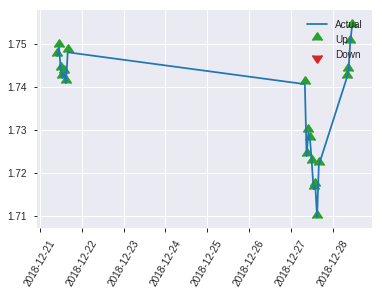


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.37463314097491257
RMSE: 0.6120728232611807
LogLoss: 1.4794965235947755
Mean Per-Class Error: 0.41046011254551473
AUC: 0.5897053955643827
pr_auc: 0.5761899007822464
Gini: 0.17941079112876546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.68856355834143e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    106  0        (0.0/106.0)
Total  0    220  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       9.68856e-05  0.650307  219
max f2                       9.68856e-05  0.822981  219
max f0point5                 0.621363     0.572776  158
max accuracy                 0.990513     0.6       45
max precision                0.998931     0.833333  5
max recall                   9.68856e-05  1         219
max specificity              0.999865     0.991228  0
max absolute_mcc             0.990513     0.220038  45
max min_per_class_accuracy   0.912444     0.556604  108
max mean_per_class_accuracy  0.990513     0.58954   45

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 74.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.999464           1.38365   1.38365            0.666667         0.999718  0.666667                    0.999718            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.999014           2.07547   1.66038            1                0.999099  0.8                         0.99947             0.0188679       0.0377358                  107.547   66.0377
    3        0.0318182                   0.998763           1.03774   1.48248            0.5              0.998855  0.714286                    0.999295            0.00943396      0.0471698                  3.77358   48.248
    4        0.0409091                   0.998697           2.07547   1.61426            1                0.998741  0.777778                    0.999172            0.0188679       0.0660377                  107.547   61.4256
    5        0.05                        0.998305           2.07547   1.69811            1                0.998574  0.818182                    0.999063            0.0188679       0.0849057                  107.547   69.8113
    6        0.1                         0.996353           0.943396  1.32075            0.454545         0.99748   0.636364                    0.998272            0.0471698       0.132075                   -5.66038  32.0755
    7        0.15                        0.99363            1.69811   1.44654            0.818182         0.995239  0.69697                     0.997261            0.0849057       0.216981                   69.8113   44.6541
    8        0.2                         0.990765           1.32075   1.41509            0.636364         0.992667  0.681818                    0.996112            0.0660377       0.283019                   32.0755   41.5094
    9        0.3                         0.983139           0.849057  1.22642            0.409091         0.987662  0.590909                    0.993295            0.0849057       0.367925                   -15.0943  22.6415
    10       0.4                         0.960913           0.849057  1.13208            0.409091         0.974391  0.545455                    0.988569            0.0849057       0.45283                    -15.0943  13.2075
    11       0.5                         0.907056           1.03774   1.11321            0.5              0.937742  0.536364                    0.978404            0.103774        0.556604                   3.77358   11.3208
    12       0.6                         0.801602           0.943396  1.08491            0.454545         0.842715  0.522727                    0.955789            0.0943396       0.650943                   -5.66038  8.49057
    13       0.7                         0.645335           1.22642   1.10512            0.590909         0.737658  0.532468                    0.924627            0.122642        0.773585                   22.6415   10.5121
    14       0.8                         0.455794           0.660377  1.04953            0.318182         0.560143  0.505682                    0.879067            0.0660377       0.839623                   -33.9623  4.95283
    15       0.9                         0.238188           0.754717  1.01677            0.363636         0.344674  0.489899                    0.81969             0.0754717       0.915094                   -24.5283  1.67715
    16       1                           9.68856e-05        0.849057  1                  0.409091         0.115005  0.481818                    0.749221          

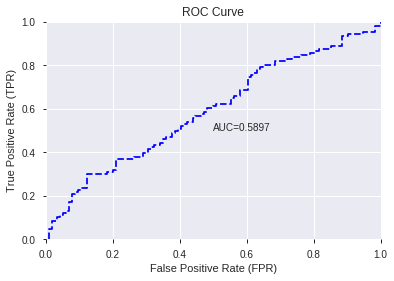

This function is available for GLM models only


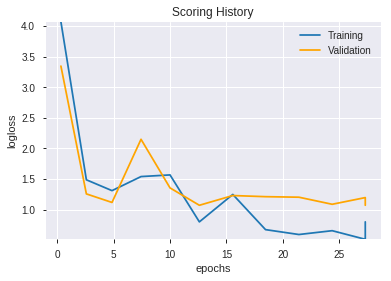

--2019-08-28 13:02:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  52.9MB/s    in 6.7s    

2019-08-28 13:02:58 (52.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_123833_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_123833_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_130308_model_9  0.567196  0.703283              0.500000  0.505016  0.255041
1  DeepLearning_grid_1_AutoML_20190828_130308_model_1  0.552218  1.327150              0.500000  0.590155  0.348282
2  DeepLearning_grid_1_AutoML_20190828_130308_model_3  0.515310  0.807206              0.482787  0.523508  0.274061
3               DeepLearning_1_AutoML_20190828_130308  0.514482  0.774783              0.500000  0.523465  0.274015
4  DeepLearning_grid_1_AutoML_20190828_130308_model_2  0.503889  0.961892              0.466567  0.566966  0.321451
5  DeepLearning_grid_1_AutoML_20190828_130308_model_5  0.493462  0.714273              0.495614  0.509885  0.259983
6  DeepLearning_grid_1_AutoML_20190828_130308_model_4  0.469215  0.923283              0.500000  0.569024  0.323789
7  DeepLearning_grid_1_AutoML_20190828_130308_model_7  0.456389  0.858919              0.495614  0.556477  0.309666
8  DeepLearning_grid_1_AutoML_20190828_130308_model_6  0.441245  0.715845              0.491228  0.511018  0.261139
9  DeepLearning_grid_1_AutoML_20190828_130308_model_8  0.347195  0.711672              0.500000  0.509075  0.259158

variable  relative_importance  scaled_importance  percentage
0                  hour             1.000000           1.000000    0.022682
1                  CEIL             0.997258           0.997258    0.022620
2         days_in_month             0.958749           0.958749    0.021747
3                 MFI_8             0.953138           0.953138    0.021619
4              CORREL_8             0.953034           0.953034    0.021617
5                BETA_8             0.943406           0.943406    0.021399
6                 FLOOR             0.943134           0.943134    0.021392
7        CDLEVENINGSTAR             0.940085           0.940085    0.021323
8               BETA_20             0.936616           0.936616    0.021245
9        CDLRICKSHAWMAN             0.933306           0.933306    0.021169
10                  TAN             0.931988           0.931988    0.021140
11                  BOP             0.925102           0.925102    0.020983
12         HT_TRENDMODE             0.921613           0.921613    0.020904
13     CDLDRAGONFLYDOJI             0.920221           0.920221    0.020873
14    CDLSTALLEDPATTERN             0.916297           0.916297    0.020784
15         CDLTHRUSTING             0.915914           0.915914    0.020775
16    CDLINVERTEDHAMMER             0.915195           0.915195    0.020759
17            CDLTAKURI             0.911685           0.911685    0.020679
18       is_month_start             0.906267           0.906267    0.020556
19      CDLADVANCEBLOCK             0.900176           0.900176    0.020418
20    CDLDARKCLOUDCOVER             0.889931           0.889931    0.020186
21       CDLMORNINGSTAR             0.879563           0.879563    0.019950
22   CDLMORNINGDOJISTAR             0.877676           0.877676    0.019908
23         is_month_end             0.873009           0.873009    0.019802
24   CDLCLOSINGMARUBOZU             0.871248           0.871248    0.019762
25            CDLONNECK             0.869043           0.869043    0.019712
26  CDLRISEFALL3METHODS             0.866834           0.866834    0.019662
27       CDLMATCHINGLOW             0.861599           0.861599    0.019543
28   CDLIDENTICAL3CROWS             0.861348           0.861348    0.019537
29        CDLHANGINGMAN             0.861003           0.861003    0.019529
30    CDLGRAVESTONEDOJI             0.859670           0.859670    0.019499
31      CDLSHOOTINGSTAR             0.859137           0.859137    0.019487
32    CDL3WHITESOLDIERS             0.853472           0.853472    0.019359
33            CDLHAMMER             0.851774           0.851774    0.019320
34          CDLPIERCING             0.850004           0.850004    0.019280
35         CDLTASUKIGAP             0.848398           0.848398    0.019244
36   CDLSEPARATINGLINES             0.842762           0.842762    0.019116
37                  SUB             0.840821           0.840821    0.019072
38  CDLGAPSIDESIDEWHITE             0.839499           0.839499    0.019042
39      CDLLADDERBOTTOM             0.837057           0.837057    0.018986
40       CDL3LINESTRIKE             0.835216           0.835216    0.018945
41      CDLHOMINGPIGEON             0.833557           0.833557    0.018907
42    CDLLONGLEGGEDDOJI             0.832843           0.832843    0.018891
43            CDLINNECK             0.826513           0.826513    0.018747
44  CDLXSIDEGAP3METHODS             0.820786           0.820786    0.018617
45       CDLHARAMICROSS             0.818907           0.818907    0.018575
46           CDL3INSIDE             0.816756           0.816756    0.018526
47   CDLEVENINGDOJISTAR             0.806656           0.806656    0.018297
48        CDLHIKKAKEMOD             0.796987           0.796987    0.018077
49          CDLDOJISTAR             0.782174           0.782174    0.017741

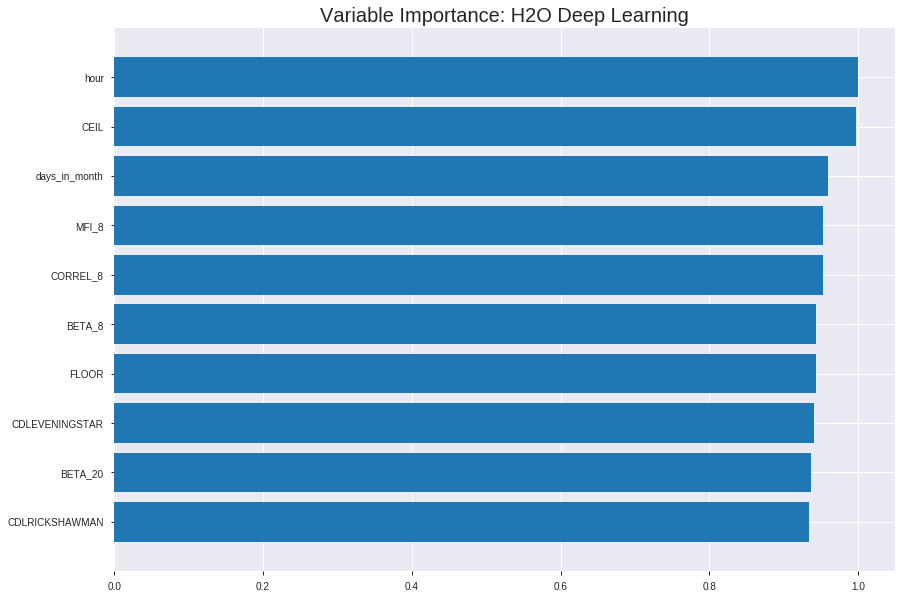

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_130308_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2524699156320058
RMSE: 0.5024638450993323
LogLoss: 0.6981202824792397
Mean Per-Class Error: 0.49618217841902046
AUC: 0.4855178486757434
pr_auc: 0.4849079642833985
Gini: -0.02896430264851324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5555001011089276: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    760   1        (760.0/760.0)
1      0    777   0        (0.0/777.0)
Total  0    1537  0.4945   (760.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.5555       0.671564   233
max f2                       0.5555       0.836383   233
max f0point5                 0.5555       0.561011   233
max accuracy                 0.5555       0.50553    233
max precision                0.559611     1          0
max recall                   0.5555       1          233
max specificity              0.559611     1          0
max absolute_mcc             0.555528     0.0478175  186
max min_per_class_accuracy   0.5555       0.137709   232
max mean_per_class_accuracy  0.557679     0.503818   11

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 55.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.557479           1.35996   1.35996            0.6875           0.557994  0.6875                      0.557994            0.014157        0.014157                   35.9958   35.9958
    2        0.0201692                   0.556907           0.791248  1.08478            0.4              0.557198  0.548387                    0.557609            0.00772201      0.021879                   -20.8752  8.4776
    3        0.0305791                   0.556682           0.865428  1.0101             0.4375           0.556807  0.510638                    0.557336            0.00900901      0.030888                   -13.4572  1.01043
    4        0.0403383                   0.556451           1.18687   1.05287            0.6              0.556578  0.532258                    0.557153            0.011583        0.042471                   18.6873   5.28708
    5        0.0500976                   0.556033           0.923123  1.0276             0.466667         0.556184  0.519481                    0.556964            0.00900901      0.0514801                  -7.68769  2.75953
    6        0.100195                    0.555552           0.822076  0.924836           0.415584         0.555659  0.467532                    0.556311            0.041184        0.0926641                  -17.7924  -7.51642
    7        0.150293                    0.555502           0.847766  0.899146           0.428571         0.555526  0.454545                    0.55605             0.042471        0.135135                   -15.2234  -10.0854
    8        1                           0.5555             1.01784   1                  0.514548         0.5555    0.50553                     0.555583            0.864865        1                          1.78387   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24651795743087823
RMSE: 0.4965057476312618
LogLoss: 0.6861670043460415
Mean Per-Class Error: 0.4823987930600956
AUC: 0.5074176514961026
pr_auc: 0.5852810777635229
Gini: 0.014835302992205257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5555001011089276: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.5555       0.717201   35
max f2                       0.5555       0.863764   35
max f0point5                 0.5555       0.613161   35
max accuracy                 0.5555       0.559091   35
max precision                0.555625     0.785714   13
max recall                   0.5555       1          35
max specificity              0.557152     0.994845   0
max absolute_mcc             0.555553     0.0839076  19
max min_per_class_accuracy   0.555505     0.0853659  32
max mean_per_class_accuracy  0.555553     0.517601   19

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 55.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.556415           1.07317   1.07317            0.6              0.556708  0.6                         0.556708            0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.555855           1.34146   1.19241            0.75             0.556147  0.666667                    0.556459            0.0121951       0.0243902                  34.1463   19.2412
    3        0.0318182                   0.555624           1.78862   1.40534            1                0.55569   0.785714                    0.556184            0.0203252       0.0447154                  78.8618   40.5343
    4        0.0409091                   0.555574           0.894309  1.29178            0.5              0.555595  0.722222                    0.556053            0.00813008      0.0528455                  -10.5691  29.178
    5        0.05                        0.55553            0.894309  1.21951            0.5              0.55555   0.681818                    0.555962            0.00813008      0.0609756                  -10.5691  21.9512
    6        1                           0.5555             0.988447  1                  0.552632         0.555501  0.559091                    0.555524            0.939024        1                          -1.15533  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:09:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:09:30  1 min 54.829 sec  482 obs/sec       0.593364  1             912        0.6156           1.09598             -0.516037      0.535689        0.526522           0.98906          0.489265                         0.657743           1.27522               -0.755014        0.468548          0.533359             0.715447           0.440909
    2019-08-28 13:09:39  2 min  4.421 sec  792 obs/sec       5.46649   9             8402       0.501218         0.695595            -0.0049998     0.520059        0.520402           1.23633          0.493819                         0.496763           0.686682              -0.00107431      0.542924          0.578725             0.715447           0.440909
    2019-08-28 13:09:48  2 min 13.353 sec  953 obs/sec       11.5433   19            17742      0.500193         0.693533            -0.000893883   0.510027        0.520419           1.23633          0.493819                         0.502033           0.697223              -0.0224271       0.462545          0.527213             0.715447           0.440909
    2019-08-28 13:09:57  2 min 22.649 sec  1103 obs/sec      19.3826   32            29791      0.502464         0.69812             -0.0100032     0.485518        0.484908           1.35996          0.49447                          0.496506           0.686167              -3.93211e-05     0.507418          0.585281             1.07317            0.440909
    2019-08-28 13:10:07  2 min 31.814 sec  1268 obs/sec      29.1165   48            44752      0.499965         0.693077            1.8784e-05     0.513893        0.0710697          1.01485          0.489265                         0.499395           0.691939              -0.0117138       0.462356          0.0781162            0.962751           0.438636
    2019-08-28 13:10:16  2 min 41.037 sec  1367 obs/sec      38.8081   64            59648      0.501459         0.696075            -0.00596648    0.5             0                  1                0.49447                          0.504981           0.703174              -0.0344699       0.5               0                    1                  0.440909
    2019-08-28 13:10:25  2 min 50.234 sec  1523 obs/sec      51.4802   85            79125      0.499752         0.692652            0.000868218    0.548459        0.552711           1.11269          0.49447                          0.50093            0.695009              -0.0179399       0.468454          0.523264             0                  0.440909
    2019-08-28 13:10:26  2 min 51.140 sec  1522 obs/sec      51.4802   85            79125      0.502464         0.69812             -0.0100032     0.485518        0.484908           1.35996          0.49447                          0.496506           0.686167              -3.93211e-05     0.507418          0.585281             1.07317            0.440909

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
hour                1.0                    1.0                  0.022682203295038308
CEIL                0.9972575902938843     0.9972575902938843   0.022619999400565905
days_in_month       0.9587491750717163     0.9587491750717163   0.021746543697926942
MFI_8               0.953137993812561      0.953137993812561    0.021619269743881474
CORREL_8            0.9530336856842041     0.9530336856842041   0.021616903805708756
---                 ---                    ---                  ---
CDLHARAMICROSS      0.8189069628715515     0.8189069628715515   0.01857461421157492
CDL3INSIDE          0.8167557716369629     0.8167557716369629   0.018525820454665474
CDLEVENINGDOJISTAR  0.8066557049751282     0.8066557049751282   0.018296728689348302
CDLHIKKAKEMOD       0.7969868183135986     0.7969868183135986   0.018077417036454803
CDLDOJISTAR         0.7821740508079529     0.7821740508079529   0.01774143083252961


See the whole table with table.as_data_frame()


('accuracy', 0.5818181818181818)

('F1', 0.6503067484662576)

('auc', 0.5671962926183383)

('logloss', 0.7032828628145443)

('mean_per_class_error', 0.43032108573320094)

('rmse', 0.5050159455600797)

('mse', 0.2550411052699414)

deeplearning prediction progress: |███████████████████████████████████████| 100%


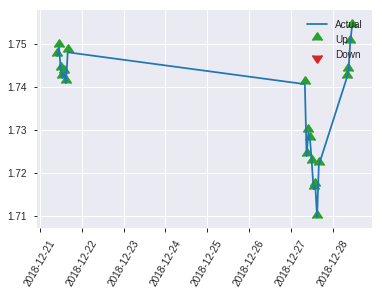


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2550411052699414
RMSE: 0.5050159455600797
LogLoss: 0.7032828628145443
Mean Per-Class Error: 0.43032108573320094
AUC: 0.5671962926183383
pr_auc: 0.596224331615617
Gini: 0.13439258523667652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5555001011089276: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    106  0        (0.0/106.0)
Total  0    220  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5555       0.650307  41
max f2                       0.5555       0.822981  41
max f0point5                 0.5555       0.537525  41
max accuracy                 0.555549     0.581818  35
max precision                0.558948     1         0
max recall                   0.5555       1         41
max specificity              0.558948     1         0
max absolute_mcc             0.555549     0.188225  35
max min_per_class_accuracy   0.555503     0.254717  40
max mean_per_class_accuracy  0.555549     0.569679  35

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 55.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.558476           2.07547   2.07547            1                0.558806  1                           0.558806            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.557286           1.03774   1.66038            0.5              0.557586  0.8                         0.558318            0.00943396      0.0377358                  3.77358   66.0377
    3        0.0318182                   0.556881           0         1.18598            0                0.556899  0.571429                    0.557913            0               0.0377358                  -100      18.5984
    4        0.0409091                   0.556824           2.07547   1.38365            1                0.556872  0.666667                    0.557682            0.0188679       0.0566038                  107.547   38.3648
    5        0.05                        0.556733           2.07547   1.50943            1                0.556791  0.727273                    0.55752             0.0188679       0.0754717                  107.547   50.9434
    6        0.1                         0.556276           1.50943   1.50943            0.727273         0.556488  0.727273                    0.557004            0.0754717       0.150943                   50.9434   50.9434
    7        0.15                        0.55559            1.32075   1.44654            0.636364         0.555925  0.69697                     0.556644            0.0660377       0.216981                   32.0755   44.6541
    8        1                           0.5555             0.921199  1                  0.44385          0.555501  0.481818                    0.555673            0.783019        1                          -7.88013  0

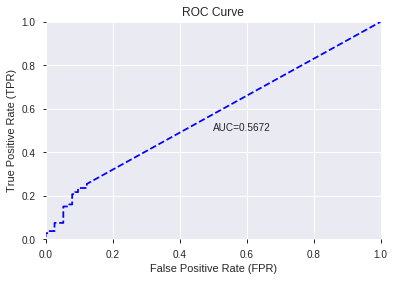

This function is available for GLM models only


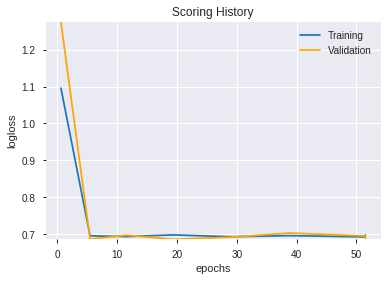

--2019-08-28 13:10:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_130308_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_130308_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['hour',
 'CEIL',
 'days_in_month',
 'MFI_8',
 'CORREL_8',
 'BETA_8',
 'FLOOR',
 'CDLEVENINGSTAR',
 'BETA_20',
 'CDLRICKSHAWMAN',
 'TAN',
 'BOP',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CDLTAKURI',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDLDARKCLOUDCOVER',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'CDLCLOSINGMARUBOZU',
 'CDLONNECK',
 'CDLRISEFALL3METHODS',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLHAMMER',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLSEPARATINGLINES',
 'SUB',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'CDL3LINESTRIKE',
 'CDLHOMINGPIGEON',
 'CDLLONGLEGGEDDOJI',
 'CDLINNECK',
 'CDLXSIDEGAP3METHODS',
 'CDLHARAMICROSS',
 'CDL3INSIDE',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDLDOJISTAR']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_131039_model_1  0.452334  0.695189                   0.5  0.501019  0.251021

variable  relative_importance  scaled_importance  percentage
0    CDLCLOSINGMARUBOZU             0.009186           1.000000    0.053085
1             CDLTAKURI             0.008327           0.906456    0.048120
2          CDLTHRUSTING             0.007996           0.870512    0.046212
3        CDLHARAMICROSS             0.007730           0.841493    0.044671
4                  hour             0.007396           0.805184    0.042744
5      CDLDRAGONFLYDOJI             0.007322           0.797125    0.042316
6            CDL3INSIDE             0.007319           0.796746    0.042296
7                BETA_8             0.006266           0.682094    0.036209
8       CDLHOMINGPIGEON             0.005724           0.623141    0.033080
9     CDLDARKCLOUDCOVER             0.005653           0.615404    0.032669
10        CDLHIKKAKEMOD             0.005475           0.596073    0.031643
11         is_month_end             0.004928           0.536423    0.028476
12             CORREL_8             0.004805           0.523066    0.027767
13    CDLSTALLEDPATTERN             0.004228           0.460316    0.024436
14   CDLIDENTICAL3CROWS             0.004217           0.459109    0.024372
15  CDLRISEFALL3METHODS             0.004102           0.446594    0.023708
16    CDL3WHITESOLDIERS             0.004093           0.445553    0.023652
17  CDLGAPSIDESIDEWHITE             0.004075           0.443581    0.023548
18          CDLPIERCING             0.004032           0.438880    0.023298
19   CDLEVENINGDOJISTAR             0.003977           0.432951    0.022983
20      CDLLADDERBOTTOM             0.003879           0.422279    0.022417
21            CDLINNECK             0.003751           0.408307    0.021675
22            CDLONNECK             0.003746           0.407837    0.021650
23      CDLSHOOTINGSTAR             0.003596           0.391427    0.020779
24       CDLEVENINGSTAR             0.003343           0.363876    0.019317
25                  BOP             0.003167           0.344778    0.018303
26                  SUB             0.002717           0.295803    0.015703
27         HT_TRENDMODE             0.002372           0.258225    0.013708
28   CDLMORNINGDOJISTAR             0.002152           0.234227    0.012434
29                FLOOR             0.002092           0.227752    0.012090
30                 CEIL             0.002077           0.226060    0.012001
31    CDLGRAVESTONEDOJI             0.001976           0.215103    0.011419
32       CDL3LINESTRIKE             0.001919           0.208871    0.011088
33  CDLXSIDEGAP3METHODS             0.001861           0.202555    0.010753
34          CDLDOJISTAR             0.001816           0.197659    0.010493
35       CDLMATCHINGLOW             0.001705           0.185573    0.009851
36      CDLADVANCEBLOCK             0.001698           0.184842    0.009812
37       is_month_start             0.001649           0.179557    0.009532
38       CDLRICKSHAWMAN             0.001625           0.176940    0.009393
39        days_in_month             0.001620           0.176400    0.009364
40                  TAN             0.001519           0.165389    0.008780
41   CDLSEPARATINGLINES             0.001484           0.161502    0.008573
42    CDLLONGLEGGEDDOJI             0.001256           0.136772    0.007261
43       CDLMORNINGSTAR             0.001220           0.132772    0.007048
44                MFI_8             0.000964           0.104919    0.005570
45              BETA_20             0.000494           0.053739    0.002853
46        CDLHANGINGMAN             0.000232           0.025273    0.001342
47    CDLINVERTEDHAMMER             0.000110           0.011978    0.000636
48         CDLTASUKIGAP             0.000095           0.010365    0.000550
49            CDLHAMMER             0.000056           0.006062    0.000322

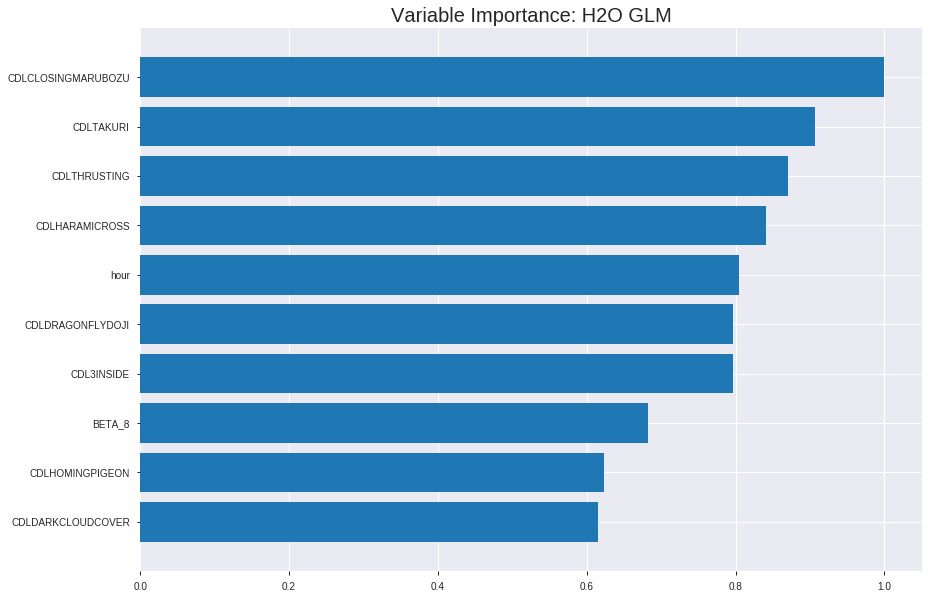

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_131039_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2486335846490407
RMSE: 0.4986317124381889
LogLoss: 0.6904109377621562
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.5464005801423
Residual deviance: 2122.3232226808686
AIC: 2224.3232226808686
AUC: 0.5848421730000678
pr_auc: 0.5848030061764965
Gini: 0.1696843460001356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49639195966167526: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      68   692   0.9105   (692.0/760.0)
1      23   754   0.0296   (23.0/777.0)
Total  91   1446  0.4652   (715.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496392     0.678363  330
max f2                       0.478135     0.837838  382
max f0point5                 0.502418     0.581374  258
max accuracy                 0.505808     0.56864   191
max precision                0.574224     1         0
max recall                   0.472169     1         392
max specificity              0.574224     1         0
max absolute_mcc             0.505808     0.136965  191
max min_per_class_accuracy   0.505955     0.564474  188
max mean_per_class_accuracy  0.505808     0.568436  191

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.524647           1.73086   1.73086            0.875            0.538847  0.875                       0.538847            0.018018        0.018018                   73.0856   73.0856
    2        0.0201692                   0.519528           1.31875   1.53145            0.666667         0.521728  0.774194                    0.530563            0.01287         0.030888                   31.8747   53.1448
    3        0.0305791                   0.517185           1.35996   1.47307            0.6875           0.518293  0.744681                    0.526386            0.014157        0.045045                   35.9958   47.3069
    4        0.0403383                   0.515862           1.31875   1.43573            0.666667         0.516408  0.725806                    0.523972            0.01287         0.0579151                  31.8747   43.5733
    5        0.0500976                   0.514464           1.5825    1.46432            0.8              0.515017  0.74026                     0.522228            0.015444        0.0733591                  58.2497   46.4323
    6        0.100195                    0.511803           1.10466   1.28449            0.558442         0.512902  0.649351                    0.517565            0.0553411       0.1287                     10.4665   28.4494
    7        0.150293                    0.510637           1.00191   1.1903             0.506494         0.511187  0.601732                    0.515439            0.0501931       0.178893                   0.190543  19.0298
    8        0.20039                     0.509867           1.05329   1.15604            0.532468         0.510236  0.584416                    0.514138            0.0527671       0.23166                    5.32852   15.6045
    9        0.299935                    0.508453           1.08603   1.13281            0.54902          0.509146  0.572668                    0.512481            0.108108        0.339768                   8.60272   13.2807
    10       0.40013                     0.507215           1.15604   1.13863            0.584416         0.507845  0.57561                     0.51132             0.11583         0.455598                   15.6045   13.8626
    11       0.500325                    0.505958           1.11751   1.1344             0.564935         0.506564  0.573472                    0.510368            0.111969        0.567568                   11.751    13.4397
    12       0.59987                     0.504842           0.917952  1.09848            0.464052         0.505425  0.555315                    0.509548            0.0913771       0.658945                   -8.20484  9.84793
    13       0.700065                    0.503588           0.911991  1.07179            0.461039         0.504244  0.541822                    0.508789            0.0913771       0.750322                   -8.80092  7.17886
    14       0.79961                     0.501936           0.969667  1.05908            0.490196         0.502845  0.535395                    0.508049            0.0965251       0.846847                   -3.03329  5.90753
    15       0.899805                    0.498953           0.899146  1.04127            0.454545         0.500649  0.526392                    0.507225            0.0900901       0.936937                   -10.0854  4.12669
    16       1                           0.440575           0.629402  1                  0.318182         0.490314  0.50553                     0.50553          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24977450298292114
RMSE: 0.49977445211107097
LogLoss: 0.69269962642914
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 608.8730098202949
Residual deviance: 609.5756712576431
AIC: 711.5756712576431
AUC: 0.48234640851563154
pr_auc: 0.5409421167896479
Gini: -0.035307182968736917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4640332737822573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    193  0.9948   (193.0/194.0)
1      0    246  0        (0.0/246.0)
Total  1    439  0.4386   (193.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.464033     0.718248   398
max f2                       0.464033     0.864371   398
max f0point5                 0.489576     0.619147   378
max accuracy                 0.489576     0.570455   378
max precision                0.509466     0.591837   90
max recall                   0.464033     1          398
max specificity              0.576219     0.994845   0
max absolute_mcc             0.513242     0.0880654  23
max min_per_class_accuracy   0.505788     0.479675   195
max mean_per_class_accuracy  0.489576     0.517245   378

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.53126            0.715447  0.715447           0.4              0.548898  0.4                         0.548898            0.00813008      0.00813008                 -28.4553  -28.4553
    2        0.0204545                   0.515996           0.447154  0.596206           0.25             0.519882  0.333333                    0.536002            0.00406504      0.0121951                  -55.2846  -40.3794
    3        0.0318182                   0.514917           0.715447  0.638792           0.4              0.515511  0.357143                    0.528684            0.00813008      0.0203252                  -28.4553  -36.1208
    4        0.0409091                   0.514515           0.894309  0.695574           0.5              0.514685  0.388889                    0.525573            0.00813008      0.0284553                  -10.5691  -30.4426
    5        0.05                        0.513464           1.34146   0.813008           0.75             0.513873  0.454545                    0.523446            0.0121951       0.0406504                  34.1463   -18.6992
    6        0.1                         0.511958           1.05691   0.934959           0.590909         0.512609  0.522727                    0.518027            0.0528455       0.0934959                  5.69106   -6.50407
    7        0.15                        0.511112           1.21951   1.02981            0.681818         0.511489  0.575758                    0.515848            0.0609756       0.154472                   21.9512   2.98103
    8        0.2                         0.509884           0.97561   1.01626            0.545455         0.510511  0.568182                    0.514514            0.0487805       0.203252                   -2.43902  1.62602
    9        0.3                         0.507906           1.01626   1.01626            0.568182         0.508861  0.568182                    0.512629            0.101626        0.304878                   1.62602   1.62602
    10       0.4                         0.506865           0.894309  0.985772           0.5              0.50744   0.551136                    0.511332            0.0894309       0.394309                   -10.5691  -1.42276
    11       0.5                         0.505696           0.894309  0.96748            0.5              0.506297  0.540909                    0.510325            0.0894309       0.48374                    -10.5691  -3.25203
    12       0.6                         0.50408            1.01626   0.97561            0.568182         0.504988  0.545455                    0.509436            0.101626        0.585366                   1.62602   -2.43902
    13       0.7                         0.5028             0.97561   0.97561            0.545455         0.503494  0.545455                    0.508587            0.097561        0.682927                   -2.43902  -2.43902
    14       0.8                         0.501136           1.05691   0.985772           0.590909         0.502057  0.551136                    0.507771            0.105691        0.788618                   5.69106   -1.42276
    15       0.9                         0.497847           1.13821   1.00271            0.636364         0.499935  0.560606                    0.5069              0.113821        0.902439                   13.8211   0.271003
    16       1                           0.462849           0.97561   1                  0.545455         0.48821   0.559091                    0.505


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:10:40  0.000 sec   2            2.9       51            1.38082           1.3854
    2019-08-28 13:10:40  0.024 sec   4            1.8       51            1.37821           1.38649
    2019-08-28 13:10:40  0.050 sec   6            1.1       51            1.37472           1.38831
    2019-08-28 13:10:40  0.072 sec   8            0.69      51            1.37042           1.39128
    2019-08-28 13:10:40  0.093 sec   10           0.43      51            1.36559           1.39586

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5181818181818182)

('F1', 0.6503067484662576)

('auc', 0.45233366434955313)

('logloss', 0.6951894780402491)

('mean_per_class_error', 0.4950347567030785)

('rmse', 0.5010194767296252)

('mse', 0.2510205160624274)

glm prediction progress: |████████████████████████████████████████████████| 100%


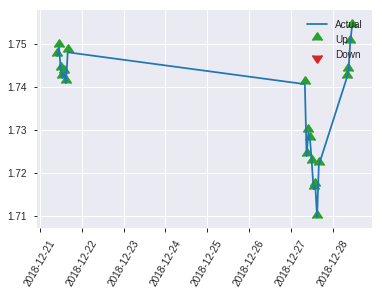


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2510205160624274
RMSE: 0.5010194767296252
LogLoss: 0.6951894780402491
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.18865009111494
Residual deviance: 305.8833703377096
AIC: 407.8833703377096
AUC: 0.45233366434955313
pr_auc: 0.4470072171474433
Gini: -0.09533267130089373
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46281686367120517: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    106  0        (0.0/106.0)
Total  0    220  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462817     0.650307  219
max f2                       0.462817     0.822981  219
max f0point5                 0.462817     0.537525  219
max accuracy                 0.516019     0.518182  5
max precision                0.516019     0.5       5
max recall                   0.462817     1         219
max specificity              0.527636     0.991228  0
max absolute_mcc             0.5005       0.132394  188
max min_per_class_accuracy   0.506905     0.462264  107
max mean_per_class_accuracy  0.505318     0.504965  139

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.521268           0         0                  0                0.524092  0                           0.524092            0               0                          -100      -100
    2        0.0227273                   0.517066           2.07547   0.830189           1                0.518009  0.4                         0.521659            0.0188679       0.0188679                  107.547   -16.9811
    3        0.0318182                   0.515949           1.03774   0.889488           0.5              0.515991  0.428571                    0.520039            0.00943396      0.0283019                  3.77358   -11.0512
    4        0.0409091                   0.515352           1.03774   0.922432           0.5              0.515758  0.444444                    0.519088            0.00943396      0.0377358                  3.77358   -7.75681
    5        0.05                        0.514636           1.03774   0.943396           0.5              0.515256  0.454545                    0.518391            0.00943396      0.0471698                  3.77358   -5.66038
    6        0.1                         0.512794           0.943396  0.943396           0.454545         0.513458  0.454545                    0.515925            0.0471698       0.0943396                  -5.66038  -5.66038
    7        0.15                        0.511694           0.754717  0.880503           0.363636         0.512408  0.424242                    0.514753            0.0377358       0.132075                   -24.5283  -11.9497
    8        0.2                         0.510478           1.13208   0.943396           0.545455         0.511108  0.454545                    0.513841            0.0566038       0.188679                   13.2075   -5.66038
    9        0.3                         0.509299           0.849057  0.91195            0.409091         0.509762  0.439394                    0.512481            0.0849057       0.273585                   -15.0943  -8.80503
    10       0.4                         0.507981           0.754717  0.872642           0.363636         0.508635  0.420455                    0.51152             0.0754717       0.349057                   -24.5283  -12.7358
    11       0.5                         0.506826           1.13208   0.924528           0.545455         0.507447  0.445455                    0.510705            0.113208        0.462264                   13.2075   -7.54717
    12       0.6                         0.505599           1.13208   0.959119           0.545455         0.506199  0.462121                    0.509954            0.113208        0.575472                   13.2075   -4.08805
    13       0.7                         0.504443           1.13208   0.983827           0.545455         0.505075  0.474026                    0.509257            0.113208        0.688679                   13.2075   -1.61725
    14       0.8                         0.502571           0.849057  0.966981           0.409091         0.50353   0.465909                    0.508541            0.0849057       0.773585                   -15.0943  -3.30189
    15       0.9                         0.498698           1.03774   0.974843           0.5              0.500654  0.469697                    0.507665            0.103774        0.877358                   3.77358   -2.51572
    16       1                           0.462817           1.22642   1                  0.590909         0.489514  0.481818                    0.5058

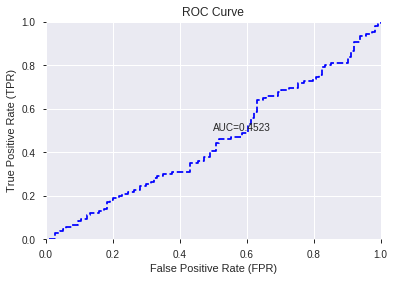

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


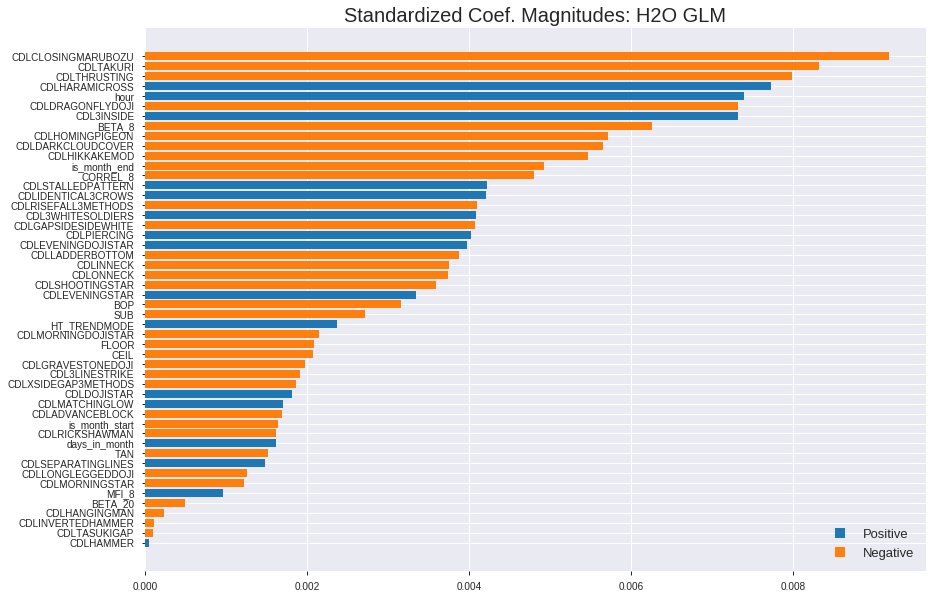

'log_likelihood'
--2019-08-28 13:10:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_131039_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_131039_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'CDLTHRUSTING',
 'CDLHARAMICROSS',
 'hour',
 'CDLDRAGONFLYDOJI',
 'CDL3INSIDE',
 'BETA_8',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'is_month_end',
 'CORREL_8',
 'CDLSTALLEDPATTERN',
 'CDLIDENTICAL3CROWS',
 'CDLRISEFALL3METHODS',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'CDLONNECK',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGSTAR',
 'BOP',
 'SUB',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'FLOOR',
 'CEIL',
 'CDLGRAVESTONEDOJI',
 'CDL3LINESTRIKE',
 'CDLXSIDEGAP3METHODS',
 'CDLDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'TAN',
 'CDLSEPARATINGLINES',
 'CDLLONGLEGGEDDOJI',
 'CDLMORNINGSTAR',
 'MFI_8',
 'BETA_20',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLTASUKIGAP',
 'CDLHAMMER']

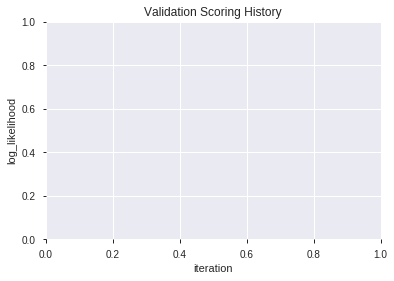

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_131052_model_7  0.490483  0.716622              0.491559  0.511191  0.261316
1  XGBoost_grid_1_AutoML_20190828_131052_model_1  0.467519  0.711223              0.500000  0.508762  0.258838
2  XGBoost_grid_1_AutoML_20190828_131052_model_5  0.453740  0.747578              0.482787  0.524875  0.275494
3               XGBoost_1_AutoML_20190828_131052  0.450761  0.723205              0.500000  0.514390  0.264597
4               XGBoost_3_AutoML_20190828_131052  0.449189  0.719398              0.500000  0.512678  0.262839
5  XGBoost_grid_1_AutoML_20190828_131052_model_2  0.442072  0.711631              0.500000  0.509048  0.259130
6  XGBoost_grid_1_AutoML_20190828_131052_model_4  0.439341  0.714561              0.500000  0.510433  0.260542
7               XGBoost_2_AutoML_20190828_131052  0.431314  0.730644              0.500000  0.517724  0.268038
8  XGBoost_grid_1_AutoML_20190828_131052_model_3  0.418736  0.725639              0.500000  0.515639  0.265884
9  XGBoost_grid_1_AutoML_20190828_131052_model_6  0.416336  0.728985              0.500000  0.517198  0.267494

variable  relative_importance  scaled_importance  percentage
0              BETA_20           821.531128           1.000000    0.150138
1                  TAN           803.579407           0.978148    0.146858
2             CORREL_8           731.890869           0.890886    0.133756
3                MFI_8           710.356628           0.864674    0.129821
4                  BOP           689.544678           0.839341    0.126017
5               BETA_8           590.479858           0.718755    0.107913
6                  SUB           539.366089           0.656538    0.098572
7                 hour           338.829834           0.412437    0.061923
8         HT_TRENDMODE            86.428406           0.105204    0.015795
9   CDLCLOSINGMARUBOZU            66.592751           0.081059    0.012170
10       days_in_month            65.276520           0.079457    0.011930
11   CDLLONGLEGGEDDOJI            10.215055           0.012434    0.001867
12                CEIL             6.958487           0.008470    0.001272
13        is_month_end             6.624173           0.008063    0.001211
14      CDLRICKSHAWMAN             4.149872           0.005051    0.000758

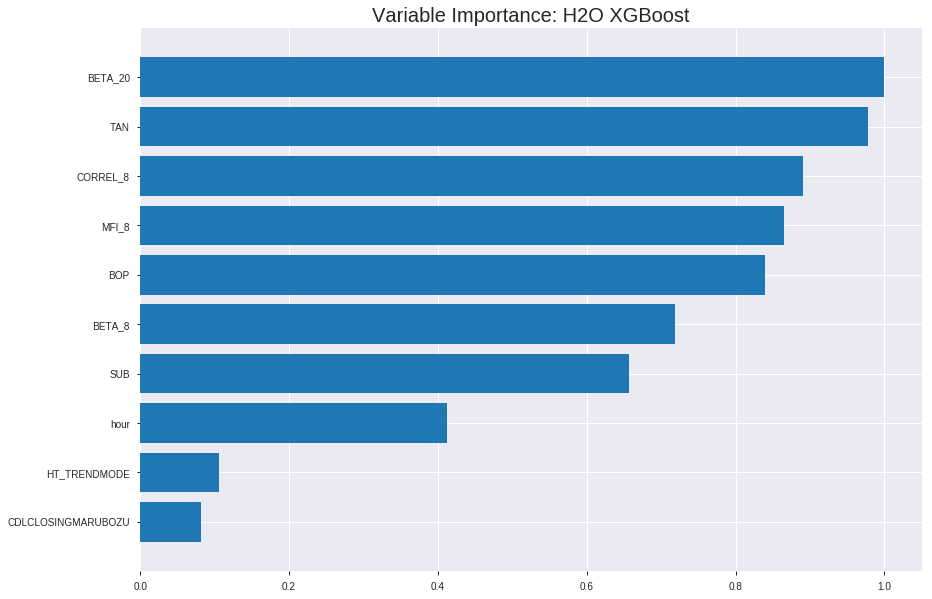

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_131052_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17556299121200222
RMSE: 0.4190023761412365
LogLoss: 0.5390405695585846
Mean Per-Class Error: 0.1476436022488654
AUC: 0.926870385423017
pr_auc: 0.9275538722735942
Gini: 0.8537407708460341
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49886758128801983: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      639  121  0.1592   (121.0/760.0)
1      108  669  0.139    (108.0/777.0)
Total  747  790  0.149    (229.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498868     0.853861  198
max f2                       0.438704     0.903163  251
max f0point5                 0.544243     0.865355  157
max accuracy                 0.50373      0.85231   193
max precision                0.774068     1         0
max recall                   0.344332     1         332
max specificity              0.774068     1         0
max absolute_mcc             0.50373      0.70467   193
max min_per_class_accuracy   0.501281     0.850708  195
max mean_per_class_accuracy  0.50373      0.852356  193

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.75365            1.97812    1.97812            1                0.763869  1                           0.763869            0.020592        0.020592                   97.8121   97.8121
    2        0.0201692                   0.737513           1.97812    1.97812            1                0.74595   1                           0.755199            0.019305        0.039897                   97.8121   97.8121
    3        0.0305791                   0.713948           1.97812    1.97812            1                0.726329  1                           0.745371            0.020592        0.0604891                  97.8121   97.8121
    4        0.0403383                   0.703575           1.97812    1.97812            1                0.707431  1                           0.736192            0.019305        0.0797941                  97.8121   97.8121
    5        0.0500976                   0.695224           1.97812    1.97812            1                0.698577  1                           0.728864            0.019305        0.0990991                  97.8121   97.8121
    6        0.100195                    0.668514           1.92674    1.95243            0.974026         0.681509  0.987013                    0.705187            0.0965251       0.195624                   92.6741   95.2431
    7        0.150293                    0.643953           1.95243    1.95243            0.987013         0.655966  0.987013                    0.68878             0.0978121       0.293436                   95.2431   95.2431
    8        0.20039                     0.622835           1.92674    1.94601            0.974026         0.63306   0.983766                    0.67485             0.0965251       0.389961                   92.6741   94.6009
    9        0.299935                    0.581871           1.8359     1.90947            0.928105         0.601232  0.965293                    0.650417            0.182754        0.572716                   83.5903   90.9466
    10       0.40013                     0.541189           1.45148    1.79478            0.733766         0.561938  0.907317                    0.628261            0.145431        0.718147                   45.1478   79.4783
    11       0.500325                    0.503185           1.29734    1.69516            0.655844         0.520708  0.856957                    0.606723            0.129987        0.848134                   29.7339   69.5165
    12       0.59987                     0.464696           0.672303   1.52543            0.339869         0.482867  0.77115                     0.58617             0.0669241       0.915058                   -32.7697  52.5427
    13       0.700065                    0.428289           0.513798   1.38064            0.25974          0.44651   0.697955                    0.566181            0.0514801       0.966538                   -48.6202  38.064
    14       0.79961                     0.388366           0.271507   1.24256            0.137255         0.408445  0.628153                    0.546544            0.027027        0.993565                   -72.8493  24.2563
    15       0.899805                    0.335277           0.0642247  1.11135            0.0324675        0.361679  0.561822                    0.525959            0.00643501      1                          -93.5775  11.1352
    16       1                           0.218813           0          1                  0                0.296631  0.50553                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26407813368900596
RMSE: 0.5138853312646762
LogLoss: 0.7227164713318867
Mean Per-Class Error: 0.4857094962702204
AUC: 0.47068560891794486
pr_auc: 0.5371027898959626
Gini: -0.05862878216411027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2557278573513031: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255728     0.717201  399
max f2                       0.255728     0.863764  399
max f0point5                 0.255728     0.613161  399
max accuracy                 0.295144     0.559091  395
max precision                0.740621     1         0
max recall                   0.255728     1         399
max specificity              0.740621     1         0
max absolute_mcc             0.680597     0.120934  13
max min_per_class_accuracy   0.508101     0.469072  201
max mean_per_class_accuracy  0.618463     0.514291  59

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.723614           1.07317   1.07317            0.6              0.73052   0.6                         0.73052             0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.697336           0.447154  0.794941           0.25             0.713572  0.444444                    0.722987            0.00406504      0.0162602                  -55.2846  -20.5059
    3        0.0318182                   0.688206           0         0.511034           0                0.693501  0.285714                    0.712456            0               0.0162602                  -100      -48.8966
    4        0.0409091                   0.673922           0.894309  0.596206           0.5              0.678635  0.333333                    0.704941            0.00813008      0.0243902                  -10.5691  -40.3794
    5        0.05                        0.664035           1.34146   0.731707           0.75             0.669856  0.409091                    0.698562            0.0121951       0.0365854                  34.1463   -26.8293
    6        0.1                         0.634157           1.38211   1.05691            0.772727         0.650047  0.590909                    0.674304            0.0691057       0.105691                   38.2114   5.69106
    7        0.15                        0.616924           1.13821   1.08401            0.636364         0.62624   0.606061                    0.658283            0.0569106       0.162602                   13.8211   8.40108
    8        0.2                         0.593661           0.731707  0.995935           0.409091         0.605675  0.556818                    0.645131            0.0365854       0.199187                   -26.8293  -0.406504
    9        0.3                         0.562339           0.772358  0.921409           0.431818         0.577549  0.515152                    0.622603            0.0772358       0.276423                   -22.7642  -7.85908
    10       0.4                         0.529395           1.05691   0.955285           0.590909         0.543288  0.534091                    0.602775            0.105691        0.382114                   5.69106   -4.47154
    11       0.5                         0.50791            0.894309  0.943089           0.5              0.518042  0.527273                    0.585828            0.0894309       0.471545                   -10.5691  -5.69106
    12       0.6                         0.483216           1.05691   0.96206            0.590909         0.495447  0.537879                    0.570765            0.105691        0.577236                   5.69106   -3.79404
    13       0.7                         0.453043           1.17886   0.993031           0.659091         0.469317  0.555195                    0.556272            0.117886        0.695122                   17.8862   -0.696864
    14       0.8                         0.415952           0.894309  0.980691           0.5              0.43561   0.548295                    0.541189            0.0894309       0.784553                   -10.5691  -1.93089
    15       0.9                         0.372191           1.01626   0.984643           0.568182         0.397181  0.550505                    0.525188            0.101626        0.886179                   1.62602   -1.53568
    16       1                           0.255728           1.13821   1                  0.636364         0.334873  0.559091                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:11:06  8.615 sec   0                  0.5              0.693147            0.5             0                  1                0.49447                          0.5                0.693147              0.5               0                    1                  0.440909
    2019-08-28 13:11:06  8.714 sec   5                  0.489582         0.672488            0.751807        0.740385           1.73086          0.332466                         0.501015           0.695185              0.477338          0.536814             0.357724           0.434091
    2019-08-28 13:11:06  8.798 sec   10                 0.480126         0.654001            0.805765        0.808853           1.97812          0.297983                         0.501877           0.696923              0.485102          0.544607             0.357724           0.434091
    2019-08-28 13:11:06  8.898 sec   15                 0.470962         0.636295            0.83998         0.844463           1.97812          0.258295                         0.504787           0.702827              0.458815          0.531575             1.07317            0.438636
    2019-08-28 13:11:06  8.990 sec   20                 0.463405         0.621785            0.853634        0.857899           1.97812          0.258295                         0.505093           0.703496              0.469963          0.555893             1.43089            0.438636
    2019-08-28 13:11:06  9.096 sec   25                 0.453801         0.603561            0.873891        0.87726            1.97812          0.211451                         0.506557           0.7065                0.466935          0.547234             1.43089            0.438636
    2019-08-28 13:11:06  9.192 sec   30                 0.445927         0.588756            0.890972        0.892866           1.97812          0.192583                         0.507195           0.707912              0.476144          0.541632             1.07317            0.438636
    2019-08-28 13:11:06  9.314 sec   35                 0.437568         0.573189            0.904462        0.905406           1.97812          0.184776                         0.508138           0.709961              0.475254          0.543859             1.07317            0.438636
    2019-08-28 13:11:06  9.425 sec   40                 0.430254         0.559713            0.915531        0.915751           1.97812          0.167209                         0.509949           0.713978              0.474153          0.537692             0.715447           0.440909
    2019-08-28 13:11:06  9.530 sec   45                 0.42423          0.548534            0.919051        0.920726           1.97812          0.167209                         0.511863           0.718217              0.472655          0.53461              0.715447           0.440909
    2019-08-28 13:11:07  9.628 sec   50                 0.419002         0.539041            0.92687         0.927554           1.97812          0.148992                         0.513885           0.722716              0.470686          0.537103             1.07317            0.440909

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BETA_20             821.531                1                    0.150138
TAN                 803.579                0.978148             0.146858
CORREL_8            731.891                0.890886             0.133756
MFI_8               710.357                0.864674             0.129821
BOP                 689.545                0.839341             0.126017
BETA_8              590.48                 0.718755             0.107913
SUB                 539.366                0.656538             0.0985715
hour                338.83                 0.412437             0.0619227
HT_TRENDMODE        86.4284                0.105204             0.0157952
CDLCLOSINGMARUBOZU  66.5928                0.0810593            0.0121701
days_in_month       65.2765                0.0794571            0.0119296
CDLLONGLEGGEDDOJI   10.2151                0.0124342            0.00186685
CEIL                6.95849                0.00847014           0.00127169
is_month_end        6.62417                0.0080632            0.0012106
CDLRICKSHAWMAN      4.14987                0.00505139           0.000758408

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.6521739130434783)

('auc', 0.4904832836809004)

('logloss', 0.716622033915633)

('mean_per_class_error', 0.4556438265475008)

('rmse', 0.5111910153236081)

('mse', 0.2613162541475813)

xgboost prediction progress: |████████████████████████████████████████████| 100%


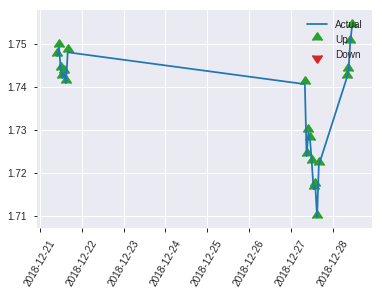


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2613162541475813
RMSE: 0.5111910153236081
LogLoss: 0.716622033915633
Mean Per-Class Error: 0.4556438265475008
AUC: 0.4904832836809004
pr_auc: 0.48963806048222586
Gini: -0.019033432638199232
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30424922704696655: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    111  0.9737   (111.0/114.0)
1      1    105  0.0094   (1.0/106.0)
Total  4    216  0.5091   (112.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304249     0.652174  215
max f2                       0.267645     0.822981  219
max f0point5                 0.304249     0.541237  215
max accuracy                 0.593912     0.554545  45
max precision                0.762232     1         0
max recall                   0.267645     1         219
max specificity              0.762232     1         0
max absolute_mcc             0.422164     0.124082  180
max min_per_class_accuracy   0.523023     0.481132  107
max mean_per_class_accuracy  0.590389     0.544356  47

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.723235           1.38365   1.38365            0.666667         0.744799  0.666667                    0.744799            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.692132           0         0.830189           0                0.696665  0.4                         0.725545            0               0.0188679                  -100      -16.9811
    3        0.0318182                   0.674344           2.07547   1.18598            1                0.684248  0.571429                    0.713746            0.0188679       0.0377358                  107.547   18.5984
    4        0.0409091                   0.667441           0         0.922432           0                0.669844  0.444444                    0.70399             0               0.0377358                  -100      -7.75681
    5        0.05                        0.658077           2.07547   1.13208            1                0.664462  0.545455                    0.696803            0.0188679       0.0566038                  107.547   13.2075
    6        0.1                         0.630107           0.943396  1.03774            0.454545         0.640628  0.5                         0.668716            0.0471698       0.103774                   -5.66038  3.77358
    7        0.15                        0.610296           1.13208   1.06918            0.545455         0.6201    0.515152                    0.65251             0.0566038       0.160377                   13.2075   6.91824
    8        0.2                         0.595551           1.50943   1.17925            0.727273         0.604973  0.568182                    0.640626            0.0754717       0.235849                   50.9434   17.9245
    9        0.3                         0.572098           0.660377  1.00629            0.318182         0.583485  0.484848                    0.621579            0.0660377       0.301887                   -33.9623  0.628931
    10       0.4                         0.544573           1.13208   1.03774            0.545455         0.556542  0.5                         0.60532             0.113208        0.415094                   13.2075   3.77358
    11       0.5                         0.519798           0.660377  0.962264           0.318182         0.531352  0.463636                    0.590526            0.0660377       0.481132                   -33.9623  -3.77358
    12       0.6                         0.496857           0.943396  0.959119           0.454545         0.508693  0.462121                    0.576887            0.0943396       0.575472                   -5.66038  -4.08805
    13       0.7                         0.47029            1.13208   0.983827           0.545455         0.486936  0.474026                    0.564037            0.113208        0.688679                   13.2075   -1.61725
    14       0.8                         0.433727           0.754717  0.955189           0.363636         0.452212  0.460227                    0.550059            0.0754717       0.764151                   -24.5283  -4.48113
    15       0.9                         0.390387           1.22642   0.985325           0.590909         0.410523  0.474747                    0.534555            0.122642        0.886792                   22.6415   -1.46751
    16       1                           0.267645           1.13208   1                  0.545455         0.342868  0.481818                    0.515386 

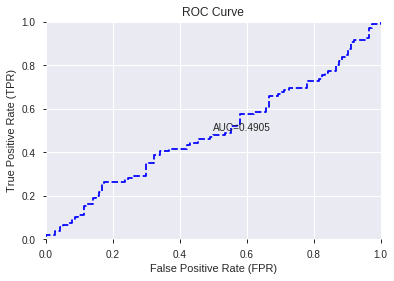

This function is available for GLM models only


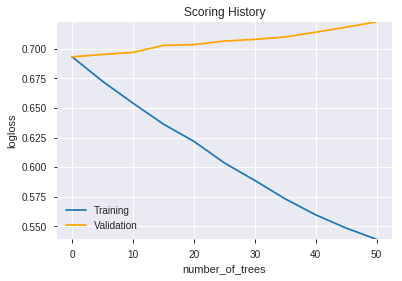

--2019-08-28 13:11:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_131052_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_131052_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BETA_20',
 'TAN',
 'CORREL_8',
 'MFI_8',
 'BOP',
 'BETA_8',
 'SUB',
 'hour',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'CEIL',
 'is_month_end',
 'CDLRICKSHAWMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_131118_model_1  0.543942  0.691963              0.495614  0.499408  0.249408

variable  relative_importance  scaled_importance    percentage
0                  CDLLONGLINE         8.588525e-03           1.000000  1.362339e-02
1                    CDLTAKURI         7.232433e-03           0.842104  1.147231e-02
2           CDLCLOSINGMARUBOZU         7.202392e-03           0.838606  1.142466e-02
3                 CDLTHRUSTING         6.767809e-03           0.788006  1.073531e-02
4                   CDL3INSIDE         6.468328e-03           0.753136  1.026026e-02
...                        ...                  ...                ...           ...
1033                     ADX_8         1.388229e-07           0.000016  2.202052e-07
1034                   MA_12_6         1.188331e-07           0.000014  1.884967e-07
1035  BBANDS_middleband_12_6_5         0.000000e+00           0.000000  0.000000e+00
1036  BBANDS_middleband_12_7_5         0.000000e+00           0.000000  0.000000e+00
1037   BBANDS_lowerband_14_0_3         0.000000e+00           0.000000  0.000000e+00

[1038 rows x 4 columns]

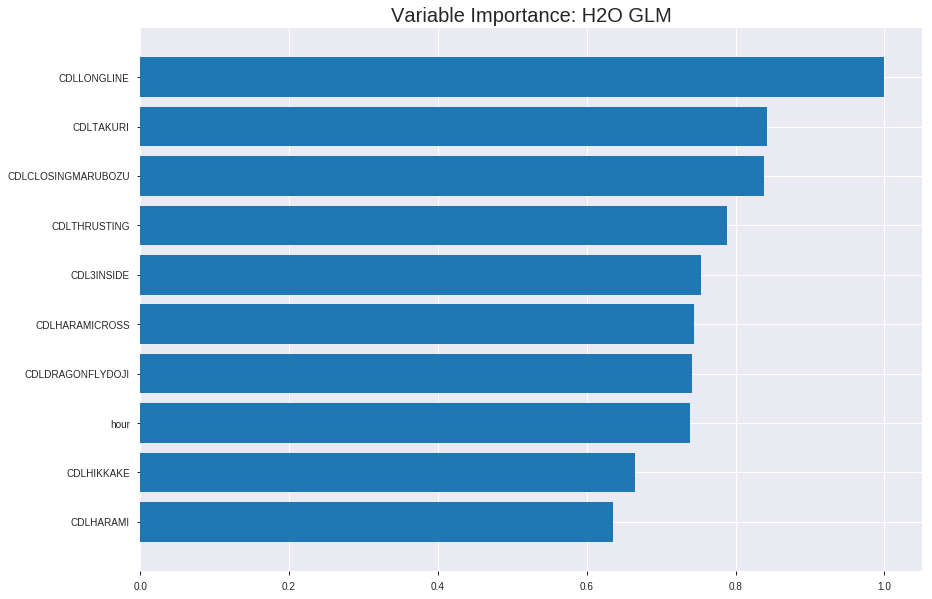

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_131118_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24713681995900721
RMSE: 0.49712857487676887
LogLoss: 0.6874132026161583
Null degrees of freedom: 1536
Residual degrees of freedom: 501
Null deviance: 2130.5464005801423
Residual deviance: 2113.108184842071
AIC: 4185.108184842071
AUC: 0.6020388809862495
pr_auc: 0.5921192597542836
Gini: 0.20407776197249894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4874097559545418: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      127  633   0.8329   (633.0/760.0)
1      49   728   0.0631   (49.0/777.0)
Total  176  1361  0.4437   (682.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48741      0.68101   311
max f2                       0.464918     0.838382  378
max f0point5                 0.495439     0.594685  263
max accuracy                 0.495439     0.578399  263
max precision                0.570383     1         0
max recall                   0.458578     1         390
max specificity              0.570383     1         0
max absolute_mcc             0.490209     0.174932  295
max min_per_class_accuracy   0.506062     0.56242   188
max mean_per_class_accuracy  0.500834     0.576179  228

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.541811           1.60722   1.60722            0.8125           0.548365  0.8125                      0.548365            0.016731        0.016731                   60.7223   60.7223
    2        0.0201692                   0.536484           1.055     1.34002            0.533333         0.539101  0.677419                    0.543883            0.010296        0.027027                   5.49979   34.0017
    3        0.0305791                   0.534486           1.60722   1.43098            0.8125           0.535609  0.723404                    0.541066            0.016731        0.043758                   60.7223   43.0981
    4        0.0403383                   0.531417           1.45062   1.43573            0.733333         0.532863  0.725806                    0.539081            0.014157        0.0579151                  45.0622   43.5733
    5        0.0500976                   0.530721           1.18687   1.38725            0.6              0.531017  0.701299                    0.53751             0.011583        0.0694981                  18.6873   38.7254
    6        0.100195                    0.52583            1.15604   1.27165            0.584416         0.527966  0.642857                    0.532738            0.0579151       0.127413                   15.6045   27.1649
    7        0.150293                    0.521641           1.20742   1.25024            0.61039          0.523678  0.632035                    0.529718            0.0604891       0.187902                   20.7424   25.0241
    8        0.20039                     0.518153           1.07898   1.20742            0.545455         0.519934  0.61039                     0.527272            0.0540541       0.241956                   7.89751   20.7424
    9        0.299935                    0.513581           1.11188   1.17572            0.562092         0.515843  0.59436                     0.523479            0.110682        0.352638                   11.1885   17.5716
    10       0.40013                     0.50999            1.07898   1.15149            0.545455         0.511881  0.582114                    0.520575            0.108108        0.460746                   7.89751   15.1492
    11       0.500325                    0.50593            1.0276    1.12668            0.519481         0.508206  0.569571                    0.518098            0.10296         0.563707                   2.75953   12.668
    12       0.59987                     0.502288           1.0731    1.11779            0.542484         0.504096  0.565076                    0.515774            0.106821        0.670528                   7.30983   11.7789
    13       0.700065                    0.498094           0.98906   1.09936            0.5              0.500332  0.555762                    0.513564            0.0990991       0.769627                   -1.09395  9.93646
    14       0.79961                     0.49295            0.917952  1.07678            0.464052         0.495409  0.544345                    0.511304            0.0913771       0.861004                   -8.20484  7.67803
    15       0.899805                    0.485361           0.847766  1.05128            0.428571         0.489805  0.531453                    0.50891             0.0849421       0.945946                   -15.2234  5.1279
    16       1                           0.438585           0.539488  1                  0.272727         0.475178  0.50553                     0.50553            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24922413209111804
RMSE: 0.4992235291841902
LogLoss: 0.691596374286049
Null degrees of freedom: 439
Residual degrees of freedom: -596
Null deviance: 608.8730098202949
Residual deviance: 608.604809371723
AIC: 2680.604809371723
AUC: 0.5328555862878216
pr_auc: 0.5684802363301438
Gini: 0.06571117257564318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44420414603039526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444204     0.717201  399
max f2                       0.444204     0.863764  399
max f0point5                 0.485457     0.624257  320
max accuracy                 0.485738     0.579545  319
max precision                0.52315      0.606061  29
max recall                   0.444204     1         399
max specificity              0.551958     0.994845  0
max absolute_mcc             0.485738     0.11004   319
max min_per_class_accuracy   0.502972     0.525773  201
max mean_per_class_accuracy  0.491633     0.544485  285

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.53396            1.07317   1.07317            0.6              0.541376  0.6                         0.541376            0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.53209            0.447154  0.794941           0.25             0.532674  0.444444                    0.537509            0.00406504      0.0162602                  -55.2846  -20.5059
    3        0.0318182                   0.528006           0.357724  0.638792           0.2              0.53033   0.357143                    0.534945            0.00406504      0.0203252                  -64.2276  -36.1208
    4        0.0409091                   0.52671            1.34146   0.794941           0.75             0.527066  0.444444                    0.533194            0.0121951       0.0325203                  34.1463   -20.5059
    5        0.05                        0.525186           1.78862   0.97561            1                0.525958  0.545455                    0.531878            0.0162602       0.0487805                  78.8618   -2.43902
    6        0.1                         0.521239           1.13821   1.05691            0.636364         0.523239  0.590909                    0.527558            0.0569106       0.105691                   13.8211   5.69106
    7        0.15                        0.517811           0.894309  1.00271            0.5              0.519688  0.560606                    0.524935            0.0447154       0.150407                   -10.5691  0.271003
    8        0.2                         0.515501           1.13821   1.03659            0.636364         0.516412  0.579545                    0.522804            0.0569106       0.207317                   13.8211   3.65854
    9        0.3                         0.510908           0.853659  0.97561            0.477273         0.513336  0.545455                    0.519648            0.0853659       0.292683                   -14.6341  -2.43902
    10       0.4                         0.507791           1.26016   1.04675            0.704545         0.509488  0.585227                    0.517108            0.126016        0.418699                   26.0163   4.6748
    11       0.5                         0.503174           1.01626   1.04065            0.568182         0.505319  0.581818                    0.51475             0.101626        0.520325                   1.62602   4.06504
    12       0.6                         0.498584           1.01626   1.03659            0.568182         0.500772  0.579545                    0.512421            0.101626        0.621951                   1.62602   3.65854
    13       0.7                         0.493615           1.13821   1.0511             0.636364         0.496304  0.587662                    0.510118            0.113821        0.735772                   13.8211   5.11034
    14       0.8                         0.486345           0.934959  1.03659            0.522727         0.49023   0.579545                    0.507632            0.0934959       0.829268                   -6.50407  3.65854
    15       0.9                         0.477809           0.853659  1.01626            0.477273         0.48302   0.568182                    0.504898            0.0853659       0.914634                   -14.6341  1.62602
    16       1                           0.444204           0.853659  1                  0.477273         0.467542  0.559091                    0.501162    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:11:21  0.000 sec   2            3.4       1036          1.37483           1.38319
    2019-08-28 13:11:23  2.023 sec   4            2.4       1037          1.37166           1.38412
    2019-08-28 13:11:25  4.023 sec   6            1.8       1037          1.36781           1.38587
    2019-08-28 13:11:27  6.063 sec   8            1.3       1038          1.36327           1.38853
    2019-08-28 13:11:29  8.060 sec   10           0.94      1039          1.35803           1.3923
    2019-08-28 13:11:31  10.058 sec  12           0.69      1039          1.35218           1.39744

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5590909090909091)

('F1', 0.6523076923076924)

('auc', 0.5439424031777558)

('logloss', 0.6919628931013033)

('mean_per_class_error', 0.4409963588215823)

('rmse', 0.49940798823195126)

('mse', 0.24940833870988477)

glm prediction progress: |████████████████████████████████████████████████| 100%


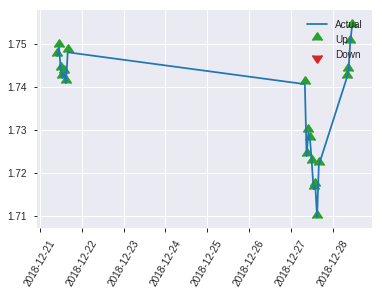


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24940833870988477
RMSE: 0.49940798823195126
LogLoss: 0.6919628931013033
Null degrees of freedom: 219
Residual degrees of freedom: -816
Null deviance: 305.18865009111494
Residual deviance: 304.4636729645735
AIC: 2376.4636729645736
AUC: 0.5439424031777558
pr_auc: 0.5130876335875655
Gini: 0.08788480635551155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4472975928555237: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    113  0.9912   (113.0/114.0)
1      0    106  0        (0.0/106.0)
Total  1    219  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447298     0.652308  218
max f2                       0.447298     0.824261  218
max f0point5                 0.501229     0.548048  139
max accuracy                 0.505109     0.559091  108
max precision                0.522877     0.611111  17
max recall                   0.447298     1         218
max specificity              0.544602     0.991228  0
max absolute_mcc             0.505109     0.117934  108
max min_per_class_accuracy   0.505109     0.556604  108
max mean_per_class_accuracy  0.505109     0.559004  108

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.536103           0.691824  0.691824           0.333333         0.539861  0.333333                    0.539861            0.00943396      0.00943396                 -30.8176  -30.8176
    2        0.0227273                   0.533251           2.07547   1.24528            1                0.534237  0.6                         0.537611            0.0188679       0.0283019                  107.547   24.5283
    3        0.0318182                   0.530536           1.03774   1.18598            0.5              0.532117  0.571429                    0.536041            0.00943396      0.0377358                  3.77358   18.5984
    4        0.0409091                   0.528388           1.03774   1.15304            0.5              0.529641  0.555556                    0.534619            0.00943396      0.0471698                  3.77358   15.304
    5        0.05                        0.527225           1.03774   1.13208            0.5              0.528011  0.545455                    0.533418            0.00943396      0.0566038                  3.77358   13.2075
    6        0.1                         0.521517           1.13208   1.13208            0.545455         0.523569  0.545455                    0.528493            0.0566038       0.113208                   13.2075   13.2075
    7        0.15                        0.517349           1.13208   1.13208            0.545455         0.519329  0.545455                    0.525439            0.0566038       0.169811                   13.2075   13.2075
    8        0.2                         0.515744           1.13208   1.13208            0.545455         0.51645   0.545455                    0.523191            0.0566038       0.226415                   13.2075   13.2075
    9        0.3                         0.511703           0.943396  1.06918            0.454545         0.513892  0.515152                    0.520091            0.0943396       0.320755                   -5.66038  6.91824
    10       0.4                         0.507912           1.22642   1.10849            0.590909         0.510084  0.534091                    0.51759             0.122642        0.443396                   22.6415   10.8491
    11       0.5                         0.505046           1.13208   1.11321            0.545455         0.506104  0.536364                    0.515292            0.113208        0.556604                   13.2075   11.3208
    12       0.6                         0.502396           0.849057  1.06918            0.409091         0.503702  0.515152                    0.513361            0.0849057       0.641509                   -15.0943  6.91824
    13       0.7                         0.499184           0.754717  1.02426            0.363636         0.500799  0.493506                    0.511566            0.0754717       0.716981                   -24.5283  2.42588
    14       0.8                         0.494698           1.03774   1.02594            0.5              0.497351  0.494318                    0.509789            0.103774        0.820755                   3.77358   2.59434
    15       0.9                         0.482682           0.849057  1.00629            0.409091         0.48961   0.484848                    0.507547            0.0849057       0.90566                    -15.0943  0.628931
    16       1                           0.447296           0.943396  1                  0.454545         0.468506  0.481818                    0.503643        

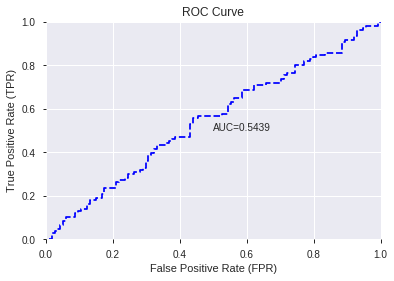

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


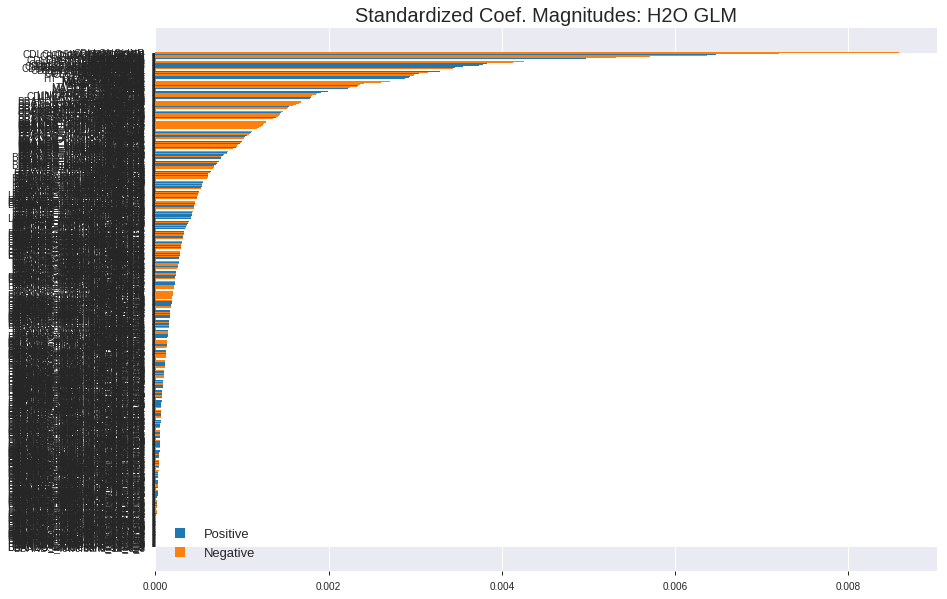

'log_likelihood'
--2019-08-28 13:11:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_131118_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_131118_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

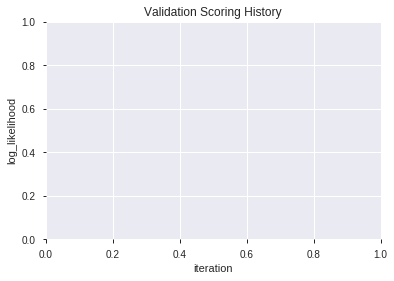

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_131203_model_7  0.541377  0.706171              0.495614  0.506018  0.256054
1               XGBoost_1_AutoML_20190828_131203  0.520275  0.714845              0.475008  0.509911  0.260009
2               XGBoost_3_AutoML_20190828_131203  0.519944  0.708213              0.487173  0.506979  0.257028
3  XGBoost_grid_1_AutoML_20190828_131203_model_6  0.510965  0.728916              0.495614  0.515494  0.265734
4               XGBoost_2_AutoML_20190828_131203  0.492469  0.716190              0.495614  0.510719  0.260834
5  XGBoost_grid_1_AutoML_20190828_131203_model_5  0.486842  0.757645              0.500000  0.527833  0.278608
6  XGBoost_grid_1_AutoML_20190828_131203_model_1  0.478815  0.710229              0.491228  0.508186  0.258253
7  XGBoost_grid_1_AutoML_20190828_131203_model_2  0.477160  0.709578              0.500000  0.507973  0.258037
8  XGBoost_grid_1_AutoML_20190828_131203_model_3  0.466733  0.728374              0.495614  0.516138  0.266399
9  XGBoost_grid_1_AutoML_20190828_131203_model_4  0.462678  0.714054              0.500000  0.510102  0.260204

variable  relative_importance  scaled_importance  percentage
0                        BOP           115.716515           1.000000    0.013467
1                   WILLR_12           106.510223           0.920441    0.012395
2          HT_PHASOR_inphase           100.965485           0.872524    0.011750
3                        DIV           100.581116           0.869203    0.011705
4             STOCHRSI_fastk            97.441010           0.842067    0.011340
..                       ...                  ...                ...         ...
375  BBANDS_upperband_20_5_5             1.549171           0.013388    0.000180
376  BBANDS_upperband_12_6_4             1.317293           0.011384    0.000153
377  BBANDS_upperband_20_3_2             1.202048           0.010388    0.000140
378  BBANDS_upperband_20_5_4             1.051929           0.009091    0.000122
379                    month             0.101665           0.000879    0.000012

[380 rows x 4 columns]

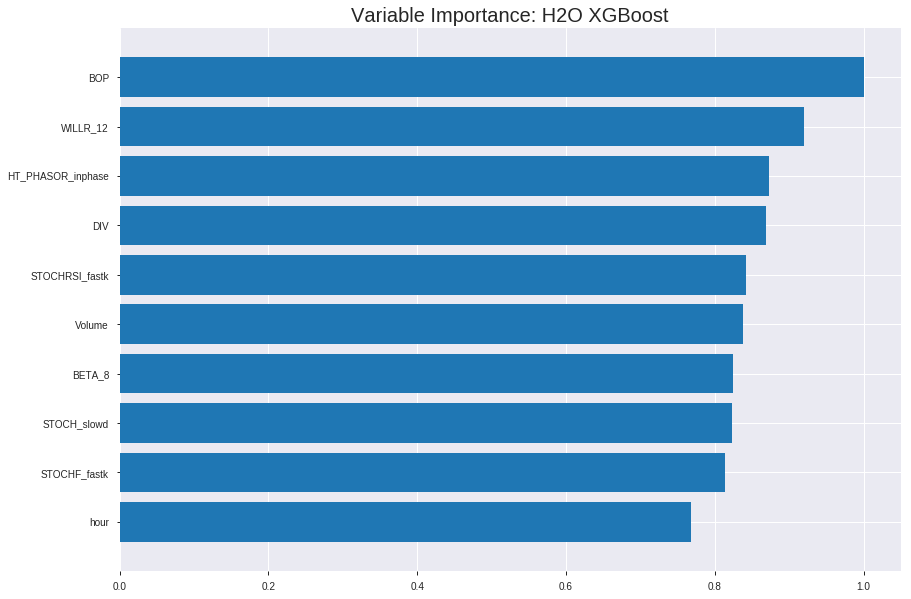

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_131203_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1325649069676646
RMSE: 0.36409464012487824
LogLoss: 0.4457597791890575
Mean Per-Class Error: 0.0514842850369166
AUC: 0.9890232337600758
pr_auc: 0.9879794002754172
Gini: 0.9780464675201517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.501488447189331: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      714  46   0.0605   (46.0/760.0)
1      33   744  0.0425   (33.0/777.0)
Total  747  790  0.0514   (79.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501488     0.949585  201
max f2                       0.483185     0.962859  211
max f0point5                 0.530753     0.955862  184
max accuracy                 0.50381      0.948601  200
max precision                0.879626     1         0
max recall                   0.377726     1         276
max specificity              0.879626     1         0
max absolute_mcc             0.501488     0.897299  201
max min_per_class_accuracy   0.508132     0.944659  197
max mean_per_class_accuracy  0.50381      0.948516  200

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.810235           1.97812    1.97812            1                0.83394   1                           0.83394             0.020592        0.020592                   97.8121   97.8121
    2        0.0201692                   0.792982           1.97812    1.97812            1                0.798938  1                           0.817003            0.019305        0.039897                   97.8121   97.8121
    3        0.0305791                   0.782307           1.97812    1.97812            1                0.787577  1                           0.806986            0.020592        0.0604891                  97.8121   97.8121
    4        0.0403383                   0.770416           1.97812    1.97812            1                0.774485  1                           0.799123            0.019305        0.0797941                  97.8121   97.8121
    5        0.0500976                   0.761665           1.97812    1.97812            1                0.76733   1                           0.792929            0.019305        0.0990991                  97.8121   97.8121
    6        0.100195                    0.7258             1.97812    1.97812            1                0.741269  1                           0.767099            0.0990991       0.198198                   97.8121   97.8121
    7        0.150293                    0.69685            1.97812    1.97812            1                0.710788  1                           0.748329            0.0990991       0.297297                   97.8121   97.8121
    8        0.20039                     0.675468           1.97812    1.97812            1                0.686017  1                           0.732751            0.0990991       0.396396                   97.8121   97.8121
    9        0.299935                    0.635477           1.96519    1.97383            0.993464         0.655423  0.997831                    0.707087            0.195624        0.592021                   96.5192   97.383
    10       0.40013                     0.585665           1.93959    1.96526            0.980519         0.610654  0.993496                    0.682939            0.194337        0.786358                   93.9586   96.5255
    11       0.500325                    0.510711           1.50286    1.87266            0.75974          0.548741  0.946684                    0.656065            0.150579        0.936937                   50.2858   87.2655
    12       0.59987                     0.436946           0.555942   1.65416            0.281046         0.471657  0.836226                    0.625463            0.0553411       0.992278                   -44.4058  65.4155
    13       0.700065                    0.376782           0.0770696  1.42844            0.038961         0.404468  0.722119                    0.593834            0.00772201      1                          -92.293   42.8439
    14       0.79961                     0.330144           0          1.25061            0                0.353789  0.632221                    0.56395             0               1                          -100      25.061
    15       0.899805                    0.282821           0          1.11135            0                0.307152  0.561822                    0.535355            0               1                          -100      11.1352
    16       1                           0.144698           0          1                  0                0.239833  0.50553                     0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2746695428610839
RMSE: 0.5240892508543596
LogLoss: 0.7455521771861873
Mean Per-Class Error: 0.48575140390579163
AUC: 0.4625869583438102
pr_auc: 0.5451725065552172
Gini: -0.07482608331237961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24236106872558594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    192  0.9897   (192.0/194.0)
1      1    245  0.0041   (1.0/246.0)
Total  3    437  0.4386   (193.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.242361     0.717423   396
max f2                       0.189589     0.863764   399
max f0point5                 0.242361     0.614343   396
max accuracy                 0.242361     0.561364   396
max precision                0.785547     1          0
max recall                   0.189589     1          399
max specificity              0.785547     1          0
max absolute_mcc             0.447723     0.0971419  221
max min_per_class_accuracy   0.46592      0.474227   200
max mean_per_class_accuracy  0.562313     0.514249   88

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 46.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.736741           1.43089   1.43089            0.8              0.759494  0.8                         0.759494            0.0162602       0.0162602                  43.0894   43.0894
    2        0.0204545                   0.70536            0.894309  1.19241            0.5              0.724721  0.666667                    0.74404             0.00813008      0.0243902                  -10.5691  19.2412
    3        0.0318182                   0.689002           0         0.766551           0                0.695988  0.428571                    0.726878            0               0.0243902                  -100      -23.3449
    4        0.0409091                   0.665809           0.894309  0.794941           0.5              0.675365  0.444444                    0.715431            0.00813008      0.0325203                  -10.5691  -20.5059
    5        0.05                        0.65127            1.78862   0.97561            1                0.662166  0.545455                    0.705746            0.0162602       0.0487805                  78.8618   -2.43902
    6        0.1                         0.61923            0.894309  0.934959           0.5              0.635969  0.522727                    0.670858            0.0447154       0.0934959                  -10.5691  -6.50407
    7        0.15                        0.597866           1.30081   1.05691            0.727273         0.606307  0.590909                    0.649341            0.0650407       0.158537                   30.0813   5.69106
    8        0.2                         0.571724           1.05691   1.05691            0.590909         0.582353  0.590909                    0.632594            0.0528455       0.211382                   5.69106   5.69106
    9        0.3                         0.534874           0.813008  0.97561            0.454545         0.554231  0.545455                    0.606473            0.0813008       0.292683                   -18.6992  -2.43902
    10       0.4                         0.499371           0.731707  0.914634           0.409091         0.517884  0.511364                    0.584326            0.0731707       0.365854                   -26.8293  -8.53659
    11       0.5                         0.464473           1.09756   0.95122            0.613636         0.480607  0.531818                    0.563582            0.109756        0.47561                    9.7561    -4.87805
    12       0.6                         0.431728           0.97561   0.955285           0.545455         0.449835  0.534091                    0.544624            0.097561        0.573171                   -2.43902  -4.47154
    13       0.7                         0.400504           0.97561   0.958188           0.545455         0.414472  0.535714                    0.526031            0.097561        0.670732                   -2.43902  -4.18118
    14       0.8                         0.361093           1.13821   0.980691           0.636364         0.38264   0.548295                    0.508107            0.113821        0.784553                   13.8211   -1.93089
    15       0.9                         0.317662           1.01626   0.984643           0.568182         0.338668  0.550505                    0.489281            0.101626        0.886179                   1.62602   -1.53568
    16       1                           0.189589           1.13821   1                  0.636364         0.282044  0.559091                    0.4685


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:12:49  29.640 sec  0                  0.5              0.693147            0.5             0                  1                0.49447                          0.5                0.693147              0.5               0                    1                  0.440909
    2019-08-28 13:12:51  30.760 sec  5                  0.481148         0.65603             0.837337        0.832295           1.97812          0.256344                         0.5049             0.70303               0.438836          0.524545             0.715447           0.440909
    2019-08-28 13:12:51  31.087 sec  10                 0.462795         0.620874            0.895075        0.888332           1.97812          0.182173                         0.507619           0.708675              0.43826           0.522728             0.715447           0.440909
    2019-08-28 13:12:51  31.406 sec  15                 0.449444         0.595751            0.917347        0.911033           1.97812          0.162004                         0.508869           0.711321              0.442838          0.524827             1.07317            0.440909
    2019-08-28 13:12:52  31.769 sec  20                 0.436455         0.571779            0.938339        0.935532           1.97812          0.138582                         0.509375           0.712343              0.451942          0.534693             1.43089            0.440909
    2019-08-28 13:12:52  32.051 sec  25                 0.422245         0.54588             0.948019        0.946234           1.97812          0.121015                         0.512542           0.719085              0.458522          0.539737             1.43089            0.438636
    2019-08-28 13:12:52  32.331 sec  30                 0.409286         0.522862            0.96113         0.961755           1.97812          0.103448                         0.517779           0.730492              0.452026          0.532622             1.43089            0.436364
    2019-08-28 13:12:52  32.612 sec  35                 0.396999         0.501342            0.971361        0.971436           1.97812          0.085231                         0.519764           0.734999              0.450371          0.535518             1.43089            0.438636
    2019-08-28 13:12:53  32.906 sec  40                 0.385459         0.481427            0.978307        0.97806            1.97812          0.0702668                        0.520908           0.737933              0.458187          0.540024             1.07317            0.440909
    2019-08-28 13:12:53  33.273 sec  45                 0.374574         0.463178            0.984619        0.983567           1.97812          0.0624593                        0.522939           0.742574              0.459245          0.541059             1.43089            0.436364
    2019-08-28 13:12:54  33.881 sec  50                 0.364095         0.44576             0.989023        0.987979           1.97812          0.0513988                        0.524089           0.745552              0.462587          0.545173             1.43089            0.438636

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      115.71651458740234     1.0                    0.013466615030095618
WILLR_12                 106.51022338867188     0.9204409912314043     0.012395224486832938
HT_PHASOR_inphase        100.96548461914062     0.8725244186548666     0.011749950450383068
DIV                      100.58111572265625     0.8692027761230735     0.011705219169139818
STOCHRSI_fastk           97.44100952148438      0.8420665785598458     0.011339786443175211
---                      ---                    ---                    ---
BBANDS_upperband_20_5_5  1.5491714477539062     0.013387643529340791   0.00018028624156978305
BBANDS_upperband_12_6_4  1.3172931671142578     0.011383795751290861   0.00015330119496387214
BBANDS_upperband_20_3_2  1.2020478248596191     0.010387867532526613   0.00013988941304416517
BBANDS_upperband_20_5_4  1.0519294738769531     0.009090573438265942   0.00012241925289594013
month                    0.10166490077972412    0.0008785686394221212  1.1831345644612594e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5772727272727273)

('F1', 0.6523076923076924)

('auc', 0.5413770274743462)

('logloss', 0.7061710636599492)

('mean_per_class_error', 0.4277557100297915)

('rmse', 0.506017874396863)

('mse', 0.25605408920911943)

xgboost prediction progress: |████████████████████████████████████████████| 100%


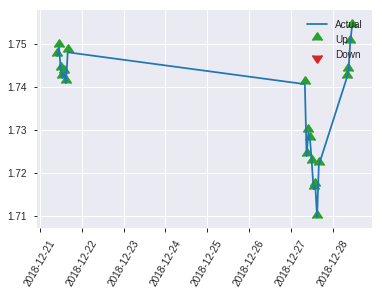


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25605408920911943
RMSE: 0.506017874396863
LogLoss: 0.7061710636599492
Mean Per-Class Error: 0.4277557100297915
AUC: 0.5413770274743462
pr_auc: 0.5496229341776983
Gini: 0.08275405494869248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21649296581745148: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    113  0.9912   (113.0/114.0)
1      0    106  0        (0.0/106.0)
Total  1    219  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.216493     0.652308  218
max f2                       0.216493     0.824261  218
max f0point5                 0.466379     0.54918   125
max accuracy                 0.550512     0.577273  78
max precision                0.805349     1         0
max recall                   0.216493     1         218
max specificity              0.805349     1         0
max absolute_mcc             0.748647     0.21418   8
max min_per_class_accuracy   0.499937     0.537736  107
max mean_per_class_accuracy  0.550512     0.572244  78

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.786299           2.07547   2.07547            1                0.797383  1                           0.797383            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.756186           2.07547   2.07547            1                0.758746  1                           0.781928            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.750482           2.07547   2.07547            1                0.752695  1                           0.773576            0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.743266           2.07547   2.07547            1                0.748965  1                           0.768106            0.0188679       0.0849057                  107.547   107.547
    5        0.05                        0.727647           0         1.69811            0                0.737351  0.818182                    0.762515            0               0.0849057                  -100      69.8113
    6        0.1                         0.691554           0.943396  1.32075            0.454545         0.707642  0.636364                    0.735078            0.0471698       0.132075                   -5.66038  32.0755
    7        0.15                        0.653118           0.377358  1.00629            0.181818         0.669609  0.484848                    0.713255            0.0188679       0.150943                   -62.2642  0.628931
    8        0.2                         0.623429           0.754717  0.943396           0.363636         0.637858  0.454545                    0.694406            0.0377358       0.188679                   -24.5283  -5.66038
    9        0.3                         0.575891           1.41509   1.10063            0.681818         0.598192  0.530303                    0.662334            0.141509        0.330189                   41.5094   10.0629
    10       0.4                         0.534937           1.32075   1.15566            0.636364         0.552957  0.556818                    0.63499             0.132075        0.462264                   32.0755   15.566
    11       0.5                         0.491351           0.754717  1.07547            0.363636         0.517414  0.518182                    0.611475            0.0754717       0.537736                   -24.5283  7.54717
    12       0.6                         0.454001           1.03774   1.06918            0.5              0.472846  0.515152                    0.58837             0.103774        0.641509                   3.77358   6.91824
    13       0.7                         0.430219           0.660377  1.01078            0.318182         0.442227  0.487013                    0.567492            0.0660377       0.707547                   -33.9623  1.07817
    14       0.8                         0.396007           0.943396  1.00236            0.454545         0.411975  0.482955                    0.548053            0.0943396       0.801887                   -5.66038  0.235849
    15       0.9                         0.359175           1.03774   1.00629            0.5              0.376429  0.484848                    0.528983            0.103774        0.90566                    3.77358   0.628931
    16       1                           0.214193           0.943396  1                  0.454545         0.310434  0.481818                    0.507129      

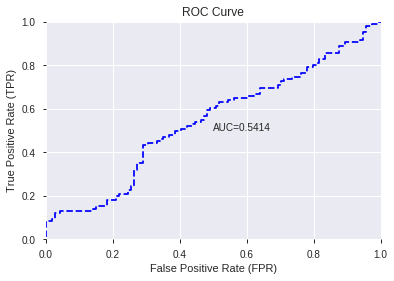

This function is available for GLM models only


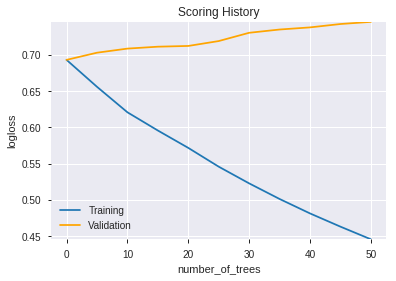

--2019-08-28 13:13:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.ja

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_131203_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_131203_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_131305_model_4  0.556604  0.865140              0.495614  0.543327  0.295204
1  DeepLearning_grid_1_AutoML_20190828_131305_model_2  0.510344  1.092458              0.500000  0.580784  0.337310
2  DeepLearning_grid_1_AutoML_20190828_131305_model_1  0.494373  1.273991              0.500000  0.572725  0.328013
3  DeepLearning_grid_1_AutoML_20190828_131305_model_3  0.481546  0.873651              0.500000  0.535832  0.287115
4               DeepLearning_1_AutoML_20190828_131305  0.472526  0.835814              0.500000  0.538190  0.289649
5  DeepLearning_grid_1_AutoML_20190828_131305_model_9  0.456430  0.697802              0.500000  0.502318  0.252323
6  DeepLearning_grid_1_AutoML_20190828_131305_model_6  0.454237  0.704031              0.482787  0.505386  0.255415
7  DeepLearning_grid_1_AutoML_20190828_131305_model_5  0.432307  0.718868              0.500000  0.512338  0.262490
8  DeepLearning_grid_1_AutoML_20190828_131305_model_7  0.431314  0.922773              0.495614  0.577953  0.334030
9  DeepLearning_grid_1_AutoML_20190828_131305_model_8  0.409757  0.699025              0.500000  0.502923  0.252931

variable  relative_importance  scaled_importance  percentage
0       CDLHOMINGPIGEON             1.000000           1.000000    0.030340
1   CDLRISEFALL3METHODS             0.978931           0.978931    0.029701
2             CDLINNECK             0.977386           0.977386    0.029654
3           CDLPIERCING             0.976539           0.976539    0.029628
4       CDLLADDERBOTTOM             0.976283           0.976283    0.029620
5     CDL3WHITESOLDIERS             0.974164           0.974164    0.029556
6   CDLGAPSIDESIDEWHITE             0.967809           0.967809    0.029363
7     CDLDARKCLOUDCOVER             0.962908           0.962908    0.029215
8    CDLEVENINGDOJISTAR             0.959352           0.959352    0.029107
9             CDLONNECK             0.932368           0.932368    0.028288
10         CDLTHRUSTING             0.932099           0.932099    0.028280
11         CDLTASUKIGAP             0.923409           0.923409    0.028016
12    CDLSTALLEDPATTERN             0.921699           0.921699    0.027964
13   CDLMORNINGDOJISTAR             0.917705           0.917705    0.027843
14        CDLHIKKAKEMOD             0.868993           0.868993    0.026365
15   CDLIDENTICAL3CROWS             0.860204           0.860204    0.026098
16       CDLEVENINGSTAR             0.815648           0.815648    0.024747
17  CDLXSIDEGAP3METHODS             0.773412           0.773412    0.023465
18       CDL3LINESTRIKE             0.764876           0.764876    0.023206
19    CDLINVERTEDHAMMER             0.709895           0.709895    0.021538
20           CDL3INSIDE             0.685691           0.685691    0.020804
21       CDLMORNINGSTAR             0.672303           0.672303    0.020398
22       CDLHARAMICROSS             0.670361           0.670361    0.020339
23      CDLSHOOTINGSTAR             0.654719           0.654719    0.019864
24   CDLSEPARATINGLINES             0.610517           0.610517    0.018523
25     CDLDRAGONFLYDOJI             0.585434           0.585434    0.017762
26            CDLTAKURI             0.576749           0.576749    0.017499
27        CDLHANGINGMAN             0.555831           0.555831    0.016864
28      CDLADVANCEBLOCK             0.541374           0.541374    0.016425
29    CDLGRAVESTONEDOJI             0.532463           0.532463    0.016155
30       CDLMATCHINGLOW             0.521559           0.521559    0.015824
31       is_month_start             0.515892           0.515892    0.015652
32                 CEIL             0.493014           0.493014    0.014958
33        days_in_month             0.467083           0.467083    0.014171
34                FLOOR             0.464940           0.464940    0.014106
35                  TAN             0.461908           0.461908    0.014014
36         is_month_end             0.449289           0.449289    0.013631
37            CDLHAMMER             0.444304           0.444304    0.013480
38                 hour             0.438204           0.438204    0.013295
39              BETA_20             0.431175           0.431175    0.013082
40          CDLDOJISTAR             0.427890           0.427890    0.012982
41   CDLCLOSINGMARUBOZU             0.419833           0.419833    0.012738
42             CORREL_8             0.419411           0.419411    0.012725
43                  SUB             0.416012           0.416012    0.012622
44               BETA_8             0.415001           0.415001    0.012591
45                MFI_8             0.407655           0.407655    0.012368
46       CDLRICKSHAWMAN             0.399362           0.399362    0.012117
47         HT_TRENDMODE             0.376060           0.376060    0.011410
48                  BOP             0.370372           0.370372    0.011237
49    CDLLONGLEGGEDDOJI             0.341819           0.341819    0.010371

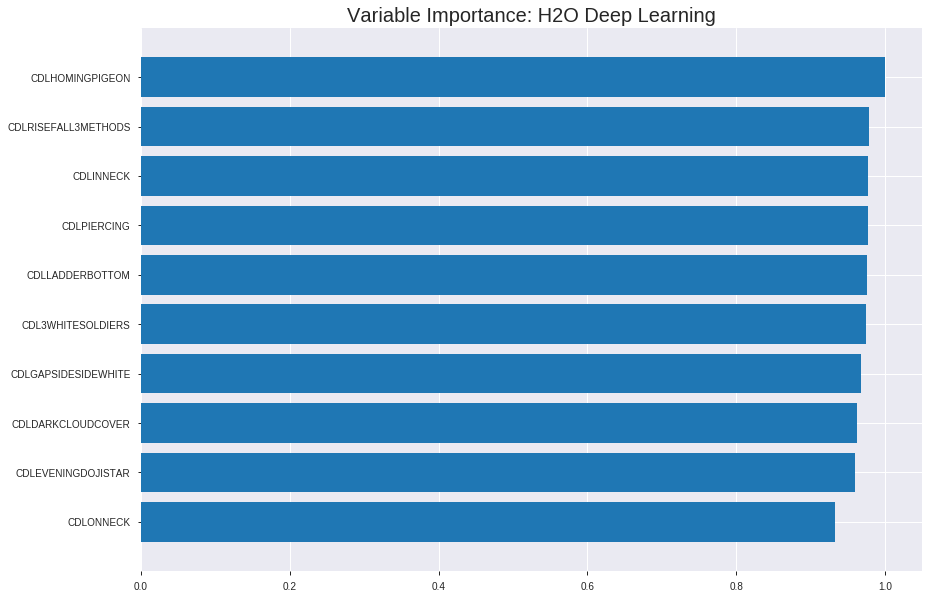

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_131305_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21819739712697866
RMSE: 0.46711604246373156
LogLoss: 0.633950400980734
Mean Per-Class Error: 0.3450137167242431
AUC: 0.7088650680755944
pr_auc: 0.6907180115708385
Gini: 0.4177301361511887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3769936672486014: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      283  477   0.6276   (477.0/760.0)
1      90   687   0.1158   (90.0/777.0)
Total  373  1164  0.3689   (567.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376994     0.707883  276
max f2                       0.172248     0.843956  357
max f0point5                 0.523215     0.65826   198
max accuracy                 0.523215     0.655172  198
max precision                0.999738     1         0
max recall                   0.0554353    1         387
max specificity              0.999738     1         0
max absolute_mcc             0.517843     0.310227  201
max min_per_class_accuracy   0.534028     0.651223  193
max mean_per_class_accuracy  0.523215     0.654986  198

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 53.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.996342           1.73086   1.73086            0.875            0.998641  0.875                       0.998641            0.018018        0.018018                   73.0856   73.0856
    2        0.0201692                   0.984724           1.71437   1.72288            0.866667         0.99151   0.870968                    0.99519             0.016731        0.034749                   71.4372   72.288
    3        0.0305791                   0.972961           1.48359   1.64142            0.75             0.978444  0.829787                    0.989489            0.015444        0.0501931                  48.3591   64.142
    4        0.0403383                   0.938804           1.5825    1.62716            0.8              0.963509  0.822581                    0.983204            0.015444        0.0656371                  58.2497   62.7164
    5        0.0500976                   0.906135           1.84625   1.66984            0.933333         0.921942  0.844156                    0.97127             0.018018        0.0836551                  84.6246   66.9842
    6        0.100195                    0.8261             1.64415   1.657              0.831169         0.864619  0.837662                    0.917944            0.0823681       0.166023                   64.4153   65.6997
    7        0.150293                    0.775715           1.46432   1.59277            0.74026          0.800382  0.805195                    0.878757            0.0733591       0.239382                   46.4323   59.2773
    8        0.20039                     0.725902           1.33587   1.52855            0.675325         0.75026   0.772727                    0.846633            0.0669241       0.306306                   33.5874   52.8548
    9        0.299935                    0.661523           1.0731    1.37739            0.542484         0.692968  0.696312                    0.795633            0.106821        0.413127                   7.30983   37.739
    10       0.40013                     0.594948           1.22027   1.33805            0.616883         0.627356  0.676423                    0.753496            0.122265        0.535393                   22.0269   33.8046
    11       0.500325                    0.533513           1.15604   1.3016             0.584416         0.565065  0.657997                    0.71576             0.11583         0.651223                   15.6045   30.1598
    12       0.59987                     0.476085           0.892094  1.23364            0.45098          0.50374   0.623644                    0.680577            0.0888031       0.740026                   -10.7906  23.3644
    13       0.700065                    0.413457           0.924836  1.18945            0.467532         0.445357  0.601301                    0.646912            0.0926641       0.83269                    -7.51642  18.9446
    14       0.79961                     0.336569           0.749876  1.13472            0.379085         0.378295  0.573637                    0.613471            0.0746461       0.907336                   -25.0124  13.4724
    15       0.899805                    0.248015           0.616557  1.07702            0.311688         0.294058  0.544469                    0.577904            0.0617761       0.969112                   -38.3443  7.70247
    16       1                           0.00115886         0.308279  1                  0.155844         0.138308  0.50553                     0.533859            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3034127336761258
RMSE: 0.5508291329224752
LogLoss: 0.9142105976456307
Mean Per-Class Error: 0.47512781828849215
AUC: 0.5075224205850306
pr_auc: 0.5570955487083019
Gini: 0.015044841170061218
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.013035508342287996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0130355    0.717201  399
max f2                       0.0130355    0.863764  399
max f0point5                 0.0130355    0.613161  399
max accuracy                 0.0220593    0.559091  397
max precision                0.780956     0.596154  47
max recall                   0.0130355    1         399
max specificity              0.999986     0.994845  0
max absolute_mcc             0.118535     0.083022  383
max min_per_class_accuracy   0.480737     0.50813   200
max mean_per_class_accuracy  0.557033     0.524872  156

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 49.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.99914            0.715447  0.715447           0.4              0.99981   0.4                         0.99981             0.00813008      0.00813008                 -28.4553  -28.4553
    2        0.0204545                   0.98425            0.447154  0.596206           0.25             0.99377   0.333333                    0.997126            0.00406504      0.0121951                  -55.2846  -40.3794
    3        0.0318182                   0.957643           1.78862   1.02207            1                0.968407  0.571429                    0.986869            0.0203252       0.0325203                  78.8618   2.20674
    4        0.0409091                   0.923594           0.894309  0.993677           0.5              0.93755   0.555556                    0.975909            0.00813008      0.0406504                  -10.5691  -0.63234
    5        0.05                        0.866777           0.447154  0.894309           0.25             0.911888  0.5                         0.964269            0.00406504      0.0447154                  -55.2846  -10.5691
    6        0.1                         0.801631           1.05691   0.97561            0.590909         0.834861  0.545455                    0.899565            0.0528455       0.097561                   5.69106   -2.43902
    7        0.15                        0.753601           0.894309  0.948509           0.5              0.775322  0.530303                    0.858151            0.0447154       0.142276                   -10.5691  -5.14905
    8        0.2                         0.699672           1.21951   1.01626            0.681818         0.724653  0.568182                    0.824776            0.0609756       0.203252                   21.9512   1.62602
    9        0.3                         0.616273           1.05691   1.02981            0.590909         0.661689  0.575758                    0.770414            0.105691        0.308943                   5.69106   2.98103
    10       0.4                         0.552279           1.05691   1.03659            0.590909         0.582973  0.579545                    0.723554            0.105691        0.414634                   5.69106   3.65854
    11       0.5                         0.480302           0.934959  1.01626            0.522727         0.516326  0.568182                    0.682108            0.0934959       0.50813                    -6.50407  1.62602
    12       0.6                         0.428527           0.97561   1.00949            0.545455         0.455477  0.564394                    0.644336            0.097561        0.605691                   -2.43902  0.948509
    13       0.7                         0.356051           1.05691   1.01626            0.590909         0.391002  0.568182                    0.608146            0.105691        0.711382                   5.69106   1.62602
    14       0.8                         0.281833           0.894309  1.00102            0.5              0.327254  0.559659                    0.573034            0.0894309       0.800813                   -10.5691  0.101626
    15       0.9                         0.172546           0.853659  0.984643           0.477273         0.229762  0.550505                    0.534893            0.0853659       0.886179                   -14.6341  -1.53568
    16       1                           0.0130355          1.13821   1                  0.636364         0.113654  0.559091                    0.492769


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:15:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:15:18  7.195 sec         336 obs/sec       1.45934   1             2243       0.628851         1.62586             -0.58201       0.533124        0.500424           1.97812          0.482108                         0.621971           1.84114               -0.56931         0.489565          0.533487             1.07317            0.440909
    2019-08-28 13:15:23  12.767 sec        376 obs/sec       2.87768   2             4423       0.586964         1.24838             -0.378277      0.558957        0.529244           1.48359          0.480807                         0.608666           1.45999               -0.502888        0.460313          0.521227             0.715447           0.440909
    2019-08-28 13:15:28  17.843 sec        408 obs/sec       4.33637   3             6665       0.607679         1.2697              -0.477278      0.55303         0.536106           1.97812          0.480807                         0.585309           1.33065               -0.389758        0.518837          0.555196             0.715447           0.436364
    2019-08-28 13:15:37  26.213 sec        463 obs/sec       7.28367   5             11195      0.570388         1.02721             -0.301529      0.570748        0.559702           1.60722          0.469096                         0.581272           1.28109               -0.370652        0.482242          0.534278             0.715447           0.438636
    2019-08-28 13:15:44  33.297 sec        510 obs/sec       10.2095   7             15692      0.596626         1.08923             -0.424026      0.600516        0.586548           1.48359          0.471047                         0.662889           1.57393               -0.782583        0.513955          0.553075             0.715447           0.440909
    2019-08-28 13:15:51  40.199 sec        544 obs/sec       13.1601   9             20227      0.515437         0.79024             -0.0628305     0.622224        0.592245           1.73086          0.443071                         0.574985           1.08897               -0.341163        0.499382          0.541571             0.715447           0.440909
    2019-08-28 13:15:56  45.708 sec        585 obs/sec       16.0592   11            24683      0.491219         0.685263            0.0346956      0.655208        0.644625           1.97812          0.445673                         0.574729           1.01193               -0.339968        0.465678          0.525683             0.715447           0.440909
    2019-08-28 13:16:01  50.984 sec        621 obs/sec       18.9798   13            29172      0.492456         0.696169            0.0298283      0.673066        0.666641           1.97812          0.405986                         0.573002           1.03076               -0.33193         0.49363           0.553356             0.715447           0.436364
    2019-08-28 13:16:08

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLHOMINGPIGEON      1.0                    1.0                  0.030339894756099363
CDLRISEFALL3METHODS  0.9789308905601501     0.9789308905601501   0.02970066019308958
CDLINNECK            0.9773862957954407     0.9773862957954407   0.02965379735048747
CDLPIERCING          0.9765387177467346     0.9765387177467346   0.029628081921692147
CDLLADDERBOTTOM      0.97628253698349       0.97628253698349     0.02962030942429677
---                  ---                    ---                  ---
MFI_8                0.40765461325645447    0.40765461325645447  0.012368198063039217
CDLRICKSHAWMAN       0.39936164021492004    0.39936164021492004  0.012116590133743893
HT_TRENDMODE         0.37605956196784973    0.37605956196784973  0.011409607532129388
BOP                  0.37037187814712524    0.37037187814712524  0.011237043803602636
CDLLONGLEGGEDDOJI    0.34181854128837585    0.34181854128837585  0.010370738568372728


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6523076923076924)

('auc', 0.5566037735849056)

('logloss', 0.8651396042119088)

('mean_per_class_error', 0.4360311155246608)

('rmse', 0.5433269808759598)

('mse', 0.29520420814778553)

deeplearning prediction progress: |███████████████████████████████████████| 100%


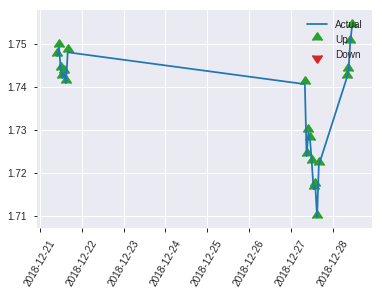


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.29520420814778553
RMSE: 0.5433269808759598
LogLoss: 0.8651396042119088
Mean Per-Class Error: 0.4360311155246608
AUC: 0.5566037735849056
pr_auc: 0.5307479502646066
Gini: 0.1132075471698113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.017220724669085762: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    113  0.9912   (113.0/114.0)
1      0    106  0        (0.0/106.0)
Total  1    219  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0172207    0.652308  218
max f2                       0.0172207    0.824261  218
max f0point5                 0.531726     0.558912  138
max accuracy                 0.865987     0.563636  23
max precision                0.865987     0.708333  23
max recall                   0.0172207    1         218
max specificity              0.993765     0.991228  0
max absolute_mcc             0.865987     0.158632  23
max min_per_class_accuracy   0.630156     0.54386   109
max mean_per_class_accuracy  0.531726     0.563969  138

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 58.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.983391           0         0                  0                0.991316  0                           0.991316            0               0                          -100      -100
    2        0.0227273                   0.955201           2.07547   0.830189           1                0.961117  0.4                         0.979236            0.0188679       0.0188679                  107.547   -16.9811
    3        0.0318182                   0.949996           1.03774   0.889488           0.5              0.950607  0.428571                    0.971056            0.00943396      0.0283019                  3.77358   -11.0512
    4        0.0409091                   0.948957           2.07547   1.15304            1                0.949481  0.555556                    0.966262            0.0188679       0.0471698                  107.547   15.304
    5        0.05                        0.944151           1.03774   1.13208            0.5              0.947606  0.545455                    0.96287             0.00943396      0.0566038                  3.77358   13.2075
    6        0.1                         0.871393           1.69811   1.41509            0.818182         0.903098  0.681818                    0.932984            0.0849057       0.141509                   69.8113   41.5094
    7        0.15                        0.83197            1.13208   1.32075            0.545455         0.857311  0.636364                    0.90776             0.0566038       0.198113                   13.2075   32.0755
    8        0.2                         0.798221           0.943396  1.22642            0.454545         0.81454   0.590909                    0.884455            0.0471698       0.245283                   -5.66038  22.6415
    9        0.3                         0.722248           0.754717  1.06918            0.363636         0.756164  0.515152                    0.841691            0.0754717       0.320755                   -24.5283  6.91824
    10       0.4                         0.679788           1.13208   1.08491            0.545455         0.702148  0.522727                    0.806805            0.113208        0.433962                   13.2075   8.49057
    11       0.5                         0.627468           1.13208   1.09434            0.545455         0.656247  0.527273                    0.776694            0.113208        0.54717                    13.2075   9.43396
    12       0.6                         0.539602           1.03774   1.08491            0.5              0.588596  0.522727                    0.745344            0.103774        0.650943                   3.77358   8.49057
    13       0.7                         0.486569           0.943396  1.06469            0.454545         0.516652  0.512987                    0.712674            0.0943396       0.745283                   -5.66038  6.469
    14       0.8                         0.377643           0.849057  1.03774            0.409091         0.438288  0.5                         0.678375            0.0849057       0.830189                   -15.0943  3.77358
    15       0.9                         0.258194           0.566038  0.985325           0.272727         0.318981  0.474747                    0.638443            0.0566038       0.886792                   -43.3962  -1.46751
    16       1                           0.00935713         1.13208   1                  0.545455         0.147447  0.481818                    0.589343            

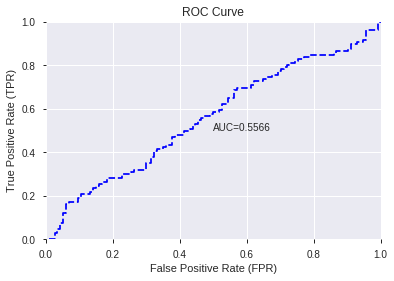

This function is available for GLM models only


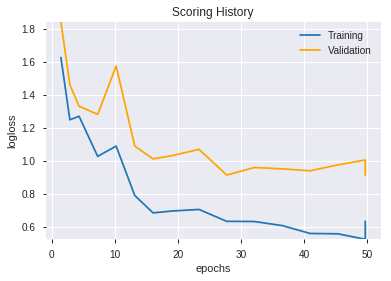

--2019-08-28 13:20:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_131305_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_131305_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHOMINGPIGEON',
 'CDLRISEFALL3METHODS',
 'CDLINNECK',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDLTHRUSTING',
 'CDLTASUKIGAP',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDLIDENTICAL3CROWS',
 'CDLEVENINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDL3LINESTRIKE',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLMORNINGSTAR',
 'CDLHARAMICROSS',
 'CDLSHOOTINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CEIL',
 'days_in_month',
 'FLOOR',
 'TAN',
 'is_month_end',
 'CDLHAMMER',
 'hour',
 'BETA_20',
 'CDLDOJISTAR',
 'CDLCLOSINGMARUBOZU',
 'CORREL_8',
 'SUB',
 'BETA_8',
 'MFI_8',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'BOP',
 'CDLLONGLEGGEDDOJI']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_132053_model_1  0.452334  0.695189                   0.5  0.501019  0.251021

variable  relative_importance  scaled_importance  percentage
0    CDLCLOSINGMARUBOZU             0.009186           1.000000    0.053085
1             CDLTAKURI             0.008327           0.906456    0.048120
2          CDLTHRUSTING             0.007996           0.870512    0.046212
3        CDLHARAMICROSS             0.007730           0.841493    0.044671
4                  hour             0.007396           0.805184    0.042744
5      CDLDRAGONFLYDOJI             0.007322           0.797125    0.042316
6            CDL3INSIDE             0.007319           0.796746    0.042296
7                BETA_8             0.006266           0.682094    0.036209
8       CDLHOMINGPIGEON             0.005724           0.623141    0.033080
9     CDLDARKCLOUDCOVER             0.005653           0.615404    0.032669
10        CDLHIKKAKEMOD             0.005475           0.596073    0.031643
11         is_month_end             0.004928           0.536423    0.028476
12             CORREL_8             0.004805           0.523066    0.027767
13    CDLSTALLEDPATTERN             0.004228           0.460316    0.024436
14   CDLIDENTICAL3CROWS             0.004217           0.459109    0.024372
15  CDLRISEFALL3METHODS             0.004102           0.446594    0.023708
16    CDL3WHITESOLDIERS             0.004093           0.445553    0.023652
17  CDLGAPSIDESIDEWHITE             0.004075           0.443581    0.023548
18          CDLPIERCING             0.004032           0.438880    0.023298
19   CDLEVENINGDOJISTAR             0.003977           0.432951    0.022983
20      CDLLADDERBOTTOM             0.003879           0.422279    0.022417
21            CDLINNECK             0.003751           0.408307    0.021675
22            CDLONNECK             0.003746           0.407837    0.021650
23      CDLSHOOTINGSTAR             0.003596           0.391427    0.020779
24       CDLEVENINGSTAR             0.003343           0.363876    0.019317
25                  BOP             0.003167           0.344778    0.018303
26                  SUB             0.002717           0.295803    0.015703
27         HT_TRENDMODE             0.002372           0.258225    0.013708
28   CDLMORNINGDOJISTAR             0.002152           0.234227    0.012434
29                FLOOR             0.002092           0.227752    0.012090
30                 CEIL             0.002077           0.226060    0.012001
31    CDLGRAVESTONEDOJI             0.001976           0.215103    0.011419
32       CDL3LINESTRIKE             0.001919           0.208871    0.011088
33  CDLXSIDEGAP3METHODS             0.001861           0.202555    0.010753
34          CDLDOJISTAR             0.001816           0.197659    0.010493
35       CDLMATCHINGLOW             0.001705           0.185573    0.009851
36      CDLADVANCEBLOCK             0.001698           0.184842    0.009812
37       is_month_start             0.001649           0.179557    0.009532
38       CDLRICKSHAWMAN             0.001625           0.176940    0.009393
39        days_in_month             0.001620           0.176400    0.009364
40                  TAN             0.001519           0.165389    0.008780
41   CDLSEPARATINGLINES             0.001484           0.161502    0.008573
42    CDLLONGLEGGEDDOJI             0.001256           0.136772    0.007261
43       CDLMORNINGSTAR             0.001220           0.132772    0.007048
44                MFI_8             0.000964           0.104919    0.005570
45              BETA_20             0.000494           0.053739    0.002853
46        CDLHANGINGMAN             0.000232           0.025273    0.001342
47    CDLINVERTEDHAMMER             0.000110           0.011978    0.000636
48         CDLTASUKIGAP             0.000095           0.010365    0.000550
49            CDLHAMMER             0.000056           0.006062    0.000322

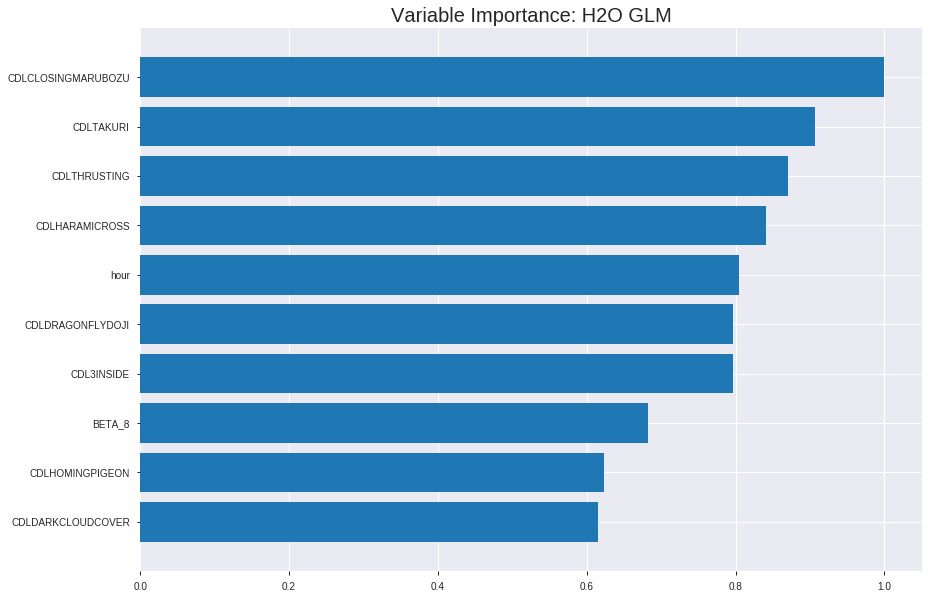

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_132053_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2486335846490407
RMSE: 0.4986317124381889
LogLoss: 0.6904109377621562
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.5464005801423
Residual deviance: 2122.3232226808686
AIC: 2224.3232226808686
AUC: 0.5848421730000678
pr_auc: 0.5848030061764965
Gini: 0.1696843460001356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49639195966167526: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      68   692   0.9105   (692.0/760.0)
1      23   754   0.0296   (23.0/777.0)
Total  91   1446  0.4652   (715.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496392     0.678363  330
max f2                       0.478135     0.837838  382
max f0point5                 0.502418     0.581374  258
max accuracy                 0.505808     0.56864   191
max precision                0.574224     1         0
max recall                   0.472169     1         392
max specificity              0.574224     1         0
max absolute_mcc             0.505808     0.136965  191
max min_per_class_accuracy   0.505955     0.564474  188
max mean_per_class_accuracy  0.505808     0.568436  191

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.524647           1.73086   1.73086            0.875            0.538847  0.875                       0.538847            0.018018        0.018018                   73.0856   73.0856
    2        0.0201692                   0.519528           1.31875   1.53145            0.666667         0.521728  0.774194                    0.530563            0.01287         0.030888                   31.8747   53.1448
    3        0.0305791                   0.517185           1.35996   1.47307            0.6875           0.518293  0.744681                    0.526386            0.014157        0.045045                   35.9958   47.3069
    4        0.0403383                   0.515862           1.31875   1.43573            0.666667         0.516408  0.725806                    0.523972            0.01287         0.0579151                  31.8747   43.5733
    5        0.0500976                   0.514464           1.5825    1.46432            0.8              0.515017  0.74026                     0.522228            0.015444        0.0733591                  58.2497   46.4323
    6        0.100195                    0.511803           1.10466   1.28449            0.558442         0.512902  0.649351                    0.517565            0.0553411       0.1287                     10.4665   28.4494
    7        0.150293                    0.510637           1.00191   1.1903             0.506494         0.511187  0.601732                    0.515439            0.0501931       0.178893                   0.190543  19.0298
    8        0.20039                     0.509867           1.05329   1.15604            0.532468         0.510236  0.584416                    0.514138            0.0527671       0.23166                    5.32852   15.6045
    9        0.299935                    0.508453           1.08603   1.13281            0.54902          0.509146  0.572668                    0.512481            0.108108        0.339768                   8.60272   13.2807
    10       0.40013                     0.507215           1.15604   1.13863            0.584416         0.507845  0.57561                     0.51132             0.11583         0.455598                   15.6045   13.8626
    11       0.500325                    0.505958           1.11751   1.1344             0.564935         0.506564  0.573472                    0.510368            0.111969        0.567568                   11.751    13.4397
    12       0.59987                     0.504842           0.917952  1.09848            0.464052         0.505425  0.555315                    0.509548            0.0913771       0.658945                   -8.20484  9.84793
    13       0.700065                    0.503588           0.911991  1.07179            0.461039         0.504244  0.541822                    0.508789            0.0913771       0.750322                   -8.80092  7.17886
    14       0.79961                     0.501936           0.969667  1.05908            0.490196         0.502845  0.535395                    0.508049            0.0965251       0.846847                   -3.03329  5.90753
    15       0.899805                    0.498953           0.899146  1.04127            0.454545         0.500649  0.526392                    0.507225            0.0900901       0.936937                   -10.0854  4.12669
    16       1                           0.440575           0.629402  1                  0.318182         0.490314  0.50553                     0.50553          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24977450298292114
RMSE: 0.49977445211107097
LogLoss: 0.69269962642914
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 608.8730098202949
Residual deviance: 609.5756712576431
AIC: 711.5756712576431
AUC: 0.48234640851563154
pr_auc: 0.5409421167896479
Gini: -0.035307182968736917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4640332737822573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    193  0.9948   (193.0/194.0)
1      0    246  0        (0.0/246.0)
Total  1    439  0.4386   (193.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.464033     0.718248   398
max f2                       0.464033     0.864371   398
max f0point5                 0.489576     0.619147   378
max accuracy                 0.489576     0.570455   378
max precision                0.509466     0.591837   90
max recall                   0.464033     1          398
max specificity              0.576219     0.994845   0
max absolute_mcc             0.513242     0.0880654  23
max min_per_class_accuracy   0.505788     0.479675   195
max mean_per_class_accuracy  0.489576     0.517245   378

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.53126            0.715447  0.715447           0.4              0.548898  0.4                         0.548898            0.00813008      0.00813008                 -28.4553  -28.4553
    2        0.0204545                   0.515996           0.447154  0.596206           0.25             0.519882  0.333333                    0.536002            0.00406504      0.0121951                  -55.2846  -40.3794
    3        0.0318182                   0.514917           0.715447  0.638792           0.4              0.515511  0.357143                    0.528684            0.00813008      0.0203252                  -28.4553  -36.1208
    4        0.0409091                   0.514515           0.894309  0.695574           0.5              0.514685  0.388889                    0.525573            0.00813008      0.0284553                  -10.5691  -30.4426
    5        0.05                        0.513464           1.34146   0.813008           0.75             0.513873  0.454545                    0.523446            0.0121951       0.0406504                  34.1463   -18.6992
    6        0.1                         0.511958           1.05691   0.934959           0.590909         0.512609  0.522727                    0.518027            0.0528455       0.0934959                  5.69106   -6.50407
    7        0.15                        0.511112           1.21951   1.02981            0.681818         0.511489  0.575758                    0.515848            0.0609756       0.154472                   21.9512   2.98103
    8        0.2                         0.509884           0.97561   1.01626            0.545455         0.510511  0.568182                    0.514514            0.0487805       0.203252                   -2.43902  1.62602
    9        0.3                         0.507906           1.01626   1.01626            0.568182         0.508861  0.568182                    0.512629            0.101626        0.304878                   1.62602   1.62602
    10       0.4                         0.506865           0.894309  0.985772           0.5              0.50744   0.551136                    0.511332            0.0894309       0.394309                   -10.5691  -1.42276
    11       0.5                         0.505696           0.894309  0.96748            0.5              0.506297  0.540909                    0.510325            0.0894309       0.48374                    -10.5691  -3.25203
    12       0.6                         0.50408            1.01626   0.97561            0.568182         0.504988  0.545455                    0.509436            0.101626        0.585366                   1.62602   -2.43902
    13       0.7                         0.5028             0.97561   0.97561            0.545455         0.503494  0.545455                    0.508587            0.097561        0.682927                   -2.43902  -2.43902
    14       0.8                         0.501136           1.05691   0.985772           0.590909         0.502057  0.551136                    0.507771            0.105691        0.788618                   5.69106   -1.42276
    15       0.9                         0.497847           1.13821   1.00271            0.636364         0.499935  0.560606                    0.5069              0.113821        0.902439                   13.8211   0.271003
    16       1                           0.462849           0.97561   1                  0.545455         0.48821   0.559091                    0.505


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:20:54  0.000 sec   2            2.9       51            1.38082           1.3854
    2019-08-28 13:20:54  0.012 sec   4            1.8       51            1.37821           1.38649
    2019-08-28 13:20:54  0.024 sec   6            1.1       51            1.37472           1.38831
    2019-08-28 13:20:54  0.036 sec   8            0.69      51            1.37042           1.39128
    2019-08-28 13:20:54  0.049 sec   10           0.43      51            1.36559           1.39586

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5181818181818182)

('F1', 0.6503067484662576)

('auc', 0.45233366434955313)

('logloss', 0.6951894780402491)

('mean_per_class_error', 0.4950347567030785)

('rmse', 0.5010194767296252)

('mse', 0.2510205160624274)

glm prediction progress: |████████████████████████████████████████████████| 100%


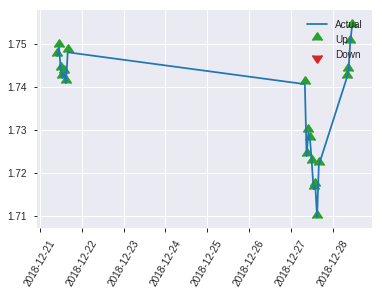


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2510205160624274
RMSE: 0.5010194767296252
LogLoss: 0.6951894780402491
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.18865009111494
Residual deviance: 305.8833703377096
AIC: 407.8833703377096
AUC: 0.45233366434955313
pr_auc: 0.4470072171474433
Gini: -0.09533267130089373
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46281686367120517: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    106  0        (0.0/106.0)
Total  0    220  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462817     0.650307  219
max f2                       0.462817     0.822981  219
max f0point5                 0.462817     0.537525  219
max accuracy                 0.516019     0.518182  5
max precision                0.516019     0.5       5
max recall                   0.462817     1         219
max specificity              0.527636     0.991228  0
max absolute_mcc             0.5005       0.132394  188
max min_per_class_accuracy   0.506905     0.462264  107
max mean_per_class_accuracy  0.505318     0.504965  139

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.521268           0         0                  0                0.524092  0                           0.524092            0               0                          -100      -100
    2        0.0227273                   0.517066           2.07547   0.830189           1                0.518009  0.4                         0.521659            0.0188679       0.0188679                  107.547   -16.9811
    3        0.0318182                   0.515949           1.03774   0.889488           0.5              0.515991  0.428571                    0.520039            0.00943396      0.0283019                  3.77358   -11.0512
    4        0.0409091                   0.515352           1.03774   0.922432           0.5              0.515758  0.444444                    0.519088            0.00943396      0.0377358                  3.77358   -7.75681
    5        0.05                        0.514636           1.03774   0.943396           0.5              0.515256  0.454545                    0.518391            0.00943396      0.0471698                  3.77358   -5.66038
    6        0.1                         0.512794           0.943396  0.943396           0.454545         0.513458  0.454545                    0.515925            0.0471698       0.0943396                  -5.66038  -5.66038
    7        0.15                        0.511694           0.754717  0.880503           0.363636         0.512408  0.424242                    0.514753            0.0377358       0.132075                   -24.5283  -11.9497
    8        0.2                         0.510478           1.13208   0.943396           0.545455         0.511108  0.454545                    0.513841            0.0566038       0.188679                   13.2075   -5.66038
    9        0.3                         0.509299           0.849057  0.91195            0.409091         0.509762  0.439394                    0.512481            0.0849057       0.273585                   -15.0943  -8.80503
    10       0.4                         0.507981           0.754717  0.872642           0.363636         0.508635  0.420455                    0.51152             0.0754717       0.349057                   -24.5283  -12.7358
    11       0.5                         0.506826           1.13208   0.924528           0.545455         0.507447  0.445455                    0.510705            0.113208        0.462264                   13.2075   -7.54717
    12       0.6                         0.505599           1.13208   0.959119           0.545455         0.506199  0.462121                    0.509954            0.113208        0.575472                   13.2075   -4.08805
    13       0.7                         0.504443           1.13208   0.983827           0.545455         0.505075  0.474026                    0.509257            0.113208        0.688679                   13.2075   -1.61725
    14       0.8                         0.502571           0.849057  0.966981           0.409091         0.50353   0.465909                    0.508541            0.0849057       0.773585                   -15.0943  -3.30189
    15       0.9                         0.498698           1.03774   0.974843           0.5              0.500654  0.469697                    0.507665            0.103774        0.877358                   3.77358   -2.51572
    16       1                           0.462817           1.22642   1                  0.590909         0.489514  0.481818                    0.5058

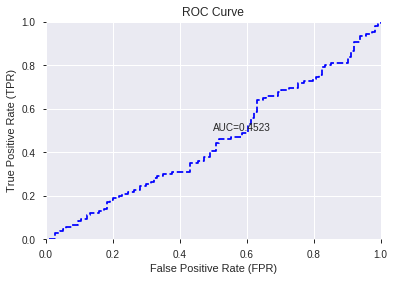

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


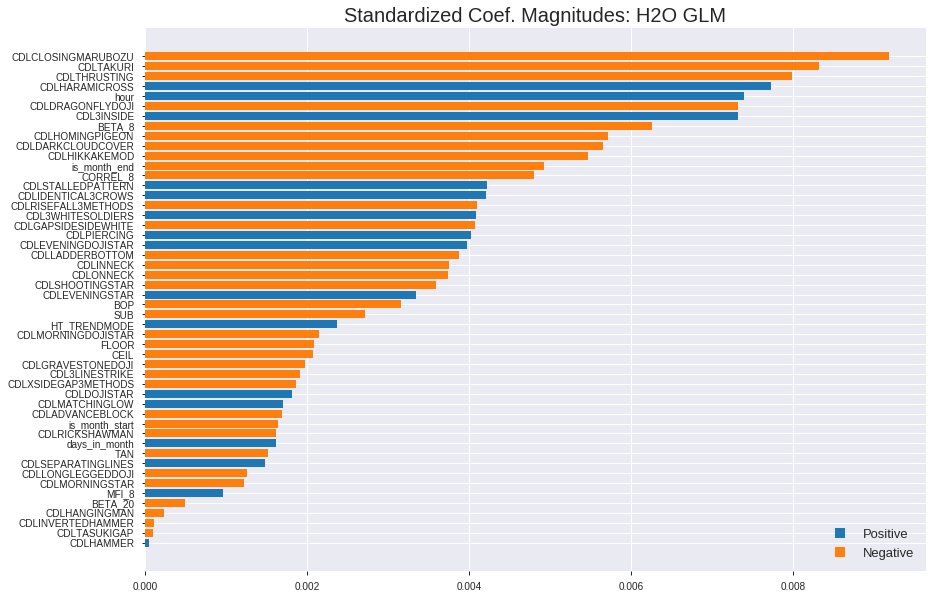

'log_likelihood'
--2019-08-28 13:20:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_132053_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_132053_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'CDLTHRUSTING',
 'CDLHARAMICROSS',
 'hour',
 'CDLDRAGONFLYDOJI',
 'CDL3INSIDE',
 'BETA_8',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'is_month_end',
 'CORREL_8',
 'CDLSTALLEDPATTERN',
 'CDLIDENTICAL3CROWS',
 'CDLRISEFALL3METHODS',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'CDLONNECK',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGSTAR',
 'BOP',
 'SUB',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'FLOOR',
 'CEIL',
 'CDLGRAVESTONEDOJI',
 'CDL3LINESTRIKE',
 'CDLXSIDEGAP3METHODS',
 'CDLDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'TAN',
 'CDLSEPARATINGLINES',
 'CDLLONGLEGGEDDOJI',
 'CDLMORNINGSTAR',
 'MFI_8',
 'BETA_20',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLTASUKIGAP',
 'CDLHAMMER']

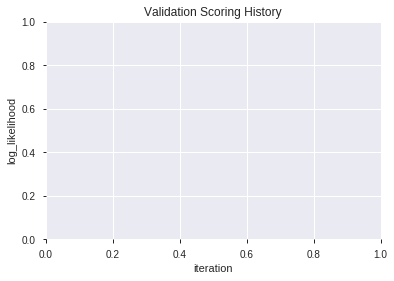

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_132105_model_7  0.490483  0.716622              0.491559  0.511191  0.261316
1  XGBoost_grid_1_AutoML_20190828_132105_model_1  0.467519  0.711223              0.500000  0.508762  0.258838
2  XGBoost_grid_1_AutoML_20190828_132105_model_5  0.453740  0.747578              0.482787  0.524875  0.275494
3               XGBoost_1_AutoML_20190828_132105  0.450761  0.723205              0.500000  0.514390  0.264597
4               XGBoost_3_AutoML_20190828_132105  0.449189  0.719398              0.500000  0.512678  0.262839
5  XGBoost_grid_1_AutoML_20190828_132105_model_2  0.442072  0.711631              0.500000  0.509048  0.259130
6  XGBoost_grid_1_AutoML_20190828_132105_model_4  0.439341  0.714561              0.500000  0.510433  0.260542
7               XGBoost_2_AutoML_20190828_132105  0.431314  0.730644              0.500000  0.517724  0.268038
8  XGBoost_grid_1_AutoML_20190828_132105_model_3  0.418736  0.725639              0.500000  0.515639  0.265884
9  XGBoost_grid_1_AutoML_20190828_132105_model_6  0.416336  0.728985              0.500000  0.517198  0.267494

variable  relative_importance  scaled_importance  percentage
0              BETA_20           821.531128           1.000000    0.150138
1                  TAN           803.579407           0.978148    0.146858
2             CORREL_8           731.890869           0.890886    0.133756
3                MFI_8           710.356628           0.864674    0.129821
4                  BOP           689.544678           0.839341    0.126017
5               BETA_8           590.479858           0.718755    0.107913
6                  SUB           539.366089           0.656538    0.098572
7                 hour           338.829834           0.412437    0.061923
8         HT_TRENDMODE            86.428406           0.105204    0.015795
9   CDLCLOSINGMARUBOZU            66.592751           0.081059    0.012170
10       days_in_month            65.276520           0.079457    0.011930
11   CDLLONGLEGGEDDOJI            10.215055           0.012434    0.001867
12                CEIL             6.958487           0.008470    0.001272
13        is_month_end             6.624173           0.008063    0.001211
14      CDLRICKSHAWMAN             4.149872           0.005051    0.000758

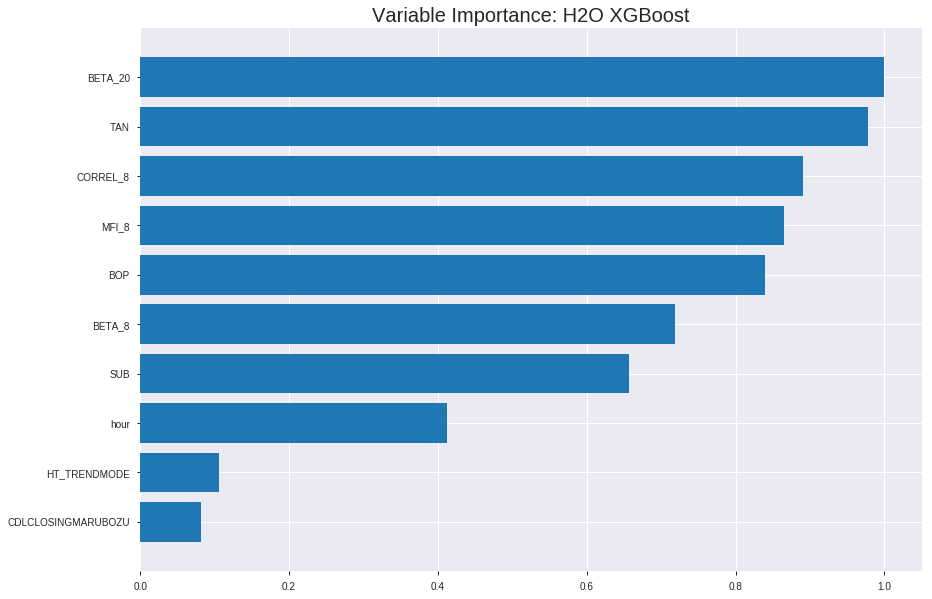

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_132105_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17556299121200222
RMSE: 0.4190023761412365
LogLoss: 0.5390405695585846
Mean Per-Class Error: 0.1476436022488654
AUC: 0.926870385423017
pr_auc: 0.9275538722735942
Gini: 0.8537407708460341
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49886758128801983: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      639  121  0.1592   (121.0/760.0)
1      108  669  0.139    (108.0/777.0)
Total  747  790  0.149    (229.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498868     0.853861  198
max f2                       0.438704     0.903163  251
max f0point5                 0.544243     0.865355  157
max accuracy                 0.50373      0.85231   193
max precision                0.774068     1         0
max recall                   0.344332     1         332
max specificity              0.774068     1         0
max absolute_mcc             0.50373      0.70467   193
max min_per_class_accuracy   0.501281     0.850708  195
max mean_per_class_accuracy  0.50373      0.852356  193

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.75365            1.97812    1.97812            1                0.763869  1                           0.763869            0.020592        0.020592                   97.8121   97.8121
    2        0.0201692                   0.737513           1.97812    1.97812            1                0.74595   1                           0.755199            0.019305        0.039897                   97.8121   97.8121
    3        0.0305791                   0.713948           1.97812    1.97812            1                0.726329  1                           0.745371            0.020592        0.0604891                  97.8121   97.8121
    4        0.0403383                   0.703575           1.97812    1.97812            1                0.707431  1                           0.736192            0.019305        0.0797941                  97.8121   97.8121
    5        0.0500976                   0.695224           1.97812    1.97812            1                0.698577  1                           0.728864            0.019305        0.0990991                  97.8121   97.8121
    6        0.100195                    0.668514           1.92674    1.95243            0.974026         0.681509  0.987013                    0.705187            0.0965251       0.195624                   92.6741   95.2431
    7        0.150293                    0.643953           1.95243    1.95243            0.987013         0.655966  0.987013                    0.68878             0.0978121       0.293436                   95.2431   95.2431
    8        0.20039                     0.622835           1.92674    1.94601            0.974026         0.63306   0.983766                    0.67485             0.0965251       0.389961                   92.6741   94.6009
    9        0.299935                    0.581871           1.8359     1.90947            0.928105         0.601232  0.965293                    0.650417            0.182754        0.572716                   83.5903   90.9466
    10       0.40013                     0.541189           1.45148    1.79478            0.733766         0.561938  0.907317                    0.628261            0.145431        0.718147                   45.1478   79.4783
    11       0.500325                    0.503185           1.29734    1.69516            0.655844         0.520708  0.856957                    0.606723            0.129987        0.848134                   29.7339   69.5165
    12       0.59987                     0.464696           0.672303   1.52543            0.339869         0.482867  0.77115                     0.58617             0.0669241       0.915058                   -32.7697  52.5427
    13       0.700065                    0.428289           0.513798   1.38064            0.25974          0.44651   0.697955                    0.566181            0.0514801       0.966538                   -48.6202  38.064
    14       0.79961                     0.388366           0.271507   1.24256            0.137255         0.408445  0.628153                    0.546544            0.027027        0.993565                   -72.8493  24.2563
    15       0.899805                    0.335277           0.0642247  1.11135            0.0324675        0.361679  0.561822                    0.525959            0.00643501      1                          -93.5775  11.1352
    16       1                           0.218813           0          1                  0                0.296631  0.50553                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26407813368900596
RMSE: 0.5138853312646762
LogLoss: 0.7227164713318867
Mean Per-Class Error: 0.4857094962702204
AUC: 0.47068560891794486
pr_auc: 0.5371027898959626
Gini: -0.05862878216411027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2557278573513031: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255728     0.717201  399
max f2                       0.255728     0.863764  399
max f0point5                 0.255728     0.613161  399
max accuracy                 0.295144     0.559091  395
max precision                0.740621     1         0
max recall                   0.255728     1         399
max specificity              0.740621     1         0
max absolute_mcc             0.680597     0.120934  13
max min_per_class_accuracy   0.508101     0.469072  201
max mean_per_class_accuracy  0.618463     0.514291  59

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.723614           1.07317   1.07317            0.6              0.73052   0.6                         0.73052             0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.697336           0.447154  0.794941           0.25             0.713572  0.444444                    0.722987            0.00406504      0.0162602                  -55.2846  -20.5059
    3        0.0318182                   0.688206           0         0.511034           0                0.693501  0.285714                    0.712456            0               0.0162602                  -100      -48.8966
    4        0.0409091                   0.673922           0.894309  0.596206           0.5              0.678635  0.333333                    0.704941            0.00813008      0.0243902                  -10.5691  -40.3794
    5        0.05                        0.664035           1.34146   0.731707           0.75             0.669856  0.409091                    0.698562            0.0121951       0.0365854                  34.1463   -26.8293
    6        0.1                         0.634157           1.38211   1.05691            0.772727         0.650047  0.590909                    0.674304            0.0691057       0.105691                   38.2114   5.69106
    7        0.15                        0.616924           1.13821   1.08401            0.636364         0.62624   0.606061                    0.658283            0.0569106       0.162602                   13.8211   8.40108
    8        0.2                         0.593661           0.731707  0.995935           0.409091         0.605675  0.556818                    0.645131            0.0365854       0.199187                   -26.8293  -0.406504
    9        0.3                         0.562339           0.772358  0.921409           0.431818         0.577549  0.515152                    0.622603            0.0772358       0.276423                   -22.7642  -7.85908
    10       0.4                         0.529395           1.05691   0.955285           0.590909         0.543288  0.534091                    0.602775            0.105691        0.382114                   5.69106   -4.47154
    11       0.5                         0.50791            0.894309  0.943089           0.5              0.518042  0.527273                    0.585828            0.0894309       0.471545                   -10.5691  -5.69106
    12       0.6                         0.483216           1.05691   0.96206            0.590909         0.495447  0.537879                    0.570765            0.105691        0.577236                   5.69106   -3.79404
    13       0.7                         0.453043           1.17886   0.993031           0.659091         0.469317  0.555195                    0.556272            0.117886        0.695122                   17.8862   -0.696864
    14       0.8                         0.415952           0.894309  0.980691           0.5              0.43561   0.548295                    0.541189            0.0894309       0.784553                   -10.5691  -1.93089
    15       0.9                         0.372191           1.01626   0.984643           0.568182         0.397181  0.550505                    0.525188            0.101626        0.886179                   1.62602   -1.53568
    16       1                           0.255728           1.13821   1                  0.636364         0.334873  0.559091                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:21:15  7.123 sec   0                  0.5              0.693147            0.5             0                  1                0.49447                          0.5                0.693147              0.5               0                    1                  0.440909
    2019-08-28 13:21:15  7.223 sec   5                  0.489582         0.672488            0.751807        0.740385           1.73086          0.332466                         0.501015           0.695185              0.477338          0.536814             0.357724           0.434091
    2019-08-28 13:21:16  7.297 sec   10                 0.480126         0.654001            0.805765        0.808853           1.97812          0.297983                         0.501877           0.696923              0.485102          0.544607             0.357724           0.434091
    2019-08-28 13:21:16  7.373 sec   15                 0.470962         0.636295            0.83998         0.844463           1.97812          0.258295                         0.504787           0.702827              0.458815          0.531575             1.07317            0.438636
    2019-08-28 13:21:16  7.447 sec   20                 0.463405         0.621785            0.853634        0.857899           1.97812          0.258295                         0.505093           0.703496              0.469963          0.555893             1.43089            0.438636
    2019-08-28 13:21:16  7.542 sec   25                 0.453801         0.603561            0.873891        0.87726            1.97812          0.211451                         0.506557           0.7065                0.466935          0.547234             1.43089            0.438636
    2019-08-28 13:21:16  7.634 sec   30                 0.445927         0.588756            0.890972        0.892866           1.97812          0.192583                         0.507195           0.707912              0.476144          0.541632             1.07317            0.438636
    2019-08-28 13:21:16  7.729 sec   35                 0.437568         0.573189            0.904462        0.905406           1.97812          0.184776                         0.508138           0.709961              0.475254          0.543859             1.07317            0.438636
    2019-08-28 13:21:16  7.816 sec   40                 0.430254         0.559713            0.915531        0.915751           1.97812          0.167209                         0.509949           0.713978              0.474153          0.537692             0.715447           0.440909
    2019-08-28 13:21:16  7.899 sec   45                 0.42423          0.548534            0.919051        0.920726           1.97812          0.167209                         0.511863           0.718217              0.472655          0.53461              0.715447           0.440909
    2019-08-28 13:21:16  7.984 sec   50                 0.419002         0.539041            0.92687         0.927554           1.97812          0.148992                         0.513885           0.722716              0.470686          0.537103             1.07317            0.440909

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BETA_20             821.531                1                    0.150138
TAN                 803.579                0.978148             0.146858
CORREL_8            731.891                0.890886             0.133756
MFI_8               710.357                0.864674             0.129821
BOP                 689.545                0.839341             0.126017
BETA_8              590.48                 0.718755             0.107913
SUB                 539.366                0.656538             0.0985715
hour                338.83                 0.412437             0.0619227
HT_TRENDMODE        86.4284                0.105204             0.0157952
CDLCLOSINGMARUBOZU  66.5928                0.0810593            0.0121701
days_in_month       65.2765                0.0794571            0.0119296
CDLLONGLEGGEDDOJI   10.2151                0.0124342            0.00186685
CEIL                6.95849                0.00847014           0.00127169
is_month_end        6.62417                0.0080632            0.0012106
CDLRICKSHAWMAN      4.14987                0.00505139           0.000758408

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.6521739130434783)

('auc', 0.4904832836809004)

('logloss', 0.716622033915633)

('mean_per_class_error', 0.4556438265475008)

('rmse', 0.5111910153236081)

('mse', 0.2613162541475813)

xgboost prediction progress: |████████████████████████████████████████████| 100%


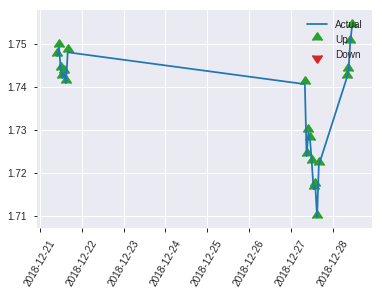


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2613162541475813
RMSE: 0.5111910153236081
LogLoss: 0.716622033915633
Mean Per-Class Error: 0.4556438265475008
AUC: 0.4904832836809004
pr_auc: 0.48963806048222586
Gini: -0.019033432638199232
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30424922704696655: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    111  0.9737   (111.0/114.0)
1      1    105  0.0094   (1.0/106.0)
Total  4    216  0.5091   (112.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304249     0.652174  215
max f2                       0.267645     0.822981  219
max f0point5                 0.304249     0.541237  215
max accuracy                 0.593912     0.554545  45
max precision                0.762232     1         0
max recall                   0.267645     1         219
max specificity              0.762232     1         0
max absolute_mcc             0.422164     0.124082  180
max min_per_class_accuracy   0.523023     0.481132  107
max mean_per_class_accuracy  0.590389     0.544356  47

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.723235           1.38365   1.38365            0.666667         0.744799  0.666667                    0.744799            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.692132           0         0.830189           0                0.696665  0.4                         0.725545            0               0.0188679                  -100      -16.9811
    3        0.0318182                   0.674344           2.07547   1.18598            1                0.684248  0.571429                    0.713746            0.0188679       0.0377358                  107.547   18.5984
    4        0.0409091                   0.667441           0         0.922432           0                0.669844  0.444444                    0.70399             0               0.0377358                  -100      -7.75681
    5        0.05                        0.658077           2.07547   1.13208            1                0.664462  0.545455                    0.696803            0.0188679       0.0566038                  107.547   13.2075
    6        0.1                         0.630107           0.943396  1.03774            0.454545         0.640628  0.5                         0.668716            0.0471698       0.103774                   -5.66038  3.77358
    7        0.15                        0.610296           1.13208   1.06918            0.545455         0.6201    0.515152                    0.65251             0.0566038       0.160377                   13.2075   6.91824
    8        0.2                         0.595551           1.50943   1.17925            0.727273         0.604973  0.568182                    0.640626            0.0754717       0.235849                   50.9434   17.9245
    9        0.3                         0.572098           0.660377  1.00629            0.318182         0.583485  0.484848                    0.621579            0.0660377       0.301887                   -33.9623  0.628931
    10       0.4                         0.544573           1.13208   1.03774            0.545455         0.556542  0.5                         0.60532             0.113208        0.415094                   13.2075   3.77358
    11       0.5                         0.519798           0.660377  0.962264           0.318182         0.531352  0.463636                    0.590526            0.0660377       0.481132                   -33.9623  -3.77358
    12       0.6                         0.496857           0.943396  0.959119           0.454545         0.508693  0.462121                    0.576887            0.0943396       0.575472                   -5.66038  -4.08805
    13       0.7                         0.47029            1.13208   0.983827           0.545455         0.486936  0.474026                    0.564037            0.113208        0.688679                   13.2075   -1.61725
    14       0.8                         0.433727           0.754717  0.955189           0.363636         0.452212  0.460227                    0.550059            0.0754717       0.764151                   -24.5283  -4.48113
    15       0.9                         0.390387           1.22642   0.985325           0.590909         0.410523  0.474747                    0.534555            0.122642        0.886792                   22.6415   -1.46751
    16       1                           0.267645           1.13208   1                  0.545455         0.342868  0.481818                    0.515386 

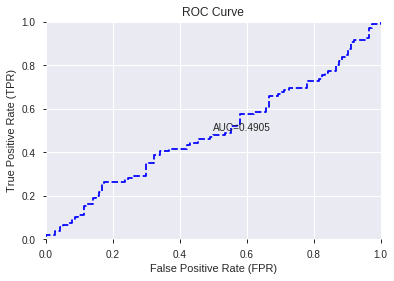

This function is available for GLM models only


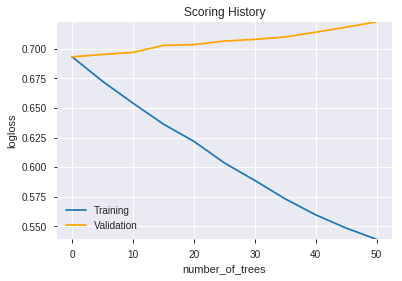

--2019-08-28 13:21:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_132105_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_132105_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BETA_20',
 'TAN',
 'CORREL_8',
 'MFI_8',
 'BOP',
 'BETA_8',
 'SUB',
 'hour',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'CEIL',
 'is_month_end',
 'CDLRICKSHAWMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_132129_model_7  0.609525  0.801201              0.410212  0.497032  0.247041
1  DeepLearning_grid_1_AutoML_20190828_132129_model_5  0.589043  0.700000              0.500000  0.503409  0.253420
2               DeepLearning_1_AutoML_20190828_132129  0.587637  0.838735              0.461850  0.538856  0.290365
3  DeepLearning_grid_1_AutoML_20190828_132129_model_1  0.566783  2.756460              0.449024  0.637335  0.406196
4  DeepLearning_grid_1_AutoML_20190828_132129_model_4  0.549404  0.957852              0.500000  0.559240  0.312749
5  DeepLearning_grid_1_AutoML_20190828_132129_model_2  0.504634  0.708861              0.461850  0.507162  0.257213
6  DeepLearning_grid_1_AutoML_20190828_132129_model_8  0.500000  0.694807              0.500000  0.500829  0.250829
7  DeepLearning_grid_1_AutoML_20190828_132129_model_6  0.493545  0.703098              0.500000  0.504886  0.254910
8  DeepLearning_grid_1_AutoML_20190828_132129_model_9  0.450596  0.695565              0.500000  0.501207  0.251208
9  DeepLearning_grid_1_AutoML_20190828_132129_model_3  0.442320  0.800836              0.500000  0.544919  0.296936

variable  relative_importance  scaled_importance  percentage
0           CDLLONGLEGGEDDOJI             1.000000           1.000000    0.001104
1              STOCHRSI_fastk             0.993214           0.993214    0.001097
2              CDLRICKSHAWMAN             0.964542           0.964542    0.001065
3                     CDLDOJI             0.957649           0.957649    0.001057
4          CDLCLOSINGMARUBOZU             0.954261           0.954261    0.001054
...                       ...                  ...                ...         ...
1033  BBANDS_upperband_24_5_5             0.805767           0.805767    0.000890
1034              AROONOSC_12             0.804985           0.804985    0.000889
1035   LINEARREG_INTERCEPT_30             0.804633           0.804633    0.000888
1036   BBANDS_lowerband_8_6_5             0.800164           0.800164    0.000883
1037                     SINH             0.799124           0.799124    0.000882

[1038 rows x 4 columns]

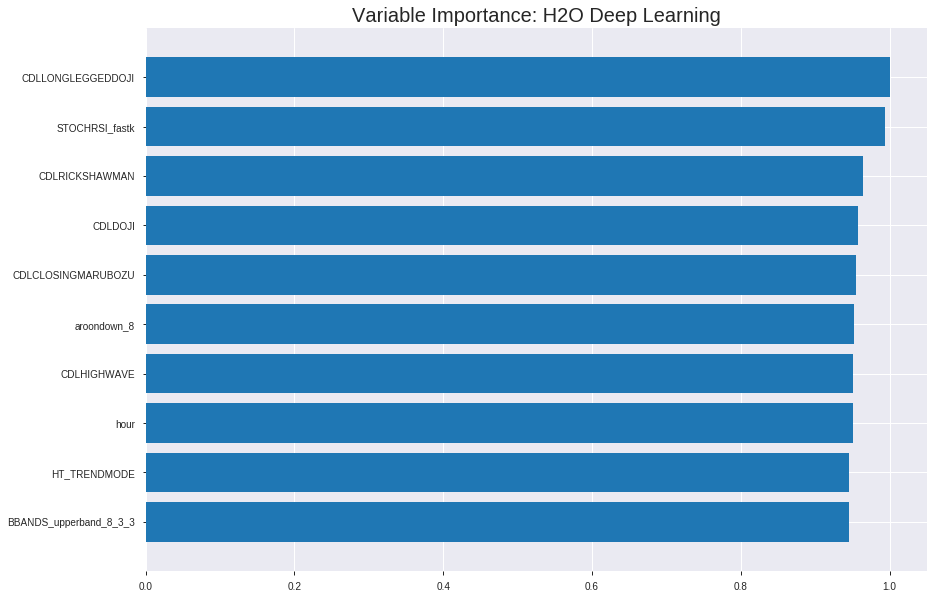

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_132129_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20646314052244275
RMSE: 0.45438215251310515
LogLoss: 0.5839442907946483
Mean Per-Class Error: 0.36969958680484993
AUC: 0.6990745444692813
pr_auc: 0.7150282663135966
Gini: 0.3981490889385626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3782564755960575: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      205  555   0.7303   (555.0/760.0)
1      30   747   0.0386   (30.0/777.0)
Total  235  1302  0.3806   (585.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378256     0.718615  271
max f2                       0.182656     0.858383  325
max f0point5                 0.545785     0.633698  201
max accuracy                 0.545785     0.633051  201
max precision                0.999876     1         0
max recall                   0.0583168    1         368
max specificity              0.999876     1         0
max absolute_mcc             0.378256     0.321091  271
max min_per_class_accuracy   0.575496     0.597368  158
max mean_per_class_accuracy  0.545785     0.6303    201

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 54.17 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0104099                   0.999066           1.97812    1.97812            1                0.999684   1                           0.999684            0.020592        0.020592                   97.8121     97.8121
    2        0.0201692                   0.994903           1.97812    1.97812            1                0.997167   1                           0.998466            0.019305        0.039897                   97.8121     97.8121
    3        0.0305791                   0.987412           1.97812    1.97812            1                0.992274   1                           0.996358            0.020592        0.0604891                  97.8121     97.8121
    4        0.0403383                   0.975117           1.84625    1.94622            0.933333         0.98169    0.983871                    0.99281             0.018018        0.0785071                  84.6246     94.6216
    5        0.0500976                   0.956389           1.97812    1.95243            1                0.965386   0.987013                    0.987467            0.019305        0.0978121                  97.8121     95.2431
    6        0.100195                    0.824541           1.7726     1.86252            0.896104         0.896882   0.941558                    0.942175            0.0888031       0.186615                   77.2602     86.2517
    7        0.150293                    0.648903           1.38725    1.7041             0.701299         0.724161   0.861472                    0.869504            0.0694981       0.256113                   38.7254     70.4096
    8        0.510735                    0.575497           0.999772   1.20703            0.505415         0.579701   0.610191                    0.66498             0.36036         0.616474                   -0.0227664  20.7032
    9        0.59987                     0.56504            1.14067    1.19717            0.576642         0.569053   0.605206                    0.650726            0.101673        0.718147                   14.0668     19.7171
    10       0.700065                    0.556101           1.07898    1.18025            0.545455         0.56068    0.596654                    0.637839            0.108108        0.826255                   7.89751     18.0254
    11       0.79961                     0.501062           0.93088    1.14921            0.470588         0.538866   0.58096                     0.625518            0.0926641       0.918919                   -6.91195    14.9209
    12       0.899805                    0.181656           0.732162   1.10277            0.37013          0.355864   0.557484                    0.595491            0.0733591       0.992278                   -26.7838    10.277
    13       1                           2.80698e-05        0.0770696  1                  0.038961         0.0582699  0.50553                     0.541664            0.00772201      1                          -92.293     0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2821145928620749
RMSE: 0.5311446063569458
LogLoss: 0.8569845559451529
Mean Per-Class Error: 0.4643994635822647
AUC: 0.5109798005196546
pr_auc: 0.5504012730388297
Gini: 0.021959601039309273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0004731399461869966: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00047314   0.717201   349
max f2                       0.00047314   0.863764   349
max f0point5                 0.059291     0.617771   323
max accuracy                 0.059291     0.568182   323
max precision                0.759017     1          0
max recall                   0.00047314   1          349
max specificity              0.759017     1          0
max absolute_mcc             0.00204498   0.0952081  344
max min_per_class_accuracy   0.549288     0.525773   131
max mean_per_class_accuracy  0.533769     0.535601   176

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.697823           1.07317   1.07317            0.6              0.722837  0.6                         0.722837            0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.693828           0         0.596206           0                0.696606  0.333333                    0.711179            0               0.0121951                  -100      -40.3794
    3        0.0318182                   0.668973           0.715447  0.638792           0.4              0.67795   0.357143                    0.699312            0.00813008      0.0203252                  -28.4553  -36.1208
    4        0.0409091                   0.643324           1.34146   0.794941           0.75             0.659373  0.444444                    0.690436            0.0121951       0.0325203                  34.1463   -20.5059
    5        0.05                        0.62823            1.34146   0.894309           0.75             0.633649  0.5                         0.680111            0.0121951       0.0447154                  34.1463   -10.5691
    6        0.1                         0.596748           0.894309  0.894309           0.5              0.613858  0.5                         0.646985            0.0447154       0.0894309                  -10.5691  -10.5691
    7        0.15                        0.578132           0.97561   0.921409           0.545455         0.588242  0.515152                    0.627404            0.0487805       0.138211                   -2.43902  -7.85908
    8        0.370455                    0.575497           1.08792   1.0205             0.608247         0.575603  0.570552                    0.596578            0.239837        0.378049                   8.79222   2.04998
    9        0.4                         0.570943           0.825516  1.0061             0.461538         0.573289  0.5625                      0.594857            0.0243902       0.402439                   -17.4484  0.609756
    10       0.5                         0.550551           1.21951   1.04878            0.681818         0.560684  0.586364                    0.588023            0.121951        0.52439                    21.9512   4.87805
    11       0.6                         0.534718           1.05691   1.05014            0.590909         0.543109  0.587121                    0.580537            0.105691        0.630081                   5.69106   5.01355
    12       0.7                         0.472104           0.894309  1.02787            0.5              0.511636  0.574675                    0.570694            0.0894309       0.719512                   -10.5691  2.78746
    13       0.8                         0.354252           0.813008  1.00102            0.454545         0.416962  0.559659                    0.551478            0.0813008       0.800813                   -18.6992  0.101626
    14       0.9                         0.137437           1.05691   1.00723            0.590909         0.256365  0.563131                    0.518687            0.105691        0.906504                   5.69106   0.722674
    15       1                           0.00047314         0.934959  1                  0.522727         0.050596  0.559091                    0.471878            0.0934959       1                          -6.50407  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:34:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:34:30  6.785 sec         112 obs/sec       0.276513  1             425        0.694814         2.8084              -0.931303      0.533601        0.541538           1.73086          0.49447                          0.717415           2.54162               -1.0879          0.525637          0.577957             1.43089            0.440909
    2019-08-28 13:34:57  33.371 sec        160 obs/sec       2.90046   11            4458       0.604143         1.04801             -0.460133      0.593076        0.601219           1.85449          0.44177                          0.593649           1.0194                -0.429646        0.431261          0.504431             1.07317            0.440909
    2019-08-28 13:35:24  1 min  0.375 sec  196 obs/sec       6.66558   25            10245      0.465801         0.619434            0.132013       0.675397        0.711635           1.97812          0.396226                         0.53504            0.858344              -0.161293        0.461393          0.509905             0.715447           0.440909
    2019-08-28 13:35:50  1 min 26.222 sec  217 obs/sec       10.6662   40            16394      0.454382         0.583944            0.174046       0.699075        0.715028           1.97812          0.380612                         0.531145           0.856985              -0.144443        0.51098           0.550401             1.07317            0.440909
    2019-08-28 13:36:16  1 min 52.642 sec  226 obs/sec       14.6747   55            22555      0.450656         0.575614            0.187538       0.743256        0.755342           1.97812          0.369551                         0.577963           1.1609                -0.355093        0.470413          0.529151             0                  0.440909
    2019-08-28 13:36:43  2 min 19.022 sec  235 obs/sec       18.8946   71            29041      0.560114         0.964877            -0.255063      0.758552        0.793253           1.97812          0.334418                         0.689005           1.98658               -0.925812        0.473975          0.520883             0.357724           0.440909
    2019-08-28 13:37:09  2 min 45.822 sec  241 obs/sec       23.2004   87            35659      0.492298         0.684187            0.0304516      0.777675        0.724087           1.97812          0.324008                         0.581383           1.28362               -0.371176        0.497632          0.53878              0.715447           0.440909
    2019-08-28 13:37:12  2 min 48.628 sec  241 obs/sec       23.2004   87            35659      0.454382         0.583944            0.174046       0.699075        0.715028           1.97812          0.380612                         0.531145           0.856985              -0.144443        0.51098           0.550401             1.07317            0.440909

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLLONGLEGGEDDOJI        1.0                    1.0                  0.001104143024273543
STOCHRSI_fastk           0.99321448802948       0.99321448802948     0.0010966508485651687
CDLRICKSHAWMAN           0.9645420908927917     0.9645420908927917   0.0010649924212774936
CDLDOJI                  0.9576489329338074     0.9576489329338074   0.0010573813890018653
CDLCLOSINGMARUBOZU       0.954260528087616      0.954260528087616    0.0010536401054275285
---                      ---                    ---                  ---
BBANDS_upperband_24_5_5  0.8057671189308167     0.8057671189308167   0.0008896821435564514
AROONOSC_12              0.8049853444099426     0.8049853444099426   0.0008888189526726736
LINEARREG_INTERCEPT_30   0.8046332597732544     0.8046332597732544   0.0008884302008771203
BBANDS_lowerband_8_6_5   0.8001636862754822     0.8001636862754822   0.0008834951524780772
SINH                     0.7991244792938232     0.7991244792938232   0.0008823477193385022


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5909090909090909)

('F1', 0.6804123711340206)

('auc', 0.6095249917245945)

('logloss', 0.8012010339795302)

('mean_per_class_error', 0.40342601787487586)

('rmse', 0.49703208211573374)

('mse', 0.2470408906523015)

deeplearning prediction progress: |███████████████████████████████████████| 100%


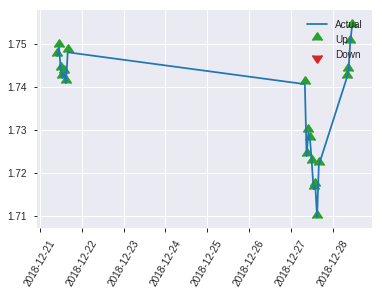


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2470408906523015
RMSE: 0.49703208211573374
LogLoss: 0.8012010339795302
Mean Per-Class Error: 0.40342601787487586
AUC: 0.6095249917245945
pr_auc: 0.5857922310489061
Gini: 0.21904998344918902
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18381625791509024: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      28   86   0.7544   (86.0/114.0)
1      7    99   0.066    (7.0/106.0)
Total  35   185  0.4227   (93.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.183816     0.680412  61
max f2                       8.04706e-05  0.822981  96
max f0point5                 0.367365     0.588608  47
max accuracy                 0.568819     0.590909  16
max precision                0.850826     1         0
max recall                   8.04706e-05  1         96
max specificity              0.850826     1         0
max absolute_mcc             0.183816     0.245321  61
max min_per_class_accuracy   0.575497     0.45614   15
max mean_per_class_accuracy  0.367365     0.596574  47

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 46.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.781789           1.38365   1.38365            0.666667         0.827256   0.666667                    0.827256            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.754763           2.07547   1.66038            1                0.768755   0.8                         0.803855            0.0188679       0.0377358                  107.547   66.0377
    3        0.0318182                   0.742007           0         1.18598            0                0.748017   0.571429                    0.787902            0               0.0377358                  -100      18.5984
    4        0.0409091                   0.703962           2.07547   1.38365            1                0.734796   0.666667                    0.7761              0.0188679       0.0566038                  107.547   38.3648
    5        0.05                        0.625447           2.07547   1.50943            1                0.680542   0.727273                    0.758726            0.0188679       0.0754717                  107.547   50.9434
    6        0.631818                    0.575497           1.11881   1.14972            0.539062         0.576128   0.553957                    0.590578            0.650943        0.726415                   11.8809   14.9722
    7        0.7                         0.454747           0.553459  1.09164            0.266667         0.507101   0.525974                    0.582447            0.0377358       0.764151                   -44.6541  9.16442
    8        0.8                         0.300617           1.22642   1.10849            0.590909         0.394082   0.534091                    0.558901            0.122642        0.886792                   22.6415   10.8491
    9        0.9                         0.129307           0.471698  1.03774            0.227273         0.195441   0.5                         0.518517            0.0471698       0.933962                   -52.8302  3.77358
    10       1                           8.04706e-05        0.660377  1                  0.318182         0.0290898  0.481818                    0.469574            0.0660377       1                          -33.9623  0

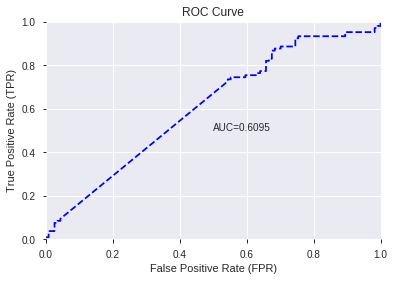

This function is available for GLM models only


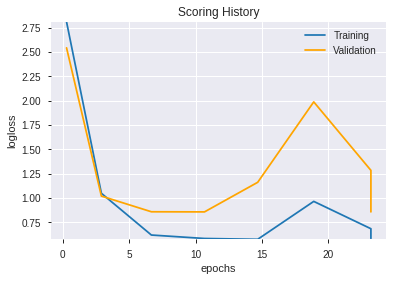

--2019-08-28 13:45:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_132129_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_132129_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastk',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'CDLCLOSINGMARUBOZU',
 'aroondown_8',
 'CDLHIGHWAVE',
 'hour',
 'HT_TRENDMODE',
 'BBANDS_upperband_8_3_3',
 'ROC_20',
 'BOP',
 'ADXR_8',
 'ADX_12',
 'BBANDS_upperband_24_2_4',
 'dayofyear',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_8_4_3',
 'BBANDS_upperband_8_0_4',
 'MFI_8',
 'BBANDS_lowerband_12_0_3',
 'CDLTAKURI',
 'dayofweek',
 'aroonup_30',
 'TRANGE',
 'LINEARREG_SLOPE_14',
 'HT_PHASOR_quadrature',
 'weekday_name',
 'BBANDS_lowerband_8_2_5',
 'ROCP_20',
 'HT_PHASOR_inphase',
 'MAVP_8_0',
 'aroondown_14',
 'CORREL_24',
 'TAN',
 'ATR_12',
 'BETA_20',
 'Open',
 'CDLMORNINGSTAR',
 'BETA_12',
 'BBANDS_lowerband_12_0_5',
 'MA_30_5',
 'BBANDS_middleband_14_7_5',
 'BBANDS_upperband_8_7_5',
 'BBANDS_middleband_12_7_2',
 'SUB',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_24_2_2',
 'is_month_start',
 'CMO_8',
 'LINEARREG_SLOPE_8',
 'BBANDS_middleband_30_7_

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_134514_model_1  0.543942  0.691963              0.495614  0.499408  0.249408

variable  relative_importance  scaled_importance    percentage
0                  CDLLONGLINE         8.588525e-03           1.000000  1.362339e-02
1                    CDLTAKURI         7.232433e-03           0.842104  1.147231e-02
2           CDLCLOSINGMARUBOZU         7.202392e-03           0.838606  1.142466e-02
3                 CDLTHRUSTING         6.767809e-03           0.788006  1.073531e-02
4                   CDL3INSIDE         6.468328e-03           0.753136  1.026026e-02
...                        ...                  ...                ...           ...
1033                     ADX_8         1.388229e-07           0.000016  2.202052e-07
1034                   MA_12_6         1.188331e-07           0.000014  1.884967e-07
1035  BBANDS_middleband_12_6_5         0.000000e+00           0.000000  0.000000e+00
1036  BBANDS_middleband_12_7_5         0.000000e+00           0.000000  0.000000e+00
1037   BBANDS_lowerband_14_0_3         0.000000e+00           0.000000  0.000000e+00

[1038 rows x 4 columns]

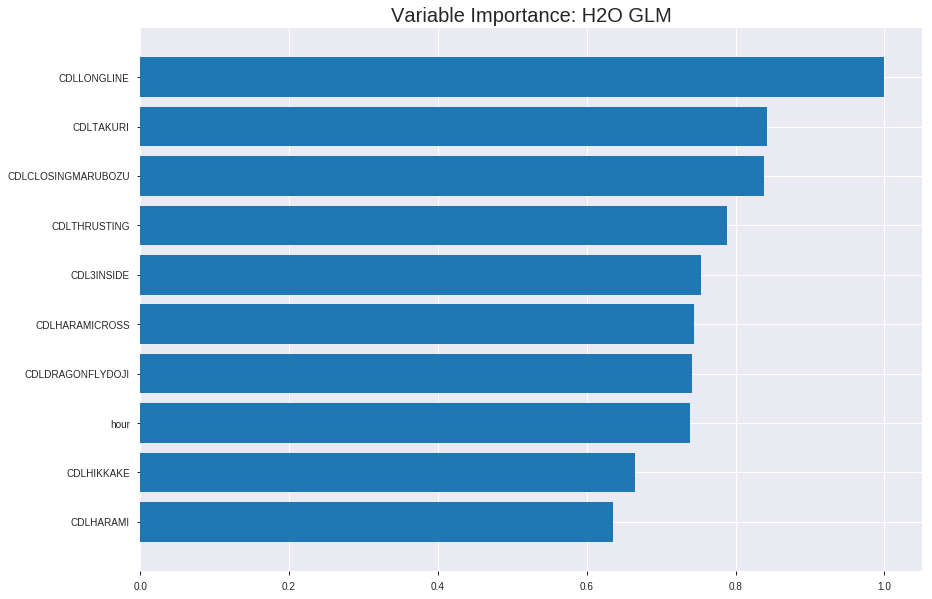

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_134514_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24713681995900721
RMSE: 0.49712857487676887
LogLoss: 0.6874132026161583
Null degrees of freedom: 1536
Residual degrees of freedom: 501
Null deviance: 2130.5464005801423
Residual deviance: 2113.108184842071
AIC: 4185.108184842071
AUC: 0.6020388809862495
pr_auc: 0.5921192597542836
Gini: 0.20407776197249894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4874097559545418: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      127  633   0.8329   (633.0/760.0)
1      49   728   0.0631   (49.0/777.0)
Total  176  1361  0.4437   (682.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48741      0.68101   311
max f2                       0.464918     0.838382  378
max f0point5                 0.495439     0.594685  263
max accuracy                 0.495439     0.578399  263
max precision                0.570383     1         0
max recall                   0.458578     1         390
max specificity              0.570383     1         0
max absolute_mcc             0.490209     0.174932  295
max min_per_class_accuracy   0.506062     0.56242   188
max mean_per_class_accuracy  0.500834     0.576179  228

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.541811           1.60722   1.60722            0.8125           0.548365  0.8125                      0.548365            0.016731        0.016731                   60.7223   60.7223
    2        0.0201692                   0.536484           1.055     1.34002            0.533333         0.539101  0.677419                    0.543883            0.010296        0.027027                   5.49979   34.0017
    3        0.0305791                   0.534486           1.60722   1.43098            0.8125           0.535609  0.723404                    0.541066            0.016731        0.043758                   60.7223   43.0981
    4        0.0403383                   0.531417           1.45062   1.43573            0.733333         0.532863  0.725806                    0.539081            0.014157        0.0579151                  45.0622   43.5733
    5        0.0500976                   0.530721           1.18687   1.38725            0.6              0.531017  0.701299                    0.53751             0.011583        0.0694981                  18.6873   38.7254
    6        0.100195                    0.52583            1.15604   1.27165            0.584416         0.527966  0.642857                    0.532738            0.0579151       0.127413                   15.6045   27.1649
    7        0.150293                    0.521641           1.20742   1.25024            0.61039          0.523678  0.632035                    0.529718            0.0604891       0.187902                   20.7424   25.0241
    8        0.20039                     0.518153           1.07898   1.20742            0.545455         0.519934  0.61039                     0.527272            0.0540541       0.241956                   7.89751   20.7424
    9        0.299935                    0.513581           1.11188   1.17572            0.562092         0.515843  0.59436                     0.523479            0.110682        0.352638                   11.1885   17.5716
    10       0.40013                     0.50999            1.07898   1.15149            0.545455         0.511881  0.582114                    0.520575            0.108108        0.460746                   7.89751   15.1492
    11       0.500325                    0.50593            1.0276    1.12668            0.519481         0.508206  0.569571                    0.518098            0.10296         0.563707                   2.75953   12.668
    12       0.59987                     0.502288           1.0731    1.11779            0.542484         0.504096  0.565076                    0.515774            0.106821        0.670528                   7.30983   11.7789
    13       0.700065                    0.498094           0.98906   1.09936            0.5              0.500332  0.555762                    0.513564            0.0990991       0.769627                   -1.09395  9.93646
    14       0.79961                     0.49295            0.917952  1.07678            0.464052         0.495409  0.544345                    0.511304            0.0913771       0.861004                   -8.20484  7.67803
    15       0.899805                    0.485361           0.847766  1.05128            0.428571         0.489805  0.531453                    0.50891             0.0849421       0.945946                   -15.2234  5.1279
    16       1                           0.438585           0.539488  1                  0.272727         0.475178  0.50553                     0.50553            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24922413209111804
RMSE: 0.4992235291841902
LogLoss: 0.691596374286049
Null degrees of freedom: 439
Residual degrees of freedom: -596
Null deviance: 608.8730098202949
Residual deviance: 608.604809371723
AIC: 2680.604809371723
AUC: 0.5328555862878216
pr_auc: 0.5684802363301438
Gini: 0.06571117257564318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44420414603039526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444204     0.717201  399
max f2                       0.444204     0.863764  399
max f0point5                 0.485457     0.624257  320
max accuracy                 0.485738     0.579545  319
max precision                0.52315      0.606061  29
max recall                   0.444204     1         399
max specificity              0.551958     0.994845  0
max absolute_mcc             0.485738     0.11004   319
max min_per_class_accuracy   0.502972     0.525773  201
max mean_per_class_accuracy  0.491633     0.544485  285

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.53396            1.07317   1.07317            0.6              0.541376  0.6                         0.541376            0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.53209            0.447154  0.794941           0.25             0.532674  0.444444                    0.537509            0.00406504      0.0162602                  -55.2846  -20.5059
    3        0.0318182                   0.528006           0.357724  0.638792           0.2              0.53033   0.357143                    0.534945            0.00406504      0.0203252                  -64.2276  -36.1208
    4        0.0409091                   0.52671            1.34146   0.794941           0.75             0.527066  0.444444                    0.533194            0.0121951       0.0325203                  34.1463   -20.5059
    5        0.05                        0.525186           1.78862   0.97561            1                0.525958  0.545455                    0.531878            0.0162602       0.0487805                  78.8618   -2.43902
    6        0.1                         0.521239           1.13821   1.05691            0.636364         0.523239  0.590909                    0.527558            0.0569106       0.105691                   13.8211   5.69106
    7        0.15                        0.517811           0.894309  1.00271            0.5              0.519688  0.560606                    0.524935            0.0447154       0.150407                   -10.5691  0.271003
    8        0.2                         0.515501           1.13821   1.03659            0.636364         0.516412  0.579545                    0.522804            0.0569106       0.207317                   13.8211   3.65854
    9        0.3                         0.510908           0.853659  0.97561            0.477273         0.513336  0.545455                    0.519648            0.0853659       0.292683                   -14.6341  -2.43902
    10       0.4                         0.507791           1.26016   1.04675            0.704545         0.509488  0.585227                    0.517108            0.126016        0.418699                   26.0163   4.6748
    11       0.5                         0.503174           1.01626   1.04065            0.568182         0.505319  0.581818                    0.51475             0.101626        0.520325                   1.62602   4.06504
    12       0.6                         0.498584           1.01626   1.03659            0.568182         0.500772  0.579545                    0.512421            0.101626        0.621951                   1.62602   3.65854
    13       0.7                         0.493615           1.13821   1.0511             0.636364         0.496304  0.587662                    0.510118            0.113821        0.735772                   13.8211   5.11034
    14       0.8                         0.486345           0.934959  1.03659            0.522727         0.49023   0.579545                    0.507632            0.0934959       0.829268                   -6.50407  3.65854
    15       0.9                         0.477809           0.853659  1.01626            0.477273         0.48302   0.568182                    0.504898            0.0853659       0.914634                   -14.6341  1.62602
    16       1                           0.444204           0.853659  1                  0.477273         0.467542  0.559091                    0.501162    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:45:17  0.000 sec   2            3.4       1036          1.37483           1.38319
    2019-08-28 13:45:19  2.030 sec   4            2.4       1037          1.37166           1.38412
    2019-08-28 13:45:21  4.046 sec   6            1.8       1037          1.36781           1.38587
    2019-08-28 13:45:24  6.203 sec   8            1.3       1038          1.36327           1.38853
    2019-08-28 13:45:26  8.324 sec   10           0.94      1039          1.35803           1.3923
    2019-08-28 13:45:28  10.350 sec  12           0.69      1039          1.35218           1.39744

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5590909090909091)

('F1', 0.6523076923076924)

('auc', 0.5439424031777558)

('logloss', 0.6919628931013033)

('mean_per_class_error', 0.4409963588215823)

('rmse', 0.49940798823195126)

('mse', 0.24940833870988477)

glm prediction progress: |████████████████████████████████████████████████| 100%


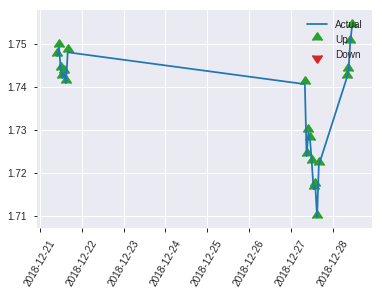


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24940833870988477
RMSE: 0.49940798823195126
LogLoss: 0.6919628931013033
Null degrees of freedom: 219
Residual degrees of freedom: -816
Null deviance: 305.18865009111494
Residual deviance: 304.4636729645735
AIC: 2376.4636729645736
AUC: 0.5439424031777558
pr_auc: 0.5130876335875655
Gini: 0.08788480635551155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4472975928555237: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    113  0.9912   (113.0/114.0)
1      0    106  0        (0.0/106.0)
Total  1    219  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447298     0.652308  218
max f2                       0.447298     0.824261  218
max f0point5                 0.501229     0.548048  139
max accuracy                 0.505109     0.559091  108
max precision                0.522877     0.611111  17
max recall                   0.447298     1         218
max specificity              0.544602     0.991228  0
max absolute_mcc             0.505109     0.117934  108
max min_per_class_accuracy   0.505109     0.556604  108
max mean_per_class_accuracy  0.505109     0.559004  108

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.536103           0.691824  0.691824           0.333333         0.539861  0.333333                    0.539861            0.00943396      0.00943396                 -30.8176  -30.8176
    2        0.0227273                   0.533251           2.07547   1.24528            1                0.534237  0.6                         0.537611            0.0188679       0.0283019                  107.547   24.5283
    3        0.0318182                   0.530536           1.03774   1.18598            0.5              0.532117  0.571429                    0.536041            0.00943396      0.0377358                  3.77358   18.5984
    4        0.0409091                   0.528388           1.03774   1.15304            0.5              0.529641  0.555556                    0.534619            0.00943396      0.0471698                  3.77358   15.304
    5        0.05                        0.527225           1.03774   1.13208            0.5              0.528011  0.545455                    0.533418            0.00943396      0.0566038                  3.77358   13.2075
    6        0.1                         0.521517           1.13208   1.13208            0.545455         0.523569  0.545455                    0.528493            0.0566038       0.113208                   13.2075   13.2075
    7        0.15                        0.517349           1.13208   1.13208            0.545455         0.519329  0.545455                    0.525439            0.0566038       0.169811                   13.2075   13.2075
    8        0.2                         0.515744           1.13208   1.13208            0.545455         0.51645   0.545455                    0.523191            0.0566038       0.226415                   13.2075   13.2075
    9        0.3                         0.511703           0.943396  1.06918            0.454545         0.513892  0.515152                    0.520091            0.0943396       0.320755                   -5.66038  6.91824
    10       0.4                         0.507912           1.22642   1.10849            0.590909         0.510084  0.534091                    0.51759             0.122642        0.443396                   22.6415   10.8491
    11       0.5                         0.505046           1.13208   1.11321            0.545455         0.506104  0.536364                    0.515292            0.113208        0.556604                   13.2075   11.3208
    12       0.6                         0.502396           0.849057  1.06918            0.409091         0.503702  0.515152                    0.513361            0.0849057       0.641509                   -15.0943  6.91824
    13       0.7                         0.499184           0.754717  1.02426            0.363636         0.500799  0.493506                    0.511566            0.0754717       0.716981                   -24.5283  2.42588
    14       0.8                         0.494698           1.03774   1.02594            0.5              0.497351  0.494318                    0.509789            0.103774        0.820755                   3.77358   2.59434
    15       0.9                         0.482682           0.849057  1.00629            0.409091         0.48961   0.484848                    0.507547            0.0849057       0.90566                    -15.0943  0.628931
    16       1                           0.447296           0.943396  1                  0.454545         0.468506  0.481818                    0.503643        

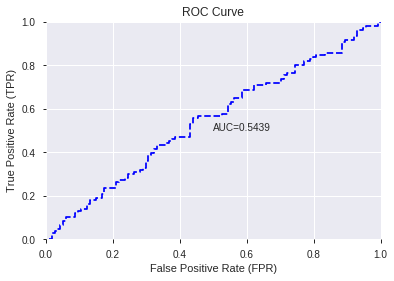

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


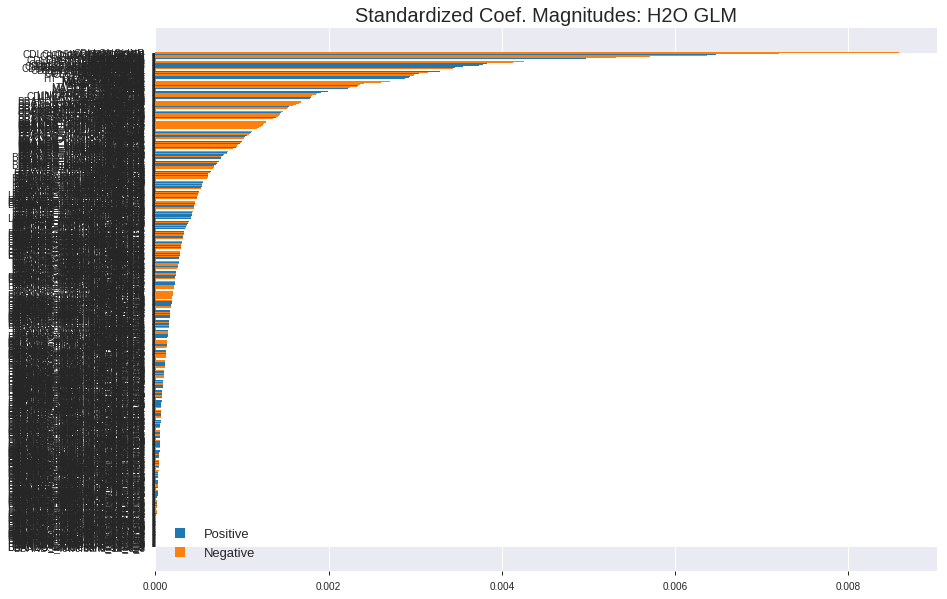

'log_likelihood'
--2019-08-28 13:45:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_134514_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_134514_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLLONGLINE',
 'CDLTAKURI',
 'CDLCLOSINGMARUBOZU',
 'CDLTHRUSTING',
 'CDL3INSIDE',
 'CDLHARAMICROSS',
 'CDLDRAGONFLYDOJI',
 'hour',
 'CDLHIKKAKE',
 'CDLHARAMI',
 'VAR_8',
 'BETA_8',
 'PLUS_DI_30',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'PLUS_DI_24',
 'PLUS_DI_20',
 'STDDEV_8',
 'CDLMARUBOZU',
 'CORREL_8',
 'is_month_end',
 'CDLIDENTICAL3CROWS',
 'aroondown_24',
 'PLUS_DI_14',
 'PLUS_DM_30',
 'SAREXT',
 'CDLSTALLEDPATTERN',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DI_12',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'CDLRISEFALL3METHODS',
 'CDLINNECK',
 'CDLONNECK',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLSHORTLINE',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLHIGHWAVE',
 'STOCHF_fastk',
 'CDLSHOOTINGSTAR',
 'CORREL_14',
 'CDLEVENINGSTAR',
 'PLUS_DM_24',
 'weekofyear',
 'aroonup_30',
 'week',
 'ADX_24',
 'aroondown_20',
 'dayofyear',
 'HT_PHASOR_inphase',
 'STOCH_slowd',
 'PLUS_DI_8',
 'MACDFIX_hist_14',
 'MACDFIX_hist_20',
 'MACDFIX_hist_12',
 'month',
 'MACDFIX_hist_24',
 'M

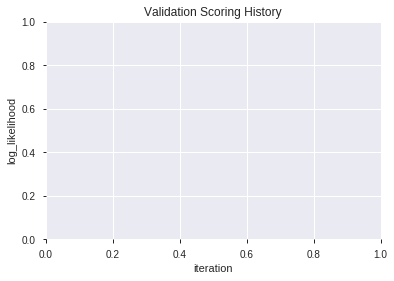

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_134559_model_7  0.541377  0.706171              0.495614  0.506018  0.256054
1               XGBoost_1_AutoML_20190828_134559  0.520275  0.714845              0.475008  0.509911  0.260009
2               XGBoost_3_AutoML_20190828_134559  0.519944  0.708213              0.487173  0.506979  0.257028
3  XGBoost_grid_1_AutoML_20190828_134559_model_6  0.510965  0.728916              0.495614  0.515494  0.265734
4               XGBoost_2_AutoML_20190828_134559  0.492469  0.716190              0.495614  0.510719  0.260834
5  XGBoost_grid_1_AutoML_20190828_134559_model_5  0.486842  0.757645              0.500000  0.527833  0.278608
6  XGBoost_grid_1_AutoML_20190828_134559_model_1  0.478815  0.710229              0.491228  0.508186  0.258253
7  XGBoost_grid_1_AutoML_20190828_134559_model_2  0.477160  0.709578              0.500000  0.507973  0.258037
8  XGBoost_grid_1_AutoML_20190828_134559_model_3  0.466733  0.728374              0.495614  0.516138  0.266399
9  XGBoost_grid_1_AutoML_20190828_134559_model_4  0.462678  0.714054              0.500000  0.510102  0.260204

variable  relative_importance  scaled_importance  percentage
0                        BOP           115.716515           1.000000    0.013467
1                   WILLR_12           106.510223           0.920441    0.012395
2          HT_PHASOR_inphase           100.965485           0.872524    0.011750
3                        DIV           100.581116           0.869203    0.011705
4             STOCHRSI_fastk            97.441010           0.842067    0.011340
..                       ...                  ...                ...         ...
375  BBANDS_upperband_20_5_5             1.549171           0.013388    0.000180
376  BBANDS_upperband_12_6_4             1.317293           0.011384    0.000153
377  BBANDS_upperband_20_3_2             1.202048           0.010388    0.000140
378  BBANDS_upperband_20_5_4             1.051929           0.009091    0.000122
379                    month             0.101665           0.000879    0.000012

[380 rows x 4 columns]

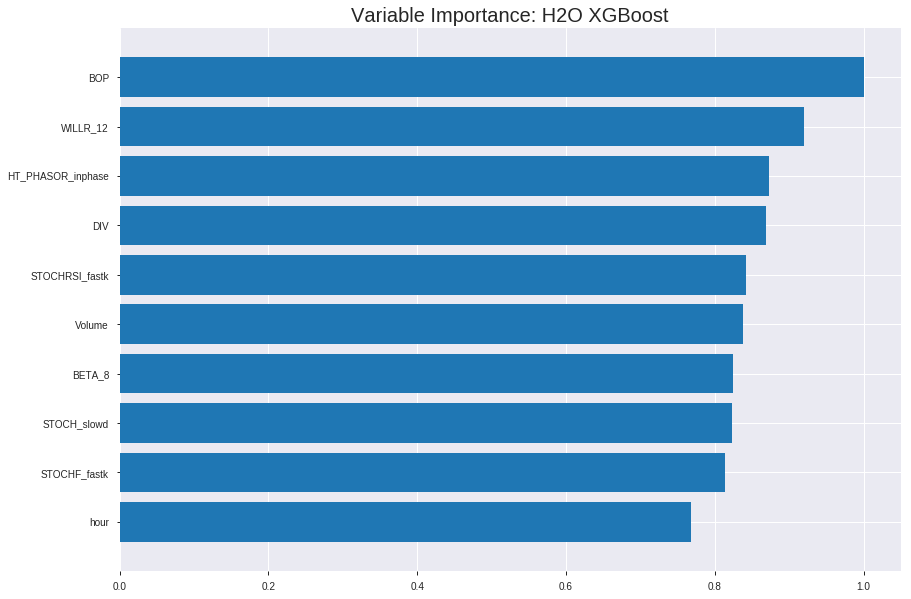

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_134559_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1325649069676646
RMSE: 0.36409464012487824
LogLoss: 0.4457597791890575
Mean Per-Class Error: 0.0514842850369166
AUC: 0.9890232337600758
pr_auc: 0.9879794002754172
Gini: 0.9780464675201517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.501488447189331: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      714  46   0.0605   (46.0/760.0)
1      33   744  0.0425   (33.0/777.0)
Total  747  790  0.0514   (79.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501488     0.949585  201
max f2                       0.483185     0.962859  211
max f0point5                 0.530753     0.955862  184
max accuracy                 0.50381      0.948601  200
max precision                0.879626     1         0
max recall                   0.377726     1         276
max specificity              0.879626     1         0
max absolute_mcc             0.501488     0.897299  201
max min_per_class_accuracy   0.508132     0.944659  197
max mean_per_class_accuracy  0.50381      0.948516  200

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.810235           1.97812    1.97812            1                0.83394   1                           0.83394             0.020592        0.020592                   97.8121   97.8121
    2        0.0201692                   0.792982           1.97812    1.97812            1                0.798938  1                           0.817003            0.019305        0.039897                   97.8121   97.8121
    3        0.0305791                   0.782307           1.97812    1.97812            1                0.787577  1                           0.806986            0.020592        0.0604891                  97.8121   97.8121
    4        0.0403383                   0.770416           1.97812    1.97812            1                0.774485  1                           0.799123            0.019305        0.0797941                  97.8121   97.8121
    5        0.0500976                   0.761665           1.97812    1.97812            1                0.76733   1                           0.792929            0.019305        0.0990991                  97.8121   97.8121
    6        0.100195                    0.7258             1.97812    1.97812            1                0.741269  1                           0.767099            0.0990991       0.198198                   97.8121   97.8121
    7        0.150293                    0.69685            1.97812    1.97812            1                0.710788  1                           0.748329            0.0990991       0.297297                   97.8121   97.8121
    8        0.20039                     0.675468           1.97812    1.97812            1                0.686017  1                           0.732751            0.0990991       0.396396                   97.8121   97.8121
    9        0.299935                    0.635477           1.96519    1.97383            0.993464         0.655423  0.997831                    0.707087            0.195624        0.592021                   96.5192   97.383
    10       0.40013                     0.585665           1.93959    1.96526            0.980519         0.610654  0.993496                    0.682939            0.194337        0.786358                   93.9586   96.5255
    11       0.500325                    0.510711           1.50286    1.87266            0.75974          0.548741  0.946684                    0.656065            0.150579        0.936937                   50.2858   87.2655
    12       0.59987                     0.436946           0.555942   1.65416            0.281046         0.471657  0.836226                    0.625463            0.0553411       0.992278                   -44.4058  65.4155
    13       0.700065                    0.376782           0.0770696  1.42844            0.038961         0.404468  0.722119                    0.593834            0.00772201      1                          -92.293   42.8439
    14       0.79961                     0.330144           0          1.25061            0                0.353789  0.632221                    0.56395             0               1                          -100      25.061
    15       0.899805                    0.282821           0          1.11135            0                0.307152  0.561822                    0.535355            0               1                          -100      11.1352
    16       1                           0.144698           0          1                  0                0.239833  0.50553                     0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2746695428610839
RMSE: 0.5240892508543596
LogLoss: 0.7455521771861873
Mean Per-Class Error: 0.48575140390579163
AUC: 0.4625869583438102
pr_auc: 0.5451725065552172
Gini: -0.07482608331237961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24236106872558594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    192  0.9897   (192.0/194.0)
1      1    245  0.0041   (1.0/246.0)
Total  3    437  0.4386   (193.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.242361     0.717423   396
max f2                       0.189589     0.863764   399
max f0point5                 0.242361     0.614343   396
max accuracy                 0.242361     0.561364   396
max precision                0.785547     1          0
max recall                   0.189589     1          399
max specificity              0.785547     1          0
max absolute_mcc             0.447723     0.0971419  221
max min_per_class_accuracy   0.46592      0.474227   200
max mean_per_class_accuracy  0.562313     0.514249   88

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 46.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.736741           1.43089   1.43089            0.8              0.759494  0.8                         0.759494            0.0162602       0.0162602                  43.0894   43.0894
    2        0.0204545                   0.70536            0.894309  1.19241            0.5              0.724721  0.666667                    0.74404             0.00813008      0.0243902                  -10.5691  19.2412
    3        0.0318182                   0.689002           0         0.766551           0                0.695988  0.428571                    0.726878            0               0.0243902                  -100      -23.3449
    4        0.0409091                   0.665809           0.894309  0.794941           0.5              0.675365  0.444444                    0.715431            0.00813008      0.0325203                  -10.5691  -20.5059
    5        0.05                        0.65127            1.78862   0.97561            1                0.662166  0.545455                    0.705746            0.0162602       0.0487805                  78.8618   -2.43902
    6        0.1                         0.61923            0.894309  0.934959           0.5              0.635969  0.522727                    0.670858            0.0447154       0.0934959                  -10.5691  -6.50407
    7        0.15                        0.597866           1.30081   1.05691            0.727273         0.606307  0.590909                    0.649341            0.0650407       0.158537                   30.0813   5.69106
    8        0.2                         0.571724           1.05691   1.05691            0.590909         0.582353  0.590909                    0.632594            0.0528455       0.211382                   5.69106   5.69106
    9        0.3                         0.534874           0.813008  0.97561            0.454545         0.554231  0.545455                    0.606473            0.0813008       0.292683                   -18.6992  -2.43902
    10       0.4                         0.499371           0.731707  0.914634           0.409091         0.517884  0.511364                    0.584326            0.0731707       0.365854                   -26.8293  -8.53659
    11       0.5                         0.464473           1.09756   0.95122            0.613636         0.480607  0.531818                    0.563582            0.109756        0.47561                    9.7561    -4.87805
    12       0.6                         0.431728           0.97561   0.955285           0.545455         0.449835  0.534091                    0.544624            0.097561        0.573171                   -2.43902  -4.47154
    13       0.7                         0.400504           0.97561   0.958188           0.545455         0.414472  0.535714                    0.526031            0.097561        0.670732                   -2.43902  -4.18118
    14       0.8                         0.361093           1.13821   0.980691           0.636364         0.38264   0.548295                    0.508107            0.113821        0.784553                   13.8211   -1.93089
    15       0.9                         0.317662           1.01626   0.984643           0.568182         0.338668  0.550505                    0.489281            0.101626        0.886179                   1.62602   -1.53568
    16       1                           0.189589           1.13821   1                  0.636364         0.282044  0.559091                    0.4685


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:46:44  28.586 sec  0                  0.5              0.693147            0.5             0                  1                0.49447                          0.5                0.693147              0.5               0                    1                  0.440909
    2019-08-28 13:46:46  29.760 sec  5                  0.481148         0.65603             0.837337        0.832295           1.97812          0.256344                         0.5049             0.70303               0.438836          0.524545             0.715447           0.440909
    2019-08-28 13:46:46  30.017 sec  10                 0.462795         0.620874            0.895075        0.888332           1.97812          0.182173                         0.507619           0.708675              0.43826           0.522728             0.715447           0.440909
    2019-08-28 13:46:46  30.266 sec  15                 0.449444         0.595751            0.917347        0.911033           1.97812          0.162004                         0.508869           0.711321              0.442838          0.524827             1.07317            0.440909
    2019-08-28 13:46:46  30.509 sec  20                 0.436455         0.571779            0.938339        0.935532           1.97812          0.138582                         0.509375           0.712343              0.451942          0.534693             1.43089            0.440909
    2019-08-28 13:46:47  30.770 sec  25                 0.422245         0.54588             0.948019        0.946234           1.97812          0.121015                         0.512542           0.719085              0.458522          0.539737             1.43089            0.438636
    2019-08-28 13:46:47  31.034 sec  30                 0.409286         0.522862            0.96113         0.961755           1.97812          0.103448                         0.517779           0.730492              0.452026          0.532622             1.43089            0.436364
    2019-08-28 13:46:47  31.304 sec  35                 0.396999         0.501342            0.971361        0.971436           1.97812          0.085231                         0.519764           0.734999              0.450371          0.535518             1.43089            0.438636
    2019-08-28 13:46:47  31.568 sec  40                 0.385459         0.481427            0.978307        0.97806            1.97812          0.0702668                        0.520908           0.737933              0.458187          0.540024             1.07317            0.440909
    2019-08-28 13:46:48  31.825 sec  45                 0.374574         0.463178            0.984619        0.983567           1.97812          0.0624593                        0.522939           0.742574              0.459245          0.541059             1.43089            0.436364
    2019-08-28 13:46:48  32.106 sec  50                 0.364095         0.44576             0.989023        0.987979           1.97812          0.0513988                        0.524089           0.745552              0.462587          0.545173             1.43089            0.438636

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      115.71651458740234     1.0                    0.013466615030095618
WILLR_12                 106.51022338867188     0.9204409912314043     0.012395224486832938
HT_PHASOR_inphase        100.96548461914062     0.8725244186548666     0.011749950450383068
DIV                      100.58111572265625     0.8692027761230735     0.011705219169139818
STOCHRSI_fastk           97.44100952148438      0.8420665785598458     0.011339786443175211
---                      ---                    ---                    ---
BBANDS_upperband_20_5_5  1.5491714477539062     0.013387643529340791   0.00018028624156978305
BBANDS_upperband_12_6_4  1.3172931671142578     0.011383795751290861   0.00015330119496387214
BBANDS_upperband_20_3_2  1.2020478248596191     0.010387867532526613   0.00013988941304416517
BBANDS_upperband_20_5_4  1.0519294738769531     0.009090573438265942   0.00012241925289594013
month                    0.10166490077972412    0.0008785686394221212  1.1831345644612594e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5772727272727273)

('F1', 0.6523076923076924)

('auc', 0.5413770274743462)

('logloss', 0.7061710636599492)

('mean_per_class_error', 0.4277557100297915)

('rmse', 0.506017874396863)

('mse', 0.25605408920911943)

xgboost prediction progress: |████████████████████████████████████████████| 100%


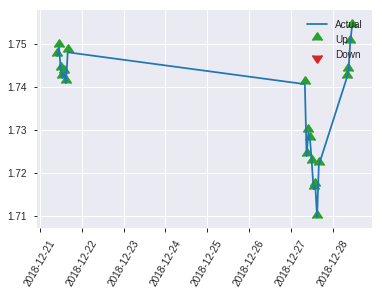


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25605408920911943
RMSE: 0.506017874396863
LogLoss: 0.7061710636599492
Mean Per-Class Error: 0.4277557100297915
AUC: 0.5413770274743462
pr_auc: 0.5496229341776983
Gini: 0.08275405494869248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21649296581745148: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    113  0.9912   (113.0/114.0)
1      0    106  0        (0.0/106.0)
Total  1    219  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.216493     0.652308  218
max f2                       0.216493     0.824261  218
max f0point5                 0.466379     0.54918   125
max accuracy                 0.550512     0.577273  78
max precision                0.805349     1         0
max recall                   0.216493     1         218
max specificity              0.805349     1         0
max absolute_mcc             0.748647     0.21418   8
max min_per_class_accuracy   0.499937     0.537736  107
max mean_per_class_accuracy  0.550512     0.572244  78

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.786299           2.07547   2.07547            1                0.797383  1                           0.797383            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.756186           2.07547   2.07547            1                0.758746  1                           0.781928            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.750482           2.07547   2.07547            1                0.752695  1                           0.773576            0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.743266           2.07547   2.07547            1                0.748965  1                           0.768106            0.0188679       0.0849057                  107.547   107.547
    5        0.05                        0.727647           0         1.69811            0                0.737351  0.818182                    0.762515            0               0.0849057                  -100      69.8113
    6        0.1                         0.691554           0.943396  1.32075            0.454545         0.707642  0.636364                    0.735078            0.0471698       0.132075                   -5.66038  32.0755
    7        0.15                        0.653118           0.377358  1.00629            0.181818         0.669609  0.484848                    0.713255            0.0188679       0.150943                   -62.2642  0.628931
    8        0.2                         0.623429           0.754717  0.943396           0.363636         0.637858  0.454545                    0.694406            0.0377358       0.188679                   -24.5283  -5.66038
    9        0.3                         0.575891           1.41509   1.10063            0.681818         0.598192  0.530303                    0.662334            0.141509        0.330189                   41.5094   10.0629
    10       0.4                         0.534937           1.32075   1.15566            0.636364         0.552957  0.556818                    0.63499             0.132075        0.462264                   32.0755   15.566
    11       0.5                         0.491351           0.754717  1.07547            0.363636         0.517414  0.518182                    0.611475            0.0754717       0.537736                   -24.5283  7.54717
    12       0.6                         0.454001           1.03774   1.06918            0.5              0.472846  0.515152                    0.58837             0.103774        0.641509                   3.77358   6.91824
    13       0.7                         0.430219           0.660377  1.01078            0.318182         0.442227  0.487013                    0.567492            0.0660377       0.707547                   -33.9623  1.07817
    14       0.8                         0.396007           0.943396  1.00236            0.454545         0.411975  0.482955                    0.548053            0.0943396       0.801887                   -5.66038  0.235849
    15       0.9                         0.359175           1.03774   1.00629            0.5              0.376429  0.484848                    0.528983            0.103774        0.90566                    3.77358   0.628931
    16       1                           0.214193           0.943396  1                  0.454545         0.310434  0.481818                    0.507129      

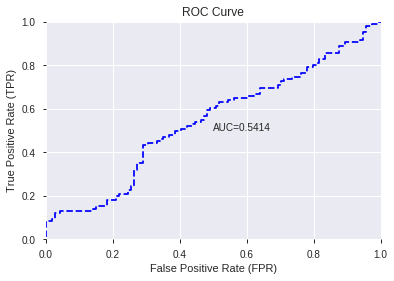

This function is available for GLM models only


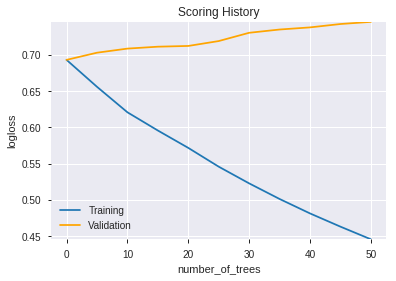

--2019-08-28 13:46:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.220
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_134559_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_134559_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'WILLR_12',
 'HT_PHASOR_inphase',
 'DIV',
 'STOCHRSI_fastk',
 'Volume',
 'BETA_8',
 'STOCH_slowd',
 'STOCHF_fastk',
 'hour',
 'ADOSC',
 'CORREL_20',
 'CORREL_8',
 'CORREL_14',
 'CORREL_24',
 'CCI_14',
 'PLUS_DM_8',
 'BETA_24',
 'MOM_20',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'DX_14',
 'STOCH_slowk',
 'MFI_30',
 'BETA_12',
 'PLUS_DI_30',
 'CMO_12',
 'CCI_8',
 'ADXR_12',
 'BETA_30',
 'CORREL_12',
 'PLUS_DI_8',
 'CORREL_30',
 'BETA_14',
 'HT_PHASOR_quadrature',
 'DX_24',
 'MACDFIX_hist_20',
 'MACDEXT_hist',
 'TRANGE',
 'ULTOSC',
 'ROC_30',
 'aroondown_24',
 'STDDEV_8',
 'MACDEXT_signal',
 'ADXR_8',
 'MFI_14',
 'SUB',
 'PLUS_DM_24',
 'WILLR_8',
 'STDDEV_12',
 'NATR_12',
 'MINUS_DI_12',
 'CMO_8',
 'PLUS_DI_20',
 'aroondown_12',
 'BETA_20',
 'aroondown_20',
 'ADX_12',
 'MFI_12',
 'WILLR_20',
 'SAREXT',
 'ROC_8',
 'MFI_24',
 'MINUS_DM_20',
 'PLUS_DI_12',
 'STDDEV_24',
 'dayofyear',
 'LINEARREG_ANGLE_8',
 'ADX_24',
 'MOM_8',
 'STDDEV_30',
 'MINUS_DM_12',
 'DX_20',
 'MOM_14',
 'CCI_12',


In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

1033

['Volume',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'hour',
 'is_month_end',
 'is_month_start',
 'is_quarter_start',
 'month',
 'quarter',
 'week',
 'weekday',
 'weekday_name',
 'weekofyear',
 'mama',
 'fama',
 'SAREXT',
 'DEMA_8',
 'EMA_8',
 'KAMA_8',
 'MIDPOINT_8',
 'MIDPRICE_8',
 'SAR_0.08',
 'SMA_8',
 'TEMA_8',
 'TRIMA_8',
 'WMA_8',
 'MA_8_0',
 'MAVP_8_0',
 'T3_8_0',
 'BBANDS_upperband_8_0_2',
 'BBANDS_middleband_8_0_2',
 'BBANDS_lowerband_8_0_2',
 'BBANDS_upperband_8_0_3',
 'BBANDS_middleband_8_0_3',
 'BBANDS_lowerband_8_0_3',
 'BBANDS_upperband_8_0_4',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_middleband_8_0_5',
 'BBANDS_lowerband_8_0_5',
 'MA_8_1',
 'MAVP_8_1',
 'T3_8_1',
 'BBANDS_upperband_8_1_2',
 'BBANDS_middleband_8_1_2',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_upperband_8_1_3',
 'BBANDS_middleband_8_1_3',
 'BBANDS_lowerband_8_1_3',
 'BBANDS_upperband_8_1_4',
 'BBANDS_middleband_8_1_4',
 'BBANDS_lowerband_8_1_4',
 'B

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_134755_model_4  0.595498  1.661922              0.483118  0.628519  0.395036
1  DeepLearning_grid_1_AutoML_20190828_134755_model_3  0.595415  0.960801              0.453409  0.569506  0.324337
2  DeepLearning_grid_1_AutoML_20190828_134755_model_2  0.560493  0.821106              0.491228  0.547915  0.300211
3  DeepLearning_grid_1_AutoML_20190828_134755_model_5  0.560410  0.692357              0.428418  0.499761  0.249761
4               DeepLearning_1_AutoML_20190828_134755  0.558507  0.715418              0.437190  0.500737  0.250738
5  DeepLearning_grid_1_AutoML_20190828_134755_model_1  0.549032  3.162547              0.495614  0.654969  0.428984
6  DeepLearning_grid_1_AutoML_20190828_134755_model_8  0.500000  0.697587              0.500000  0.502211  0.252216
7  DeepLearning_grid_1_AutoML_20190828_134755_model_6  0.495283  0.699449              0.495614  0.503132  0.253142
8  DeepLearning_grid_1_AutoML_20190828_134755_model_7  0.475339  0.812281              0.483449  0.538545  0.290031
9  DeepLearning_grid_1_AutoML_20190828_134755_model_9  0.442610  0.699727              0.491228  0.503269  0.253280

variable  relative_importance  scaled_importance  percentage
0                   CDLINNECK             1.000000           1.000000    0.002342
1           CDL3WHITESOLDIERS             0.966178           0.966178    0.002263
2          CDLEVENINGDOJISTAR             0.965011           0.965011    0.002260
3             CDLLADDERBOTTOM             0.941459           0.941459    0.002205
4         CDLGAPSIDESIDEWHITE             0.940752           0.940752    0.002204
...                       ...                  ...                ...         ...
1027                   WMA_24             0.370515           0.370515    0.000868
1028  BBANDS_upperband_24_2_2             0.367706           0.367706    0.000861
1029  BBANDS_lowerband_14_0_3             0.366700           0.366700    0.000859
1030  BBANDS_upperband_30_1_3             0.366508           0.366508    0.000858
1031  BBANDS_lowerband_30_5_5             0.366275           0.366275    0.000858

[1032 rows x 4 columns]

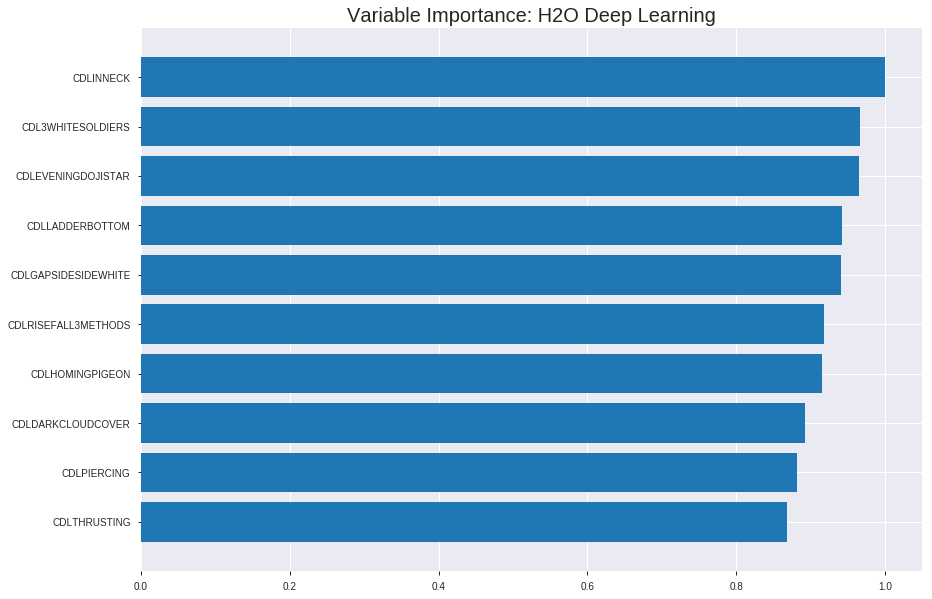

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_134755_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28351737849050673
RMSE: 0.5324634996790923
LogLoss: 0.9904914775253352
Mean Per-Class Error: 0.3240228950755266
AUC: 0.6963972431077695
pr_auc: 0.677096974868198
Gini: 0.39279448621553903
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7415069213435256: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      468  292  0.3842   (292.0/760.0)
1      205  572  0.2638   (205.0/777.0)
Total  673  864  0.3234   (497.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.741507     0.697136  150
max f2                       0.00653621   0.836924  398
max f0point5                 0.84057      0.681018  105
max accuracy                 0.741507     0.676643  150
max precision                0.999902     1         0
max recall                   0.00653621   1         398
max specificity              0.999902     1         0
max absolute_mcc             0.741507     0.354682  150
max min_per_class_accuracy   0.814195     0.671815  117
max mean_per_class_accuracy  0.741507     0.675977  150

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 64.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.998717           1.73086   1.73086            0.875            0.999393   0.875                       0.999393            0.018018        0.018018                   73.0856   73.0856
    2        0.0201692                   0.99775            1.45062   1.59526            0.733333         0.998176   0.806452                    0.998804            0.014157        0.032175                   45.0622   59.5259
    3        0.0305791                   0.996904           1.73086   1.64142            0.875            0.997226   0.829787                    0.998267            0.018018        0.0501931                  73.0856   64.142
    4        0.0403383                   0.995935           1.5825    1.62716            0.8              0.996355   0.822581                    0.997804            0.015444        0.0656371                  58.2497   62.7164
    5        0.0500976                   0.995326           1.5825    1.61846            0.8              0.995609   0.818182                    0.997377            0.015444        0.0810811                  58.2497   61.8463
    6        0.100195                    0.991497           1.33587   1.47717            0.675325         0.993622   0.746753                    0.995499            0.0669241       0.148005                   33.5874   47.7168
    7        0.150293                    0.985633           1.31018   1.42151            0.662338         0.988858   0.718615                    0.993285            0.0656371       0.213642                   31.0184   42.1507
    8        0.20039                     0.976225           1.31018   1.39368            0.662338         0.981331   0.704545                    0.990297            0.0656371       0.279279                   31.0184   39.3676
    9        0.299935                    0.947342           1.44804   1.41172            0.732026         0.963516   0.713666                    0.981409            0.144144        0.423423                   44.8036   41.1718
    10       0.40013                     0.89852            1.32303   1.38951            0.668831         0.926666   0.702439                    0.967701            0.132561        0.555985                   32.3029   38.9509
    11       0.500325                    0.814214           1.1432    1.34018            0.577922         0.861817   0.677503                    0.946496            0.114543        0.670528                   14.32     34.0183
    12       0.59987                     0.667269           0.892094  1.26583            0.45098          0.749162   0.639913                    0.91375             0.0888031       0.759331                   -10.7906  26.5826
    13       0.700065                    0.42785            0.629402  1.17474            0.318182         0.546989   0.593866                    0.861258            0.0630631       0.822394                   -37.0598  17.4739
    14       0.79961                     0.160677           0.374938  1.07517            0.189542         0.278388   0.543531                    0.788696            0.037323        0.859717                   -62.5062  7.51707
    15       0.899805                    0.0493033          0.770696  1.04127            0.38961          0.0934747  0.526392                    0.711281            0.0772201       0.936937                   -22.9304  4.12669
    16       1                           0.00467767         0.629402  1                  0.318182         0.0278096  0.50553                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3265946381725401
RMSE: 0.5714845913693037
LogLoss: 1.0191304679327995
Mean Per-Class Error: 0.4635822646886263
AUC: 0.5122894141312547
pr_auc: 0.5757141920935512
Gini: 0.024578828262509456
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.017362347133487298: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    192  0.9897   (192.0/194.0)
1      1    245  0.0041   (1.0/246.0)
Total  3    437  0.4386   (193.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0173623    0.717423   396
max f2                       0.00312204   0.863764   399
max f0point5                 0.0173623    0.614343   396
max accuracy                 0.147943     0.561364   375
max precision                0.992075     0.75       6
max recall                   0.00312204   1          399
max specificity              0.999984     0.994845   0
max absolute_mcc             0.968493     0.0774798  32
max min_per_class_accuracy   0.679256     0.510309   198
max mean_per_class_accuracy  0.800954     0.536418   137

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 61.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.994848           1.07317   1.07317            0.6              0.997851  0.6                         0.997851            0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.990645           1.34146   1.19241            0.75             0.992772  0.666667                    0.995593            0.0121951       0.0243902                  34.1463   19.2412
    3        0.0318182                   0.985397           1.07317   1.14983            0.6              0.98903   0.642857                    0.993249            0.0121951       0.0365854                  7.31707   14.9826
    4        0.0409091                   0.981724           0.894309  1.09304            0.5              0.982967  0.611111                    0.990964            0.00813008      0.0447154                  -10.5691  9.30443
    5        0.05                        0.978842           0.894309  1.05691            0.5              0.980934  0.590909                    0.989141            0.00813008      0.0528455                  -10.5691  5.69106
    6        0.1                         0.962588           1.30081   1.17886            0.727273         0.971746  0.659091                    0.980444            0.0650407       0.117886                   30.0813   17.8862
    7        0.15                        0.937691           0.650407  1.00271            0.363636         0.948563  0.560606                    0.969817            0.0325203       0.150407                   -34.9593  0.271003
    8        0.2                         0.908436           1.21951   1.05691            0.681818         0.922276  0.590909                    0.957932            0.0609756       0.211382                   21.9512   5.69106
    9        0.3                         0.835976           1.09756   1.07046            0.613636         0.87425   0.598485                    0.930038            0.109756        0.321138                   9.7561    7.04607
    10       0.4                         0.752749           0.894309  1.02642            0.5              0.799074  0.573864                    0.897297            0.0894309       0.410569                   -10.5691  2.64228
    11       0.5                         0.679578           0.97561   1.01626            0.545455         0.718501  0.568182                    0.861538            0.097561        0.50813                    -2.43902  1.62602
    12       0.6                         0.53542            0.934959  1.00271            0.522727         0.610942  0.560606                    0.819772            0.0934959       0.601626                   -6.50407  0.271003
    13       0.7                         0.451904           0.853659  0.981417           0.477273         0.49083   0.548701                    0.77278             0.0853659       0.686992                   -14.6341  -1.8583
    14       0.8                         0.308648           1.17886   1.0061             0.659091         0.391682  0.5625                      0.725143            0.117886        0.804878                   17.8862   0.609756
    15       0.9                         0.189325           0.853659  0.98916            0.477273         0.244697  0.55303                     0.67176             0.0853659       0.890244                   -14.6341  -1.08401
    16       1                           0.00312204         1.09756   1                  0.613636         0.120203  0.559091                    0.616604     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:53:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:54:00  5.922 sec         145 obs/sec       0.330514  1             508        0.655277         2.55396             -0.717762      0.519683        0.4757             0.98906          0.49447                          0.637151           2.01727               -0.646848        0.544254          0.600623             1.07317            0.440909
    2019-08-28 13:54:22  27.872 sec        150 obs/sec       2.26871   7             3487       0.641075         2.69077             -0.64411       0.533458        0.476355           1.23633          0.49447                          0.644635           1.99256               -0.685762        0.525501          0.59751              1.43089            0.440909
    2019-08-28 13:54:45  50.447 sec        159 obs/sec       4.52245   14            6951       0.620319         1.85557             -0.539372      0.558597        0.499175           1.35996          0.487313                         0.628488           1.39105               -0.602369        0.501058          0.54519              0.715447           0.440909
    2019-08-28 13:55:09  1 min 14.357 sec  166 obs/sec       7.10215   22            10916      0.563632         1.21584             -0.270878      0.64092         0.585934           1.23633          0.472999                         0.599428           1.40369               -0.457613        0.520901          0.553552             0.715447           0.436364
    2019-08-28 13:55:32  1 min 37.166 sec  173 obs/sec       9.69941   30            14908      0.532416         1.20408             -0.134004      0.66611         0.57089            1.11269          0.377358                         0.579913           1.05151               -0.364252        0.502734          0.554707             1.07317            0.440909
    2019-08-28 13:55:56  2 min  1.549 sec  178 obs/sec       12.6038   39            19372      0.479738         0.706023            0.0792932      0.729129        0.708922           1.97812          0.338972                         0.604893           1.14584               -0.484311        0.496281          0.554986             1.07317            0.436364
    2019-08-28 13:56:20  2 min 25.142 sec  184 obs/sec       15.568    48            23928      0.532463         0.990491            -0.134208      0.696397        0.677097           1.73086          0.323357                         0.571485           1.01913               -0.324883        0.512289          0.575714             1.07317            0.438636
    2019-08-28 13:56:42  2 min 47.660 sec  189 obs/sec       18.4684   57            28386      0.465653         0.667959            0.132563       0.769534        0.770746           1.97812          0.321405                         0.642255           1.4828                -0.673339        0.461351          0.539996             0.715447           0.438636
    2019-08-28 13:57:05

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLINNECK                1.0                    1.0                  0.0023422801477539657
CDL3WHITESOLDIERS        0.9661783576011658     0.9661783576011658   0.0022630603861987426
CDLEVENINGDOJISTAR       0.9650108218193054     0.9650108218193054   0.0022603256903150986
CDLLADDERBOTTOM          0.9414589405059814     0.9414589405059814   0.0022051605862726423
CDLGAPSIDESIDEWHITE      0.9407520294189453     0.9407520294189453   0.0022035048024672504
---                      ---                    ---                  ---
WMA_24                   0.37051549553871155    0.37051549553871155  0.000867851089635547
BBANDS_upperband_24_2_2  0.3677063584327698     0.3677063584327698   0.0008612713035599806
BBANDS_lowerband_14_0_3  0.36670032143592834    0.36670032143592834  0.000858914883074373
BBANDS_upperband_30_1_3  0.36650753021240234    0.36650753021240234  0.0008584633120188468
BBANDS_lowerband_30_5_5  0.36627525091171265    0.36627525091171265  0.0008579192488241071


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6227272727272727)

('F1', 0.6540880503144654)

('auc', 0.5954981794107912)

('logloss', 1.6619221850891028)

('mean_per_class_error', 0.380254882489242)

('rmse', 0.6285185548219197)

('mse', 0.39503557375543447)

deeplearning prediction progress: |███████████████████████████████████████| 100%


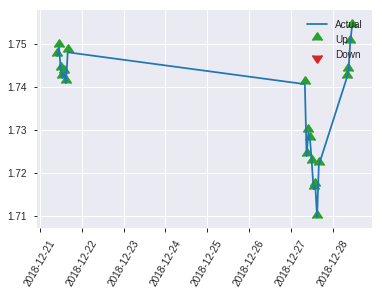


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.39503557375543447
RMSE: 0.6285185548219197
LogLoss: 1.6619221850891028
Mean Per-Class Error: 0.380254882489242
AUC: 0.5954981794107912
pr_auc: 0.5554120909189222
Gini: 0.1909963588215824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2505962262262541: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    108  0.9474   (108.0/114.0)
1      2    104  0.0189   (2.0/106.0)
Total  8    212  0.5      (110.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250596     0.654088  211
max f2                       0.0638501    0.822981  219
max f0point5                 0.988462     0.606383  90
max accuracy                 0.989        0.622727  88
max precision                0.999998     1         0
max recall                   0.0638501    1         219
max specificity              0.999998     1         0
max absolute_mcc             0.989        0.243142  88
max min_per_class_accuracy   0.969627     0.59434   108
max mean_per_class_accuracy  0.988462     0.619745  90

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 81.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.999871           1.38365   1.38365            0.666667         0.999977  0.666667                    0.999977            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.999178           1.03774   1.24528            0.5              0.999365  0.6                         0.999732            0.00943396      0.0283019                  3.77358   24.5283
    3        0.0318182                   0.99899            2.07547   1.48248            1                0.999103  0.714286                    0.999553            0.0188679       0.0471698                  107.547   48.248
    4        0.0409091                   0.998644           1.03774   1.38365            0.5              0.998899  0.666667                    0.999407            0.00943396      0.0566038                  3.77358   38.3648
    5        0.05                        0.998256           1.03774   1.32075            0.5              0.998435  0.636364                    0.999231            0.00943396      0.0660377                  3.77358   32.0755
    6        0.1                         0.997284           0.943396  1.13208            0.454545         0.997921  0.545455                    0.998576            0.0471698       0.113208                   -5.66038  13.2075
    7        0.15                        0.9966             1.13208   1.13208            0.545455         0.99698   0.545455                    0.998044            0.0566038       0.169811                   13.2075   13.2075
    8        0.2                         0.995427           1.50943   1.22642            0.727273         0.995958  0.590909                    0.997522            0.0754717       0.245283                   50.9434   22.6415
    9        0.3                         0.992375           1.50943   1.32075            0.727273         0.993879  0.636364                    0.996308            0.150943        0.396226                   50.9434   32.0755
    10       0.4                         0.989022           1.22642   1.29717            0.590909         0.990789  0.625                       0.994928            0.122642        0.518868                   22.6415   29.717
    11       0.5                         0.968587           0.754717  1.18868            0.363636         0.981148  0.572727                    0.992172            0.0754717       0.59434                    -24.5283  18.8679
    12       0.6                         0.874319           0.471698  1.06918            0.227273         0.933702  0.515152                    0.982427            0.0471698       0.641509                   -52.8302  6.91824
    13       0.7                         0.744885           1.03774   1.06469            0.5              0.811329  0.512987                    0.957984            0.103774        0.745283                   3.77358   6.469
    14       0.8                         0.61092            0.849057  1.03774            0.409091         0.676882  0.5                         0.922847            0.0849057       0.830189                   -15.0943  3.77358
    15       0.9                         0.423654           0.849057  1.01677            0.409091         0.517671  0.489899                    0.877827            0.0849057       0.915094                   -15.0943  1.67715
    16       1                           0.0638501          0.849057  1                  0.409091         0.247174  0.481818                    0.814762            0

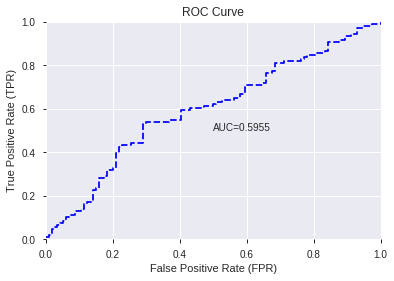

This function is available for GLM models only


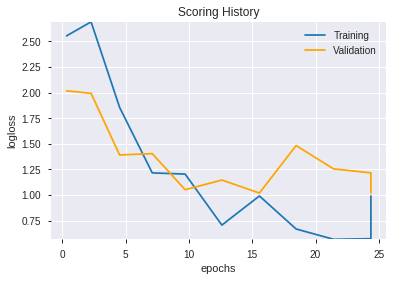

--2019-08-28 14:12:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_134755_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_134755_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLINNECK',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLRISEFALL3METHODS',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'CDLONNECK',
 'CDLTASUKIGAP',
 'CDLIDENTICAL3CROWS',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLHIKKAKEMOD',
 'CDLXSIDEGAP3METHODS',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLSEPARATINGLINES',
 'CDLHARAMICROSS',
 'CDL3INSIDE',
 'CDLMATCHINGLOW',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'CEIL',
 'CDLGRAVESTONEDOJI',
 'is_month_start',
 'CORREL_8',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'FLOOR',
 'aroondown_8',
 'BOP',
 'is_month_end',
 'CDLDOJISTAR',
 'hour',
 'SAREXT',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'HT_PHASOR_quadrature',
 'dayofweek',
 'aroondown_12',
 'weekday',
 'CDLLONGLINE',
 'VAR_8',
 'day',
 'STOCHRSI_fastk',
 'CDLHIKKAKE',
 'AROONOSC_8',
 'days_in_month',
 'STOC

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_141244_model_1  0.543777  0.691972              0.495614  0.499413  0.249413

variable  relative_importance  scaled_importance    percentage
0                  CDLLONGLINE         8.590470e-03           1.000000  1.364734e-02
1                    CDLTAKURI         7.233492e-03           0.842037  1.149156e-02
2           CDLCLOSINGMARUBOZU         7.204966e-03           0.838716  1.144624e-02
3                 CDLTHRUSTING         6.767164e-03           0.787753  1.075072e-02
4                   CDL3INSIDE         6.467521e-03           0.752872  1.027469e-02
...                        ...                  ...                ...           ...
1027  BBANDS_middleband_14_7_5         1.633866e-07           0.000019  2.595658e-07
1028  BBANDS_middleband_12_6_5         8.017925e-08           0.000009  1.273776e-07
1029                 MAVP_14_7         1.706298e-08           0.000002  2.710728e-08
1030  BBANDS_middleband_12_7_5         0.000000e+00           0.000000  0.000000e+00
1031   BBANDS_lowerband_14_0_3         0.000000e+00           0.000000  0.000000e+00

[1032 rows x 4 columns]

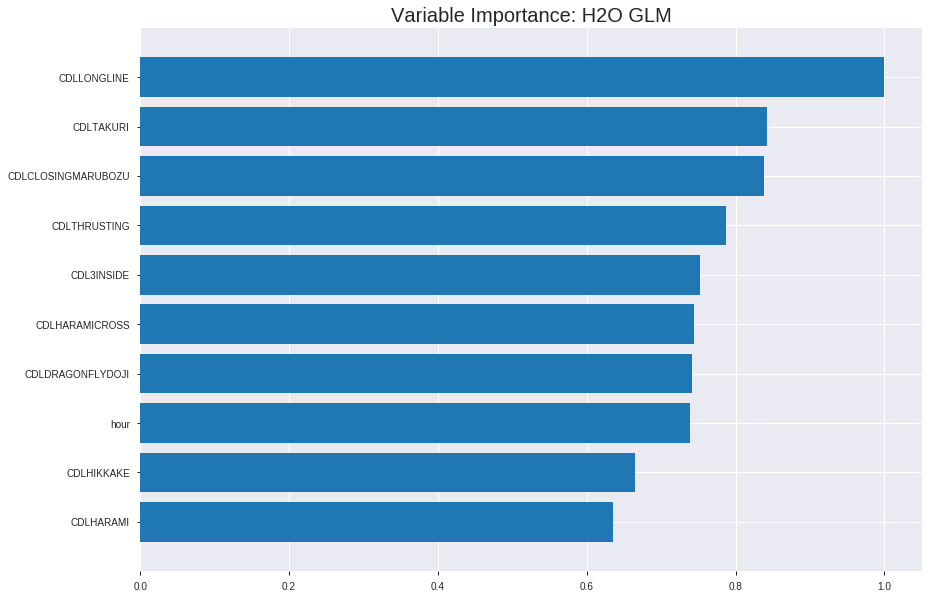

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_141244_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24713741506688225
RMSE: 0.4971291734216392
LogLoss: 0.6874143963037731
Null degrees of freedom: 1536
Residual degrees of freedom: 506
Null deviance: 2130.5464005801423
Residual deviance: 2113.1118542377985
AIC: 4175.111854237799
AUC: 0.6020388809862495
pr_auc: 0.5921690413499361
Gini: 0.20407776197249894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48491127220711877: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      110  650   0.8553   (650.0/760.0)
1      40   737   0.0515   (40.0/777.0)
Total  150  1387  0.4489   (690.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484911     0.681146  319
max f2                       0.464958     0.838382  380
max f0point5                 0.495499     0.595127  261
max accuracy                 0.495499     0.57905   261
max precision                0.570353     1         0
max recall                   0.458611     1         391
max specificity              0.570353     1         0
max absolute_mcc             0.495499     0.175812  261
max min_per_class_accuracy   0.506054     0.56242   187
max mean_per_class_accuracy  0.495499     0.576314  261

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.541798           1.60722   1.60722            0.8125           0.548351  0.8125                      0.548351            0.016731        0.016731                   60.7223   60.7223
    2        0.0201692                   0.536457           1.055     1.34002            0.533333         0.539088  0.677419                    0.543869            0.010296        0.027027                   5.49979   34.0017
    3        0.0305791                   0.534481           1.60722   1.43098            0.8125           0.535599  0.723404                    0.541054            0.016731        0.043758                   60.7223   43.0981
    4        0.0403383                   0.531412           1.45062   1.43573            0.733333         0.532852  0.725806                    0.539069            0.014157        0.0579151                  45.0622   43.5733
    5        0.0500976                   0.530718           1.18687   1.38725            0.6              0.531008  0.701299                    0.537499            0.011583        0.0694981                  18.6873   38.7254
    6        0.100195                    0.525809           1.15604   1.27165            0.584416         0.527958  0.642857                    0.532729            0.0579151       0.127413                   15.6045   27.1649
    7        0.150293                    0.521638           1.20742   1.25024            0.61039          0.52367   0.632035                    0.529709            0.0604891       0.187902                   20.7424   25.0241
    8        0.20039                     0.518163           1.07898   1.20742            0.545455         0.519932  0.61039                     0.527265            0.0540541       0.241956                   7.89751   20.7424
    9        0.299935                    0.51359            1.11188   1.17572            0.562092         0.515839  0.59436                     0.523473            0.110682        0.352638                   11.1885   17.5716
    10       0.40013                     0.509982           1.07898   1.15149            0.545455         0.511878  0.582114                    0.520569            0.108108        0.460746                   7.89751   15.1492
    11       0.500325                    0.50593            1.0276    1.12668            0.519481         0.508204  0.569571                    0.518093            0.10296         0.563707                   2.75953   12.668
    12       0.59987                     0.50229            1.0731    1.11779            0.542484         0.504096  0.565076                    0.51577             0.106821        0.670528                   7.30983   11.7789
    13       0.700065                    0.498096           0.98906   1.09936            0.5              0.500332  0.555762                    0.513561            0.0990991       0.769627                   -1.09395  9.93646
    14       0.79961                     0.492977           0.917952  1.07678            0.464052         0.495415  0.544345                    0.511302            0.0913771       0.861004                   -8.20484  7.67803
    15       0.899805                    0.485388           0.847766  1.05128            0.428571         0.489814  0.531453                    0.508909            0.0849421       0.945946                   -15.2234  5.1279
    16       1                           0.438465           0.539488  1                  0.272727         0.475186  0.50553                     0.50553            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2492228174636877
RMSE: 0.49922221251030857
LogLoss: 0.6915937399819736
Null degrees of freedom: 439
Residual degrees of freedom: -591
Null deviance: 608.8730098202949
Residual deviance: 608.6024911841367
AIC: 2670.602491184137
AUC: 0.5328765401056073
pr_auc: 0.5685520631763917
Gini: 0.06575308021121451
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4442721525011518: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    246  0        (0.0/246.0)
Total  0    440  0.4409   (194.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444272     0.717201  399
max f2                       0.444272     0.863764  399
max f0point5                 0.48546      0.624257  321
max accuracy                 0.485735     0.579545  319
max precision                0.523196     0.606061  30
max recall                   0.444272     1         399
max specificity              0.551991     0.994845  0
max absolute_mcc             0.485735     0.11004   319
max min_per_class_accuracy   0.503013     0.525773  198
max mean_per_class_accuracy  0.49161      0.544485  284

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 50.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.533975           1.07317   1.07317            0.6              0.541398  0.6                         0.541398            0.0121951       0.0121951                  7.31707   7.31707
    2        0.0204545                   0.532123           0.447154  0.794941           0.25             0.532674  0.444444                    0.537521            0.00406504      0.0162602                  -55.2846  -20.5059
    3        0.0318182                   0.52805            0.357724  0.638792           0.2              0.53035   0.357143                    0.53496             0.00406504      0.0203252                  -64.2276  -36.1208
    4        0.0409091                   0.526748           1.34146   0.794941           0.75             0.527084  0.444444                    0.53321             0.0121951       0.0325203                  34.1463   -20.5059
    5        0.05                        0.525222           1.78862   0.97561            1                0.525983  0.545455                    0.531896            0.0162602       0.0487805                  78.8618   -2.43902
    6        0.1                         0.521248           1.13821   1.05691            0.636364         0.523242  0.590909                    0.527569            0.0569106       0.105691                   13.8211   5.69106
    7        0.15                        0.517829           0.894309  1.00271            0.5              0.519699  0.560606                    0.524946            0.0447154       0.150407                   -10.5691  0.271003
    8        0.2                         0.515546           1.13821   1.03659            0.636364         0.516426  0.579545                    0.522816            0.0569106       0.207317                   13.8211   3.65854
    9        0.3                         0.510908           0.853659  0.97561            0.477273         0.513348  0.545455                    0.51966             0.0853659       0.292683                   -14.6341  -2.43902
    10       0.4                         0.5078             1.26016   1.04675            0.704545         0.509496  0.585227                    0.517119            0.126016        0.418699                   26.0163   4.6748
    11       0.5                         0.503213           1.01626   1.04065            0.568182         0.505336  0.581818                    0.514762            0.101626        0.520325                   1.62602   4.06504
    12       0.6                         0.498621           1.01626   1.03659            0.568182         0.500789  0.579545                    0.512434            0.101626        0.621951                   1.62602   3.65854
    13       0.7                         0.49364            1.13821   1.0511             0.636364         0.49632   0.587662                    0.510132            0.113821        0.735772                   13.8211   5.11034
    14       0.8                         0.486371           0.934959  1.03659            0.522727         0.490252  0.579545                    0.507647            0.0934959       0.829268                   -6.50407  3.65854
    15       0.9                         0.477844           0.853659  1.01626            0.477273         0.48304   0.568182                    0.504913            0.0853659       0.914634                   -14.6341  1.62602
    16       1                           0.444272           0.853659  1                  0.477273         0.467573  0.559091                    0.501179    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 14:12:48  0.000 sec   2            3.4       1031          1.37483           1.38319
    2019-08-28 14:12:50  1.993 sec   4            2.4       1032          1.37166           1.38413
    2019-08-28 14:12:52  4.082 sec   6            1.8       1032          1.36782           1.38587
    2019-08-28 14:12:54  6.114 sec   8            1.3       1033          1.36327           1.38853
    2019-08-28 14:12:56  8.100 sec   10           0.94      1033          1.35803           1.3923
    2019-08-28 14:12:58  10.100 sec  12           0.69      1033          1.35218           1.39743

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.6523076923076924)

('auc', 0.5437768950678583)

('logloss', 0.6919723510856925)

('mean_per_class_error', 0.4450513075140682)

('rmse', 0.4994127138609443)

('mse', 0.24941305876595343)

glm prediction progress: |████████████████████████████████████████████████| 100%


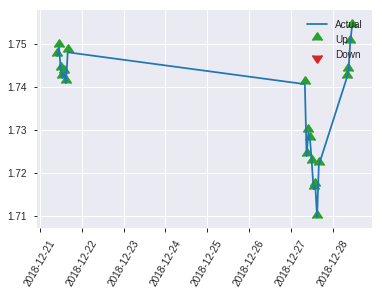


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24941305876595343
RMSE: 0.4994127138609443
LogLoss: 0.6919723510856925
Null degrees of freedom: 219
Residual degrees of freedom: -811
Null deviance: 305.18865009111494
Residual deviance: 304.46783447770474
AIC: 2366.467834477705
AUC: 0.5437768950678583
pr_auc: 0.5130026768449192
Gini: 0.08755379013571662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4474352186296657: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    113  0.9912   (113.0/114.0)
1      0    106  0        (0.0/106.0)
Total  1    219  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447435     0.652308  218
max f2                       0.447435     0.824261  218
max f0point5                 0.501221     0.548048  139
max accuracy                 0.508795     0.554545  83
max precision                0.522873     0.611111  17
max recall                   0.447435     1         218
max specificity              0.544594     0.991228  0
max absolute_mcc             0.504978     0.109843  111
max min_per_class_accuracy   0.5051       0.552632  109
max mean_per_class_accuracy  0.504978     0.554949  111

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.536128           0.691824  0.691824           0.333333         0.539864  0.333333                    0.539864            0.00943396      0.00943396                 -30.8176  -30.8176
    2        0.0227273                   0.533222           2.07547   1.24528            1                0.534222  0.6                         0.537607            0.0188679       0.0283019                  107.547   24.5283
    3        0.0318182                   0.530542           1.03774   1.18598            0.5              0.532104  0.571429                    0.536035            0.00943396      0.0377358                  3.77358   18.5984
    4        0.0409091                   0.52841            1.03774   1.15304            0.5              0.529634  0.555556                    0.534613            0.00943396      0.0471698                  3.77358   15.304
    5        0.05                        0.527204           1.03774   1.13208            0.5              0.528009  0.545455                    0.533412            0.00943396      0.0566038                  3.77358   13.2075
    6        0.1                         0.52151            1.13208   1.13208            0.545455         0.523571  0.545455                    0.528492            0.0566038       0.113208                   13.2075   13.2075
    7        0.15                        0.517327           1.13208   1.13208            0.545455         0.519326  0.545455                    0.525436            0.0566038       0.169811                   13.2075   13.2075
    8        0.2                         0.515746           1.13208   1.13208            0.545455         0.516446  0.545455                    0.523189            0.0566038       0.226415                   13.2075   13.2075
    9        0.3                         0.511714           0.943396  1.06918            0.454545         0.513886  0.515152                    0.520088            0.0943396       0.320755                   -5.66038  6.91824
    10       0.4                         0.507904           1.13208   1.08491            0.545455         0.51009   0.522727                    0.517588            0.113208        0.433962                   13.2075   8.49057
    11       0.5                         0.505045           1.22642   1.11321            0.590909         0.506116  0.536364                    0.515294            0.122642        0.556604                   22.6415   11.3208
    12       0.6                         0.502404           0.849057  1.06918            0.409091         0.503712  0.515152                    0.513363            0.0849057       0.641509                   -15.0943  6.91824
    13       0.7                         0.499182           0.754717  1.02426            0.363636         0.500799  0.493506                    0.511568            0.0754717       0.716981                   -24.5283  2.42588
    14       0.8                         0.494712           1.03774   1.02594            0.5              0.497362  0.494318                    0.509793            0.103774        0.820755                   3.77358   2.59434
    15       0.9                         0.482734           0.849057  1.00629            0.409091         0.489621  0.484848                    0.507551            0.0849057       0.90566                    -15.0943  0.628931
    16       1                           0.447393           0.943396  1                  0.454545         0.468561  0.481818                    0.503652        

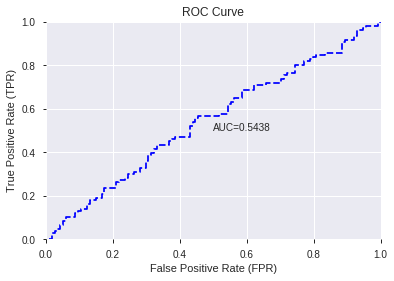

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


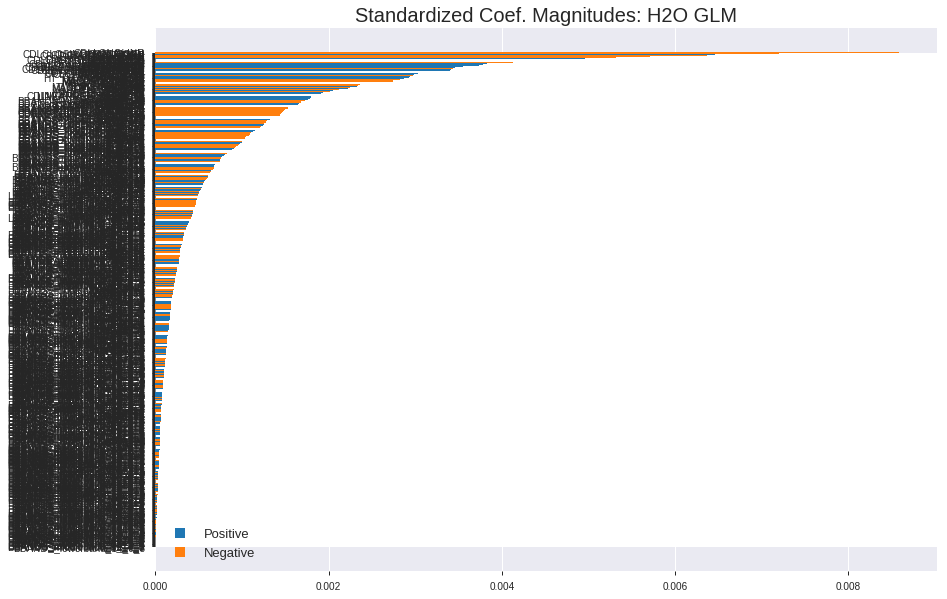

'log_likelihood'
--2019-08-28 14:13:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.28
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.28|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_141244_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_141244_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLLONGLINE',
 'CDLTAKURI',
 'CDLCLOSINGMARUBOZU',
 'CDLTHRUSTING',
 'CDL3INSIDE',
 'CDLHARAMICROSS',
 'CDLDRAGONFLYDOJI',
 'hour',
 'CDLHIKKAKE',
 'CDLHARAMI',
 'VAR_8',
 'BETA_8',
 'PLUS_DI_30',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'PLUS_DI_24',
 'PLUS_DI_20',
 'STDDEV_8',
 'CDLMARUBOZU',
 'CORREL_8',
 'is_month_end',
 'CDLIDENTICAL3CROWS',
 'aroondown_24',
 'PLUS_DI_14',
 'PLUS_DM_30',
 'SAREXT',
 'CDLSTALLEDPATTERN',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DI_12',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLRISEFALL3METHODS',
 'CDLONNECK',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLSHORTLINE',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLHIGHWAVE',
 'STOCHF_fastk',
 'CDLSHOOTINGSTAR',
 'CORREL_14',
 'CDLEVENINGSTAR',
 'PLUS_DM_24',
 'aroonup_30',
 'ADX_24',
 'weekofyear',
 'week',
 'aroondown_20',
 'dayofyear',
 'HT_PHASOR_inphase',
 'STOCH_slowd',
 'PLUS_DI_8',
 'MACDFIX_hist_14',
 'MACDFIX_hist_12',
 'MACDFIX_hist_20',
 'MACD_hist',
 'MACDFIX_hist_24',

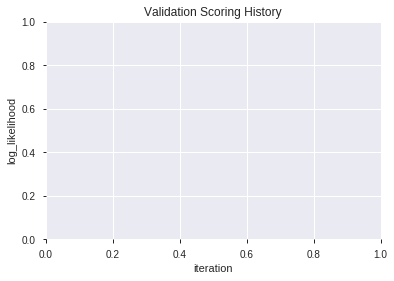

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_141331_model_6  0.551556  0.698990              0.456140  0.502506  0.252512
1               XGBoost_1_AutoML_20190828_141331  0.528798  0.714369              0.466236  0.509432  0.259521
2  XGBoost_grid_1_AutoML_20190828_141331_model_5  0.520689  0.754273              0.462843  0.523219  0.273758
3  XGBoost_grid_1_AutoML_20190828_141331_model_1  0.513985  0.708135              0.500000  0.507011  0.257060
4  XGBoost_grid_1_AutoML_20190828_141331_model_3  0.508358  0.716427              0.458788  0.510670  0.260784
5               XGBoost_2_AutoML_20190828_141331  0.485435  0.716337              0.491228  0.510923  0.261042
6  XGBoost_grid_1_AutoML_20190828_141331_model_7  0.485435  0.748494              0.500000  0.523989  0.274564
7               XGBoost_3_AutoML_20190828_141331  0.471119  0.720544              0.474677  0.513011  0.263181
8  XGBoost_grid_1_AutoML_20190828_141331_model_2  0.467395  0.714585              0.495614  0.510267  0.260373
9  XGBoost_grid_1_AutoML_20190828_141331_model_4  0.462678  0.714054              0.500000  0.510102  0.260204

variable  relative_importance  scaled_importance  percentage
0                      ADOSC           110.699432           1.000000    0.016190
1                     Volume           107.983063           0.975462    0.015793
2       HT_PHASOR_quadrature            98.677742           0.891402    0.014432
3                   WILLR_14            98.622749           0.890906    0.014424
4                     ULTOSC            95.624695           0.863823    0.013985
..                       ...                  ...                ...         ...
290  BBANDS_upperband_20_1_2             3.435133           0.031031    0.000502
291             HT_TRENDMODE             3.307276           0.029876    0.000484
292  BBANDS_upperband_30_1_2             3.110072           0.028095    0.000455
293  BBANDS_upperband_30_6_3             2.860694           0.025842    0.000418
294                 MAVP_8_3             0.489267           0.004420    0.000072

[295 rows x 4 columns]

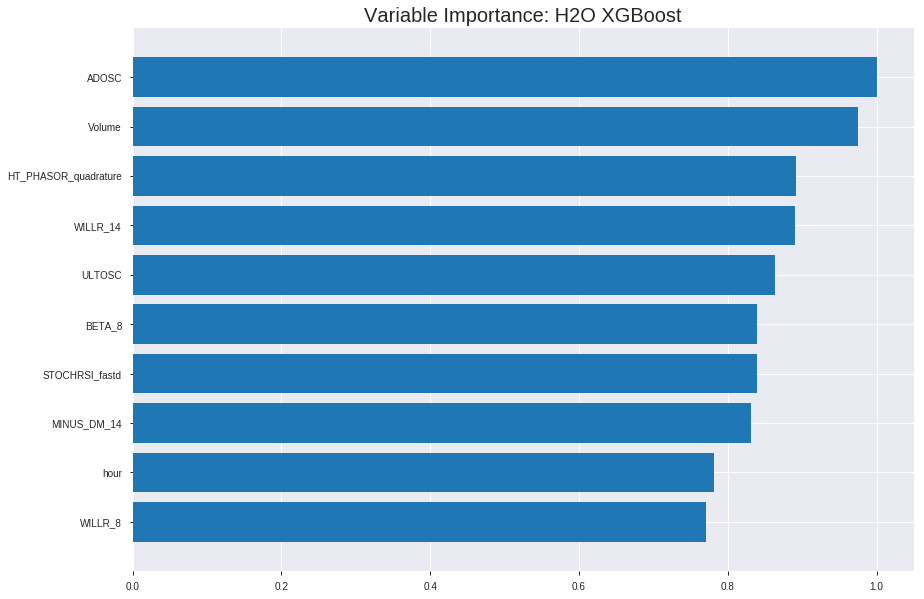

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_141331_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1718806070061633
RMSE: 0.41458486104314435
LogLoss: 0.5322936275777769
Mean Per-Class Error: 0.11264986791302589
AUC: 0.959628801734065
pr_auc: 0.9610740007334895
Gini: 0.9192576034681299
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5059871673583984: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      668  92   0.1211   (92.0/760.0)
1      81   696  0.1042   (81.0/777.0)
Total  749  788  0.1126   (173.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505987     0.889457  202
max f2                       0.447325     0.928537  256
max f0point5                 0.532852     0.908576  176
max accuracy                 0.505987     0.887443  202
max precision                0.804548     1         0
max recall                   0.364798     1         330
max specificity              0.804548     1         0
max absolute_mcc             0.505987     0.774902  202
max min_per_class_accuracy   0.509186     0.884211  199
max mean_per_class_accuracy  0.505987     0.88735   202

Gains/Lift Table: Avg response rate: 50.55 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.739987           1.97812    1.97812            1                0.765024  1                           0.765024            0.020592        0.020592                   97.8121   97.8121
    2        0.0201692                   0.71824            1.97812    1.97812            1                0.727427  1                           0.746832            0.019305        0.039897                   97.8121   97.8121
    3        0.0305791                   0.70227            1.97812    1.97812            1                0.710359  1                           0.734416            0.020592        0.0604891                  97.8121   97.8121
    4        0.0403383                   0.691006           1.97812    1.97812            1                0.695444  1                           0.724987            0.019305        0.0797941                  97.8121   97.8121
    5        0.0500976                   0.684206           1.97812    1.97812            1                0.68721   1                           0.717628            0.019305        0.0990991                  97.8121   97.8121
    6        0.100195                    0.659071           1.97812    1.97812            1                0.67182   1                           0.694724            0.0990991       0.198198                   97.8121   97.8121
    7        0.150293                    0.639324           1.97812    1.97812            1                0.648854  1                           0.679434            0.0990991       0.297297                   97.8121   97.8121
    8        0.20039                     0.619184           1.97812    1.97812            1                0.628915  1                           0.666804            0.0990991       0.396396                   97.8121   97.8121
    9        0.299935                    0.584723           1.90055    1.95238            0.960784         0.600585  0.986985                    0.644827            0.189189        0.585586                   90.0548   95.2375
    10       0.40013                     0.550332           1.69553    1.88806            0.857143         0.568006  0.954472                    0.625591            0.169884        0.75547                    69.5532   88.806
    11       0.500325                    0.511685           1.24596    1.75947            0.62987          0.531078  0.889467                    0.606663            0.124839        0.880309                   24.5959   75.9473
    12       0.59987                     0.471216           0.801592   1.60052            0.405229         0.491001  0.809111                    0.58747             0.0797941       0.960103                   -19.8408  60.0519
    13       0.700065                    0.431992           0.295434   1.41373            0.149351         0.450394  0.714684                    0.567851            0.029601        0.989704                   -70.4566  41.3731
    14       0.79961                     0.390559           0.0775734  1.24739            0.0392157        0.411067  0.630594                    0.548333            0.00772201      0.997426                   -92.2427  24.7391
    15       0.899805                    0.350073           0.0256899  1.11135            0.012987         0.370769  0.561822                    0.528561            0.002574        1                          -97.431   11.1352
    16       1                           0.228431           0          1                  0                0.313355  0.50553                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2621533762282836
RMSE: 0.5120091563910587
LogLoss: 0.7182144431350262
Mean Per-Class Error: 0.4821892548822395
AUC: 0.4758612019109882
pr_auc: 0.5478767611311578
Gini: -0.04827759617802363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30925503373146057: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    187  0.9639   (187.0/194.0)
1      2    244  0.0081   (2.0/246.0)
Total  9    431  0.4295   (189.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.309255     0.720827   391
max f2                       0.274738     0.863764   399
max f0point5                 0.309255     0.619289   391
max accuracy                 0.324974     0.570455   389
max precision                0.795487     1          0
max recall                   0.274738     1          399
max specificity              0.795487     1          0
max absolute_mcc             0.309255     0.0980455  391
max min_per_class_accuracy   0.471074     0.487805   200
max mean_per_class_accuracy  0.549395     0.517811   68

Gains/Lift Table: Avg response rate: 55.91 %, avg score: 47.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.724244           0.715447  0.715447           0.4              0.753078  0.4                         0.753078            0.00813008      0.00813008                 -28.4553  -28.4553
    2        0.0204545                   0.661138           1.34146   0.993677           0.75             0.683187  0.555556                    0.722015            0.0121951       0.0203252                  34.1463   -0.63234
    3        0.0318182                   0.636842           1.07317   1.02207            0.6              0.647766  0.571429                    0.695498            0.0121951       0.0325203                  7.31707   2.20674
    4        0.0409091                   0.629336           0.894309  0.993677           0.5              0.631944  0.555556                    0.681374            0.00813008      0.0406504                  -10.5691  -0.63234
    5        0.05                        0.620537           1.34146   1.05691            0.75             0.626641  0.590909                    0.671423            0.0121951       0.0528455                  34.1463   5.69106
    6        0.1                         0.570179           1.13821   1.09756            0.636364         0.591966  0.613636                    0.631695            0.0569106       0.109756                   13.8211   9.7561
    7        0.15                        0.552011           1.05691   1.08401            0.590909         0.560746  0.606061                    0.608045            0.0528455       0.162602                   5.69106   8.40108
    8        0.2                         0.535458           0.731707  0.995935           0.409091         0.542915  0.556818                    0.591763            0.0365854       0.199187                   -26.8293  -0.406504
    9        0.3                         0.513092           0.813008  0.934959           0.454545         0.52266   0.522727                    0.568728            0.0813008       0.280488                   -18.6992  -6.50407
    10       0.4                         0.491874           1.09756   0.97561            0.613636         0.502835  0.545455                    0.552255            0.109756        0.390244                   9.7561    -2.43902
    11       0.5                         0.470704           0.97561   0.97561            0.545455         0.481207  0.545455                    0.538045            0.097561        0.487805                   -2.43902  -2.43902
    12       0.6                         0.453977           0.853659  0.955285           0.477273         0.462616  0.534091                    0.525474            0.0853659       0.573171                   -14.6341  -4.47154
    13       0.7                         0.432753           1.05691   0.969803           0.590909         0.443298  0.542208                    0.513734            0.105691        0.678862                   5.69106   -3.01974
    14       0.8                         0.411733           0.97561   0.970528           0.545455         0.421176  0.542614                    0.502165            0.097561        0.776423                   -2.43902  -2.94715
    15       0.9                         0.375069           1.17886   0.993677           0.659091         0.392965  0.555556                    0.490031            0.117886        0.894309                   17.8862   -0.63234
    16       1                           0.274708           1.05691   1                  0.590909         0.339242  0.559091                    0.4749


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:14:14  25.682 sec  0                  0.5              0.693147            0.5             0                  1                0.49447                          0.5                0.693147              0.5               0                    1                  0.440909
    2019-08-28 14:14:15  26.738 sec  5                  0.491158         0.675592            0.752577        0.744996           1.86176          0.338321                         0.501108           0.695366              0.487805          0.557446             1.07317            0.434091
    2019-08-28 14:14:15  26.944 sec  10                 0.480635         0.655011            0.829039        0.826651           1.97812          0.266103                         0.502959           0.699116              0.489293          0.548301             1.07317            0.438636
    2019-08-28 14:14:15  27.158 sec  15                 0.470004         0.634576            0.879957        0.881329           1.97812          0.204294                         0.503659           0.700535              0.489272          0.552701             1.07317            0.436364
    2019-08-28 14:14:15  27.376 sec  20                 0.460968         0.61745             0.906672        0.907711           1.97812          0.182824                         0.503454           0.700146              0.504914          0.557509             1.07317            0.431818
    2019-08-28 14:14:16  27.603 sec  25                 0.451411         0.599554            0.923978        0.924615           1.97812          0.162004                         0.505429           0.704192              0.491859          0.549602             0.715447           0.429545
    2019-08-28 14:14:16  27.816 sec  30                 0.444466         0.58666             0.932669        0.933577           1.97812          0.14704                          0.506619           0.706607              0.476521          0.546705             0.715447           0.431818
    2019-08-28 14:14:16  28.029 sec  35                 0.437234         0.573325            0.940164        0.942503           1.97812          0.151594                         0.508372           0.710248              0.480178          0.548872             1.07317            0.427273
    2019-08-28 14:14:16  28.248 sec  40                 0.429145         0.558546            0.948005        0.949948           1.97812          0.137931                         0.508847           0.711291              0.489565          0.552632             1.07317            0.429545
    2019-08-28 14:14:16  28.469 sec  45                 0.420648         0.543242            0.957392        0.959406           1.97812          0.119063                         0.509724           0.713198              0.482755          0.549027             0.715447           0.427273
    2019-08-28 14:14:17  28.702 sec  50                 0.414585         0.532294            0.959629        0.961074           1.97812          0.112557                         0.512009           0.718214              0.475861          0.547877             0.715447           0.429545

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
ADOSC                    110.69943237304688     1.0                   0.01619016621518475
Volume                   107.98306274414062     0.9754617564817104    0.015792887973994963
HT_PHASOR_quadrature     98.67774200439453      0.8914024208530685    0.01443195335822925
WILLR_14                 98.62274932861328      0.890905646166854     0.014423910493487938
ULTOSC                   95.62469482421875      0.8638228107798452    0.01398543488699378
---                      ---                    ---                   ---
BBANDS_upperband_20_1_2  3.4351325035095215     0.031031166374308423  0.0005023997414511053
HT_TRENDMODE             3.3072760105133057     0.029876178582091465  0.0004837002971186035
BBANDS_upperband_30_1_2  3.110072135925293      0.028094743299537768  0.00045485856379246447
BBANDS_upperband_30_6_3  2.860694408416748      0.025841997082482516  0.0004183862280977113
MAVP_8_3                 0.48926693201065063    0.004419778146304005  7.155694282290298e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5681818181818182)

('F1', 0.6708860759493671)

('auc', 0.5515557762330354)

('logloss', 0.6989904681486161)

('mean_per_class_error', 0.4358656074147633)

('rmse', 0.5025056847945845)

('mse', 0.2525119632508743)

xgboost prediction progress: |████████████████████████████████████████████| 100%


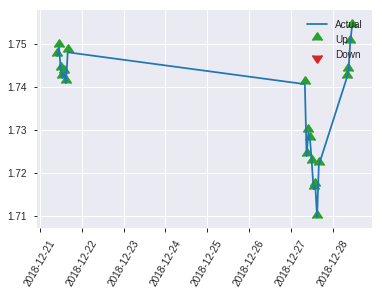


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2525119632508743
RMSE: 0.5025056847945845
LogLoss: 0.6989904681486161
Mean Per-Class Error: 0.4358656074147633
AUC: 0.5515557762330354
pr_auc: 0.5135921650052329
Gini: 0.10311155246607084
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36584022641181946: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   104  0.9123   (104.0/114.0)
1      0    106  0        (0.0/106.0)
Total  10   210  0.4727   (104.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36584      0.670886  209
max f2                       0.36584      0.835962  209
max f0point5                 0.384585     0.56044   200
max accuracy                 0.531023     0.568182  84
max precision                0.804219     1         0
max recall                   0.36584      1         209
max specificity              0.804219     1         0
max absolute_mcc             0.36584      0.210422  209
max min_per_class_accuracy   0.503426     0.552632  109
max mean_per_class_accuracy  0.531023     0.564134  84

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.770877           1.38365   1.38365            0.666667         0.789573  0.666667                    0.789573            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.744616           1.03774   1.24528            0.5              0.752167  0.6                         0.774611            0.00943396      0.0283019                  3.77358   24.5283
    3        0.0318182                   0.741057           1.03774   1.18598            0.5              0.742033  0.571429                    0.765303            0.00943396      0.0377358                  3.77358   18.5984
    4        0.0409091                   0.723541           0         0.922432           0                0.733614  0.444444                    0.758261            0               0.0377358                  -100      -7.75681
    5        0.05                        0.720534           2.07547   1.13208            1                0.722547  0.545455                    0.751767            0.0188679       0.0566038                  107.547   13.2075
    6        0.1                         0.672881           1.13208   1.13208            0.545455         0.695111  0.545455                    0.723439            0.0566038       0.113208                   13.2075   13.2075
    7        0.15                        0.632278           1.13208   1.13208            0.545455         0.65151   0.545455                    0.699463            0.0566038       0.169811                   13.2075   13.2075
    8        0.2                         0.606697           1.13208   1.13208            0.545455         0.617534  0.545455                    0.678981            0.0566038       0.226415                   13.2075   13.2075
    9        0.3                         0.555801           0.660377  0.974843           0.318182         0.581617  0.469697                    0.646526            0.0660377       0.292453                   -33.9623  -2.51572
    10       0.4                         0.526863           1.60377   1.13208            0.772727         0.537756  0.545455                    0.619334            0.160377        0.45283                    60.3774   13.2075
    11       0.5                         0.501733           1.03774   1.11321            0.5              0.515311  0.536364                    0.598529            0.103774        0.556604                   3.77358   11.3208
    12       0.6                         0.484268           0.660377  1.03774            0.318182         0.493361  0.5                         0.581001            0.0660377       0.622642                   -33.9623  3.77358
    13       0.7                         0.463054           1.13208   1.05121            0.545455         0.471044  0.506494                    0.565293            0.113208        0.735849                   13.2075   5.12129
    14       0.8                         0.43661            1.03774   1.04953            0.5              0.450062  0.505682                    0.550889            0.103774        0.839623                   3.77358   4.95283
    15       0.9                         0.395205           1.03774   1.04822            0.5              0.413129  0.505051                    0.535582            0.103774        0.943396                   3.77358   4.8218
    16       1                           0.312852           0.566038  1                  0.272727         0.360752  0.481818                    0.518099        

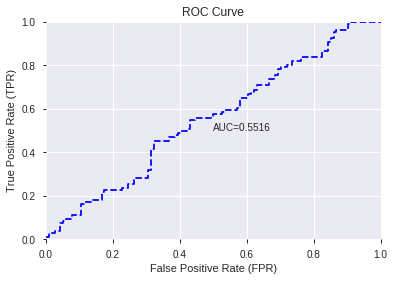

This function is available for GLM models only


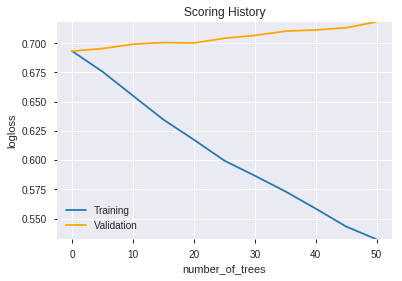

--2019-08-28 14:14:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_141331_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_141331_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8d37',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['ADOSC',
 'Volume',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'ULTOSC',
 'BETA_8',
 'STOCHRSI_fastd',
 'MINUS_DM_14',
 'hour',
 'WILLR_8',
 'BETA_24',
 'CORREL_14',
 'CORREL_12',
 'AD',
 'BETA_20',
 'DX_14',
 'ATR_8',
 'BOP',
 'STOCH_slowk',
 'WILLR_12',
 'ADX_14',
 'DX_30',
 'ADXR_8',
 'STDDEV_12',
 'CORREL_20',
 'HT_PHASOR_inphase',
 'CCI_30',
 'MACDEXT_hist',
 'HT_DCPERIOD',
 'MFI_30',
 'BETA_14',
 'MFI_14',
 'MFI_24',
 'aroondown_30',
 'TRANGE',
 'CCI_8',
 'PLUS_DM_8',
 'CMO_8',
 'MOM_30',
 'STOCH_slowd',
 'NATR_30',
 'MACDFIX_signal_20',
 'CORREL_24',
 'CCI_24',
 'PLUS_DI_24',
 'MOM_20',
 'PLUS_DI_30',
 'PLUS_DI_8',
 'CDLCLOSINGMARUBOZU',
 'BETA_12',
 'ROC_8',
 'STDDEV_30',
 'PLUS_DI_20',
 'MOM_12',
 'CCI_12',
 'MFI_20',
 'NATR_8',
 'ADXR_12',
 'STDDEV_8',
 'MACDEXT_signal',
 'ADX_24',
 'MINUS_DI_8',
 'MACDFIX_signal_12',
 'ADX_8',
 'TRIX_12',
 'CORREL_8',
 'dayofyear',
 'MACDFIX_hist_24',
 'PLUS_DM_30',
 'MOM_24',
 'aroondown_24',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'aroondown_12',

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.623
GLM             0.559
XGBoost         0.577
dtype: float64

DeepLearning    GLM  XGBoost
All          0.600  0.559    0.577
DLF          0.582  0.518    0.555
Fwe          0.591  0.559    0.577
RFE          0.623  0.555    0.568
XGBF         0.564  0.518    0.555





F1


DeepLearning    0.680
GLM             0.652
XGBoost         0.671
dtype: float64

DeepLearning    GLM  XGBoost
All          0.650  0.652    0.652
DLF          0.650  0.650    0.652
Fwe          0.680  0.652    0.652
RFE          0.654  0.652    0.671
XGBF         0.652  0.650    0.652





auc


DeepLearning    0.610
GLM             0.544
XGBoost         0.552
dtype: float64

DeepLearning    GLM  XGBoost
All          0.590  0.544    0.541
DLF          0.567  0.452    0.490
Fwe          0.610  0.544    0.541
RFE          0.595  0.544    0.552
XGBF         0.557  0.452    0.490





logloss


DeepLearning    1.662
GLM             0.695
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          1.479  0.692    0.706
DLF          0.703  0.695    0.717
Fwe          0.801  0.692    0.706
RFE          1.662  0.692    0.699
XGBF         0.865  0.695    0.717





mean_per_class_error


DeepLearning    0.436
GLM             0.495
XGBoost         0.456
dtype: float64

DeepLearning    GLM  XGBoost
All          0.410  0.441    0.428
DLF          0.430  0.495    0.456
Fwe          0.403  0.441    0.428
RFE          0.380  0.445    0.436
XGBF         0.436  0.495    0.456





rmse


DeepLearning    0.629
GLM             0.501
XGBoost         0.511
dtype: float64

DeepLearning    GLM  XGBoost
All          0.612  0.499    0.506
DLF          0.505  0.501    0.511
Fwe          0.497  0.499    0.506
RFE          0.629  0.499    0.503
XGBF         0.543  0.501    0.511





mse


DeepLearning    0.395
GLM             0.251
XGBoost         0.261
dtype: float64

DeepLearning    GLM  XGBoost
All          0.375  0.249    0.256
DLF          0.255  0.251    0.261
Fwe          0.247  0.249    0.256
RFE          0.395  0.249    0.253
XGBF         0.295  0.251    0.261

{'F1':       DeepLearning    GLM  XGBoost
 All          0.650    NaN      NaN
 DLF          0.650    NaN      NaN
 DLF            NaN  0.650      NaN
 DLF            NaN    NaN    0.652
 All            NaN  0.652      NaN
 All            NaN    NaN    0.652
 XGBF         0.652    NaN      NaN
 XGBF           NaN  0.650      NaN
 XGBF           NaN    NaN    0.652
 Fwe          0.680    NaN      NaN
 Fwe            NaN  0.652      NaN
 Fwe            NaN    NaN    0.652
 RFE          0.654    NaN      NaN
 RFE            NaN  0.652      NaN
 RFE            NaN    NaN    0.671,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.600    NaN      NaN
 DLF          0.582    NaN      NaN
 DLF            NaN  0.518      NaN
 DLF            NaN    NaN    0.555
 All            NaN  0.559      NaN
 All            NaN    NaN    0.577
 XGBF         0.564    NaN      NaN
 XGBF           NaN  0.518      NaN
 XGBF           NaN    NaN    0.555
 Fwe          0.591    NaN      NaN
 Fwe     